In [4]:
# Load modules for data management
import pandas as pd
import numpy as np
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.collections as mplcol
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import proportional_hazard_test
# Import necessary modules for classification
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Set figure DPI for publication quality for matplotlib.pyplot
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
# ...and seaborn
sns.set(rc={"figure.dpi":150, 'savefig.dpi':300})

sns.set_style('white')


# SEER Salivary Tumor Data Missing Values
Although it appears that there are minimal null values, this is likely due to the way that data have been logged. For each relevant column, we may need to address missing values individually. They may be logged as, for example, 'XX' or '99' or 'Unknown'. As such, we will always view unique values in each column before evaluations and strive to identify anything that may be a missing value.


# Data Cleaning: Categorical Adjustments and  Orders Including Histology and Grade 

In [5]:
# Load Major Salivary Tumor Listing data
salivary_df = pd.read_csv("SEEROutput.csv",low_memory=False)
# Look at data header
# display(salivary_df.head())
# display(salivary_df.info())
# display(salivary_df.columns)

# Select relevant columns for demographic analysis
age_colname = 'Age recode with single ages and 90+'
age_bin_colname = 'Age_Binned'
race_colname = 'Race recode (W, B, AI, API)'
sex_colname = 'Sex'
ses_colname = 'Median household income inflation adj to 2022'
site_colname = 'Primary Site - labeled'
marital_colname = 'Marital status at diagnosis'

# print(len(salivary_df[salivary_df[ses_colname] == 'Unknown/missing/no match/Not 1990-2022']))
salivary_df = salivary_df[salivary_df[ses_colname] != 'Unknown/missing/no match/Not 1990-2022']

# display(salivary_df[race_colname].value_counts())
# Define a function to extract numerical values from median income
def extract_midpoint(income_str):
    # Check if the income string represents an open-ended range (e.g., "$120,000+")
    income_str = income_str.replace(',','')
    if '+' in income_str:
        # Extract the number before the '+' and return it as a float
        return float(re.sub(r'[^\d]', '', income_str))

    # Check if the income string represents a range (e.g., "$40,000 - $44,999")
    elif '-' in income_str:
        # Extract the two numbers and calculate the midpoint
        numbers = re.findall(r'\d+', income_str)
        lower_bound = float(numbers[0])
        upper_bound = float(numbers[1])
        midpoint = (lower_bound + upper_bound) / 2
        return midpoint

    # For exact values (e.g., '<$40,000'), treat it as the lower bound (40,000)
    elif '<' in income_str:
        # Extract the number and treat it as the threshold value
        return float(re.sub(r'[^\d]', '', income_str))

    # If the string does not match any of the patterns, return NaN
    return np.nan

# Apply the function to the income column
salivary_df['Income_numeric'] = salivary_df['Median household income inflation adj to 2022'].apply(extract_midpoint)
salivary_df['Income_numeric'] = salivary_df['Income_numeric'].astype('double')
# Step 3a: Create a new column with quartile assignments
# Further investigation indicated that quartiles led 
# salivary_df['Income Quartile'] = pd.qcut(salivary_df['Income_numeric'], q=4, labels=["Lowest quartile", "Lower middle quartile", "Upper middle quartile", "Highest quartile"])
# Step 3b: Tertile cut
salivary_df['Income Tertile'], income_bins = pd.qcut(salivary_df['Income_numeric'], q=3, 
                                                     labels=["Lower", "Middle", "Upper"],
                                                     retbins=True)
print(income_bins)

# Remove 'years'
salivary_df[age_colname] = salivary_df[age_colname].str.replace(' years','') 

# Organize age column as a categorical with numerical order
numerical_years = salivary_df[age_colname].str.extract(r'(\d+)').astype(float)
# print(numerical_years[0].unique())
# Input numerical age data into the dataframe
salivary_df['Numerical_Age'] = numerical_years


# Define 5-year bins from 0 to 90+, using float to allow for infinity in the final bin
bins = np.concatenate([np.arange(0, 95, 5), [np.inf]])  # Include infinity in the last bin

# Create labels for the bins, including '90+' for the last bin
labels = [f'{i}-{i+4}' for i in range(0, 90, 5)] + ['90+']

# Apply pd.cut to create the binned age categories
salivary_df[age_bin_colname] = pd.cut(salivary_df['Numerical_Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Check the unique values of the new binned age column
# print(salivary_df[age_bin_colname].unique())
# Create a mapping for values with leading zeros and handle special cases:
# - Convert '00' and '<1' to '≤1'
# - Remove leading zeros for values like '02', '03', etc.
# - Leave '90' as it is

sorted_ages = salivary_df[age_colname].unique()
age_mapping = {
    age: '≤1' if age == '00' or age == '<1' else (str(int(age)) if age.isdigit() and int(age) < 10 else age)
    for age in sorted_ages
}

# Replace values in the age column using the mapping
salivary_df[age_colname] = salivary_df[age_colname].replace(age_mapping)

# Get the sorted unique ages after the mapping has been applied
# Ensure '≤1' comes first by assigning key paramter = -1
# Otherwise: get rid of "+" at the end of 90
sorted_ages = sorted(
    salivary_df[age_colname].unique(),
    key=lambda x: (-1 if '≤1' in x else float(x.replace('+', '').replace('≤', '').replace('<', ''))) if x != '90+' else 90
)

# Convert the 'age_colname' column to categorical with sorted order
salivary_df[age_colname] = pd.Categorical(salivary_df[age_colname], categories=sorted_ages, ordered=True)

# Sex order
sex_order = ['Female','Male']

# Convert Sex column to reflect new order
salivary_df[sex_colname] = pd.Categorical(
    salivary_df[sex_colname], categories=sex_order, ordered=True
)

# Race order
race_order = ['White',
              'Black',
              'Asian or Pacific Islander',
              'American Indian/Alaskan Native',
              'Unknown']

# Convert race column to reflect new world order
salivary_df[race_colname] = salivary_df[race_colname].astype('category')



# SES
# Define the order of categories
socioeconomic_order = [
    "<$40,000", "$40,000 - $44,999", "$45,000 - $49,999", "$50,000 - $54,999",
    "$55,000 - $59,999", "$60,000 - $64,999", "$65,000 - $69,999", "$70,000 - $74,999",
    "$75,000 - $79,999", "$80,000 - $84,999", "$85,000 - $89,999", "$90,000 - $94,999",
    "$95,000 - $99,999", "$100,000 - $109,999", "$110,000 - $119,999", "$120,000+"
]

# Change to categorical
salivary_df[ses_colname] = pd.Categorical(
    salivary_df[ses_colname],
    categories=socioeconomic_order,
    ordered=True
)

# Marital mapping
marital_map = {'Divorced':'Divorced/Separated',
               'Separated':'Divorced/Separated',
               'Married (including common law)':'Married',
               'Single (never married)':'Single',
               'Unmarried or Domestic Partner':'Domestic Partner'}

salivary_df[marital_colname] = salivary_df[marital_colname].replace(marital_map).astype('category')
marital_order = ['Married', 'Single', 'Divorced/Separated', 'Widowed', 'Domestic Partner','Unknown']

salivary_df[marital_colname] = pd.Categorical(salivary_df[marital_colname], categories=marital_order, ordered=True)

# Tumor site mapping
unique_sites = salivary_df[site_colname].unique()

# list comprehension to create dictionary based on labeling scheme of 'Primary site - labeled'
site_map = {item:item.split('-')[1] for item in unique_sites}
print(site_map)
# remap tumor site location
salivary_df[site_colname] = salivary_df[site_colname].replace(site_map).astype('category')


# Categorize histological types - based on Baddour, JAMA Otolaryngol Head Neck Surg, 2015
mec_code = ['8430']
acc_code = ['8200']
adenocarcinoma_code = ['8140','8147','8290','8310','8410','8440','8480','8525','8550']
mixed_code = ['8980','8981']
rare_code = ['8012','8041','8082','8562','8982']

all_codes = mec_code + acc_code + adenocarcinoma_code + mixed_code + rare_code

# Function to map each code to a category
def categorize_histology(code):
    if code in mec_code:
        return 'Mucoepidermoid Carcinoma'
    elif code in acc_code:
        return 'Adenoid Cystic Carcinoma'
    elif code in adenocarcinoma_code:
        return 'Adenocarcinoma'
    elif code in mixed_code:
        return 'Mixed Subtypes'
    elif code in rare_code:
        return 'Other Rare Types'
    else:
        return 'Other'

# Extract 4 digit ICD-O-3 Code:
salivary_df['ICD-O-3 Code'] = salivary_df['ICD-O-3 Hist/behav'].str.extract(r'(\d{4})')

# Filter the DataFrame to include only rows where the 'ICD-O-3 Code' is in your list of codes
filtered_df = salivary_df[salivary_df['ICD-O-3 Code'].isin(all_codes)]

# Use assign to apply the histology categorization
filtered_df = filtered_df.assign(Histology=filtered_df['ICD-O-3 Code'].apply(categorize_histology))

# View the filtered DataFrame
# display(filtered_df[['ICD-O-3 Code', 'ICD-O-3 Hist/behav', 'Histology']])
# Define the ordered grade labels
grade_order = ['Grade I', 'Grade II', 'Grade III', 'Grade IV', 'Unknown']

# Grade Mapping
grade_mapping = {'Unknown':'Unknown',
 'Moderately differentiated; Grade II':'Grade II',
 'Well differentiated; Grade I': 'Grade I',
 'Poorly differentiated; Grade III': 'Grade III',
 'Undifferentiated; anaplastic; Grade IV': 'Grade IV'}

# apply mapping + convert to categorical
filtered_df['Grade Label'] = filtered_df['Grade Recode (thru 2017)'].map(grade_mapping)
filtered_df['Grade Label'] = pd.Categorical(filtered_df['Grade Label'], categories=grade_order, ordered=True)

# Grade Level Mapping
grade_level_mapping = {'Unknown':'Unknown',
                 'Moderately differentiated; Grade II':'Intermediate',
                 'Well differentiated; Grade I': 'Low',
                 'Poorly differentiated; Grade III': 'High',
                 'Undifferentiated; anaplastic; Grade IV': 'High'}

# apply mapping + convert to categorical
filtered_df['Grade Level'] = filtered_df['Grade Recode (thru 2017)'].map(grade_level_mapping)
filtered_df['Grade Level'] = pd.Categorical(filtered_df['Grade Level'], categories=['Low','Intermediate','High','Unknown'], ordered=True)
display(filtered_df)


[ 40000.   72499.5  87499.5 120000. ]
{'C07.9-Parotid gland': 'Parotid gland', 'C08.0-Submandibular gland': 'Submandibular gland', 'C08.9-Major salivary gland, NOS': 'Major salivary gland, NOS', 'C08.1-Sublingual gland': 'Sublingual gland', 'C08.8-Overlapping lesion of major salivary glands': 'Overlapping lesion of major salivary glands'}


Patient ID Age recode with <1 year olds     Sex  Year of diagnosis  \
0            1154                  75-79 years    Male               2016   
3            4395                  65-69 years  Female               2019   
5            5648                    85+ years    Male               2004   
6            6248                  25-29 years  Female               2004   
7            9663                  45-49 years    Male               2019   
...           ...                          ...     ...                ...   
28014    63331700                  70-74 years  Female               2021   
28015    63332021                  65-69 years    Male               2021   
28020    63332424                  55-59 years  Female               2021   
28024    63339600                  45-49 years    Male               2021   
28025    63340588                  60-64 years  Female               2020   

      PRCDA 2020 Race recode (W, B, AI, API)  \
0      Not PRCDA                       White   
3      Not PRCDA                       White   
5      Not PRCDA                       White   
6      Not PRCDA                       White   
7      Not PRCDA                       White   
...          ...                         ...   
28014  Not PRCDA                       White   
28015  Not PRCDA                       Black   
28020  Not PRCDA                       White   
28024  Not PRCDA                       White   
28025  Not PRCDA                       White   

      Origin recode NHIA (Hispanic, Non-Hisp) Site recode ICD-O-3/WHO 2008  \
0                 Non-Spanish-Hispanic-Latino               Salivary Gland   
3                 Non-Spanish-Hispanic-Latino               Salivary Gland   
5                 Non-Spanish-Hispanic-Latino               Salivary Gland   
6                 Non-Spanish-Hispanic-Latino               Salivary Gland   
7                     Spanish-Hispanic-Latino               Salivary Gland   
...                                       ...                          ...   
28014                 Spanish-Hispanic-Latino               Salivary Gland   
28015             Non-Spanish-Hispanic-Latino               Salivary Gland   
28020             Non-Spanish-Hispanic-Latino               Salivary Gland   
28024             Non-Spanish-Hispanic-Latino               Salivary Gland   
28025             Non-Spanish-Hispanic-Latino               Salivary Gland   

      Behavior code ICD-O-3 Primary Site - labeled  ...  \
0                 Malignant          Parotid gland  ...   
3                 Malignant          Parotid gland  ...   
5                 Malignant          Parotid gland  ...   
6                 Malignant          Parotid gland  ...   
7                 Malignant          Parotid gland  ...   
...                     ...                    ...  ...   
28014             Malignant          Parotid gland  ...   
28015             Malignant          Parotid gland  ...   
28020             Malignant          Parotid gland  ...   
28024             Malignant    Submandibular gland  ...   
28025             Malignant          Parotid gland  ...   

       Median household income inflation adj to 2022  \
0                                          $120,000+   
3                                          $120,000+   
5                                $110,000 - $119,999   
6                                  $95,000 - $99,999   
7                                $110,000 - $119,999   
...                                              ...   
28014                              $75,000 - $79,999   
28015                              $75,000 - $79,999   
28020                                      $120,000+   
28024                              $50,000 - $54,999   
28025                              $65,000 - $69,999   

                              Rural-Urban Continuum Code Income_numeric  \
0        Counties in metropolitan areas ge 1 million pop       120000.0   
3        Counties in metropolitan ar

## Set color palettes per category  

In [6]:
# from matplotlib.colors import to_hex
# paired_palette = sns.color_palette("Paired")
# hex_paired_palette = [to_hex(color) for color in paired_palette]
# selected_colors = [hex_paired_palette[i] for i in [7,6,0,1]]

# Pre-set color palettes
race_colorpalette = sns.color_palette(palette='Set2',n_colors=len(filtered_df[race_colname].unique())) #['#b7e36a', '#8ce6d5', '#f3ce5a','#ae8d74','#fcb96a']
sex_colorpalette = ['#f6b26b','#6fa8dc']
ses_colorpalette = sns.color_palette(palette='rocket_r',n_colors=len(filtered_df['Income Tertile'].unique()))#selected_colors
marital_colorpalette = ["#1f77b4","#2ca02c","#ff7f0e","#333333","#777777"]#sns.color_palette(palette='rainbow',n_colors=len(filtered_df[marital_colname].unique()))
site_colorpalette = sns.color_palette(palette='Set2',n_colors=len(filtered_df[site_colname].unique()))

# Race v. Age; Sex v. Age; Income Distribution

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3652511911.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  racevage_histplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3652511911.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sexvage_countplot.set_xticklabels(x_labels, rotation=45)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3652511911.py:51: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ses_countplot = sns.histplot(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3652511911.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ses_countplot.set_xticklabels(ses_countplot.get_xtickla

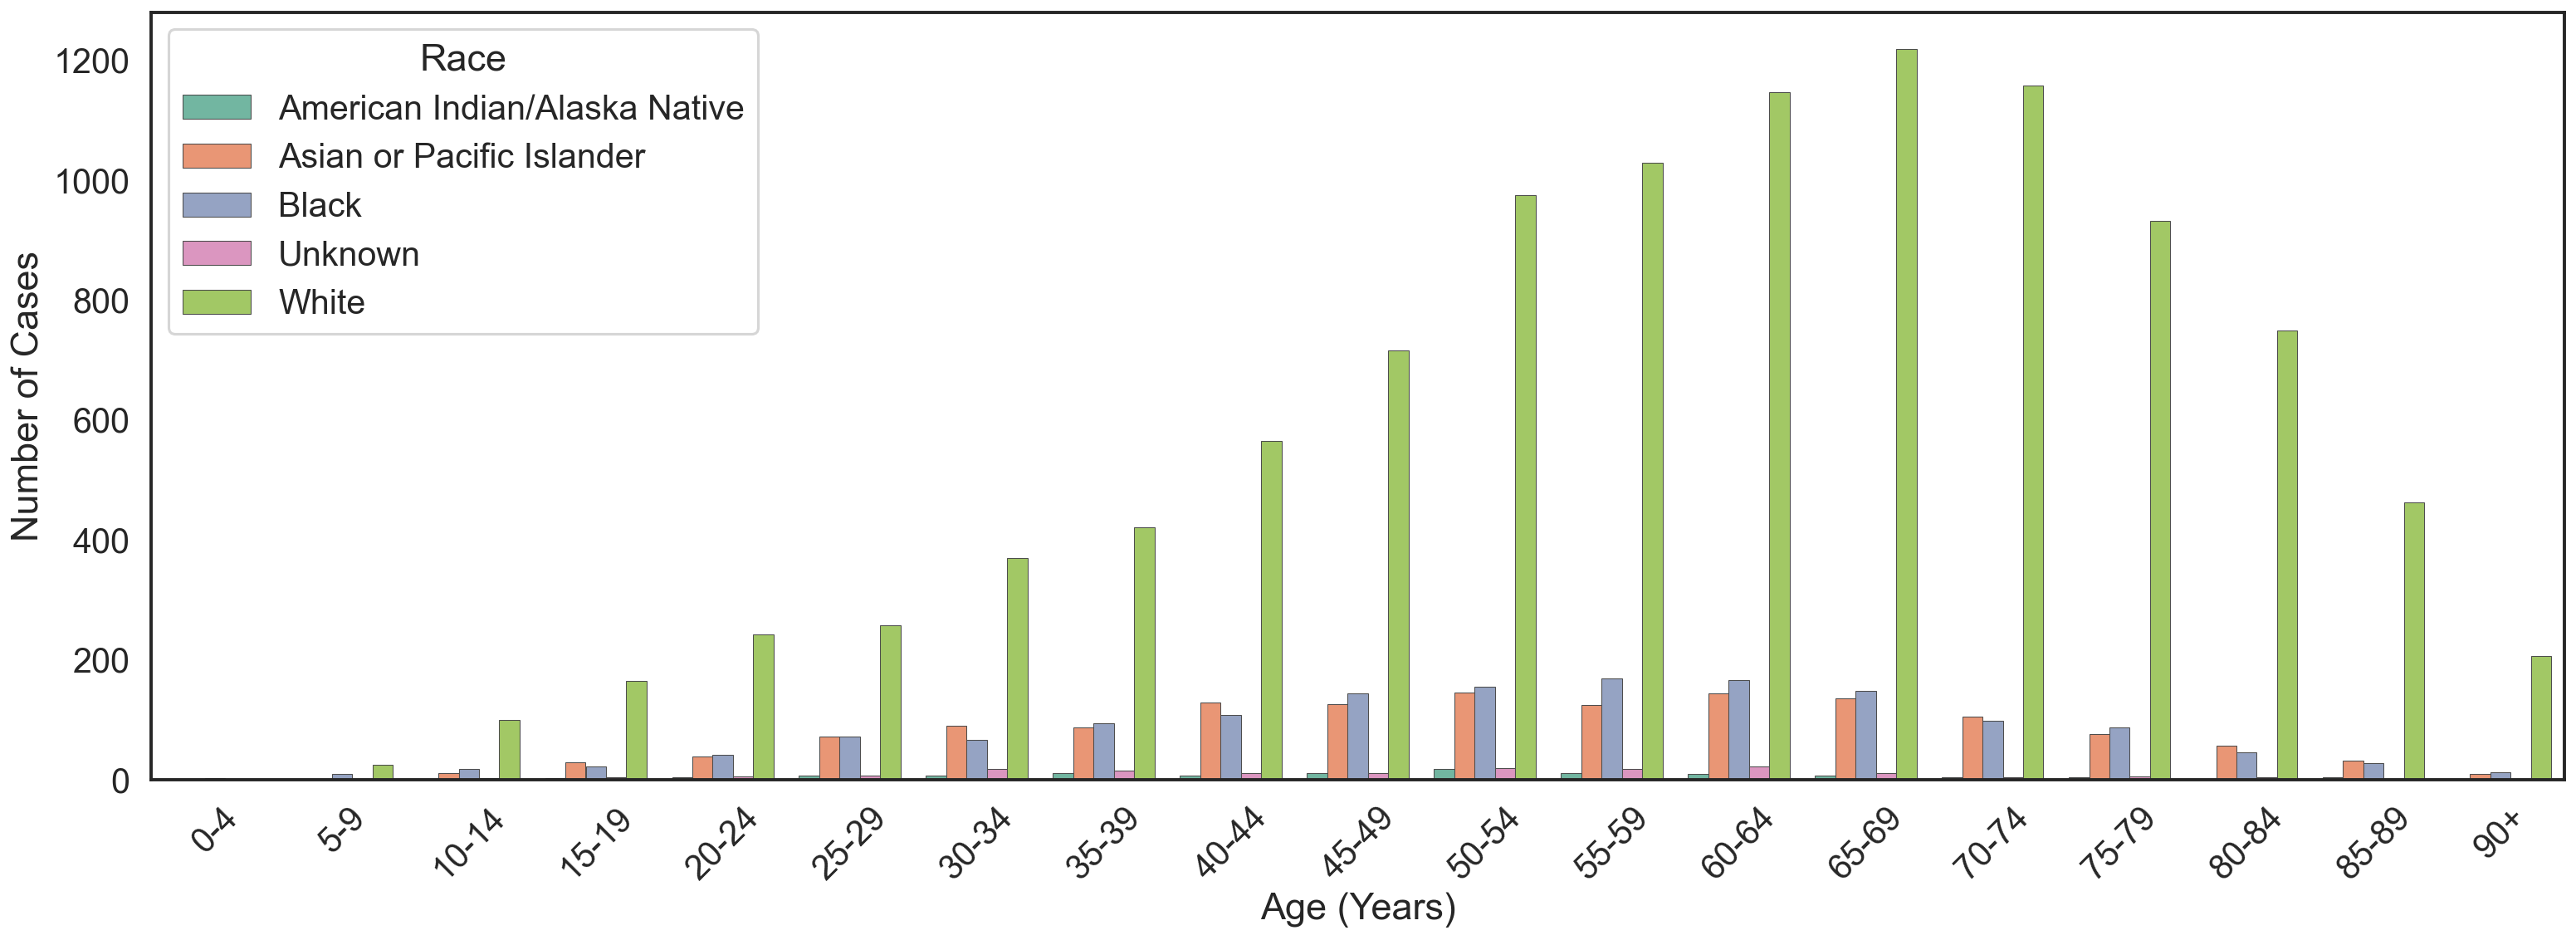

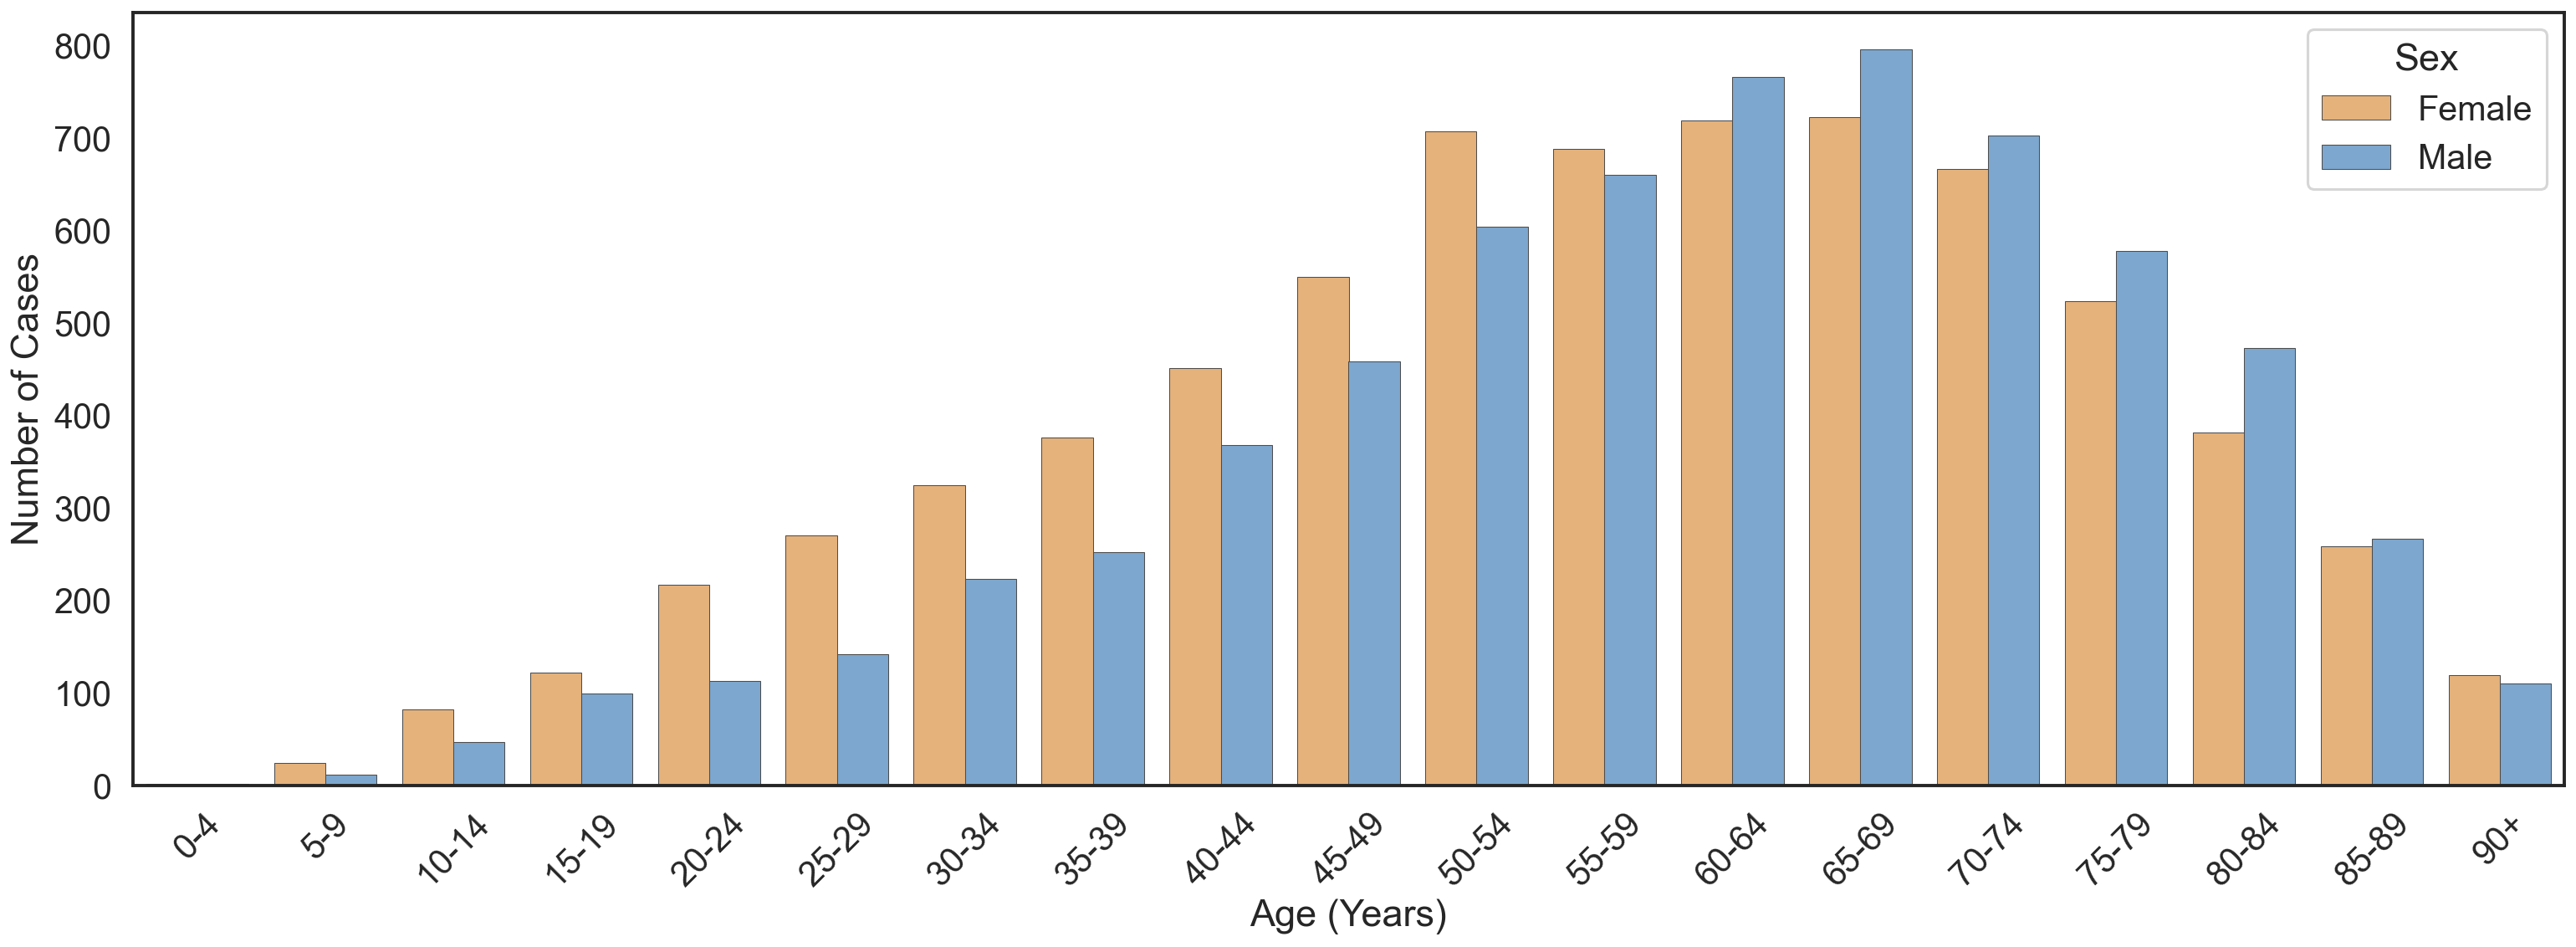

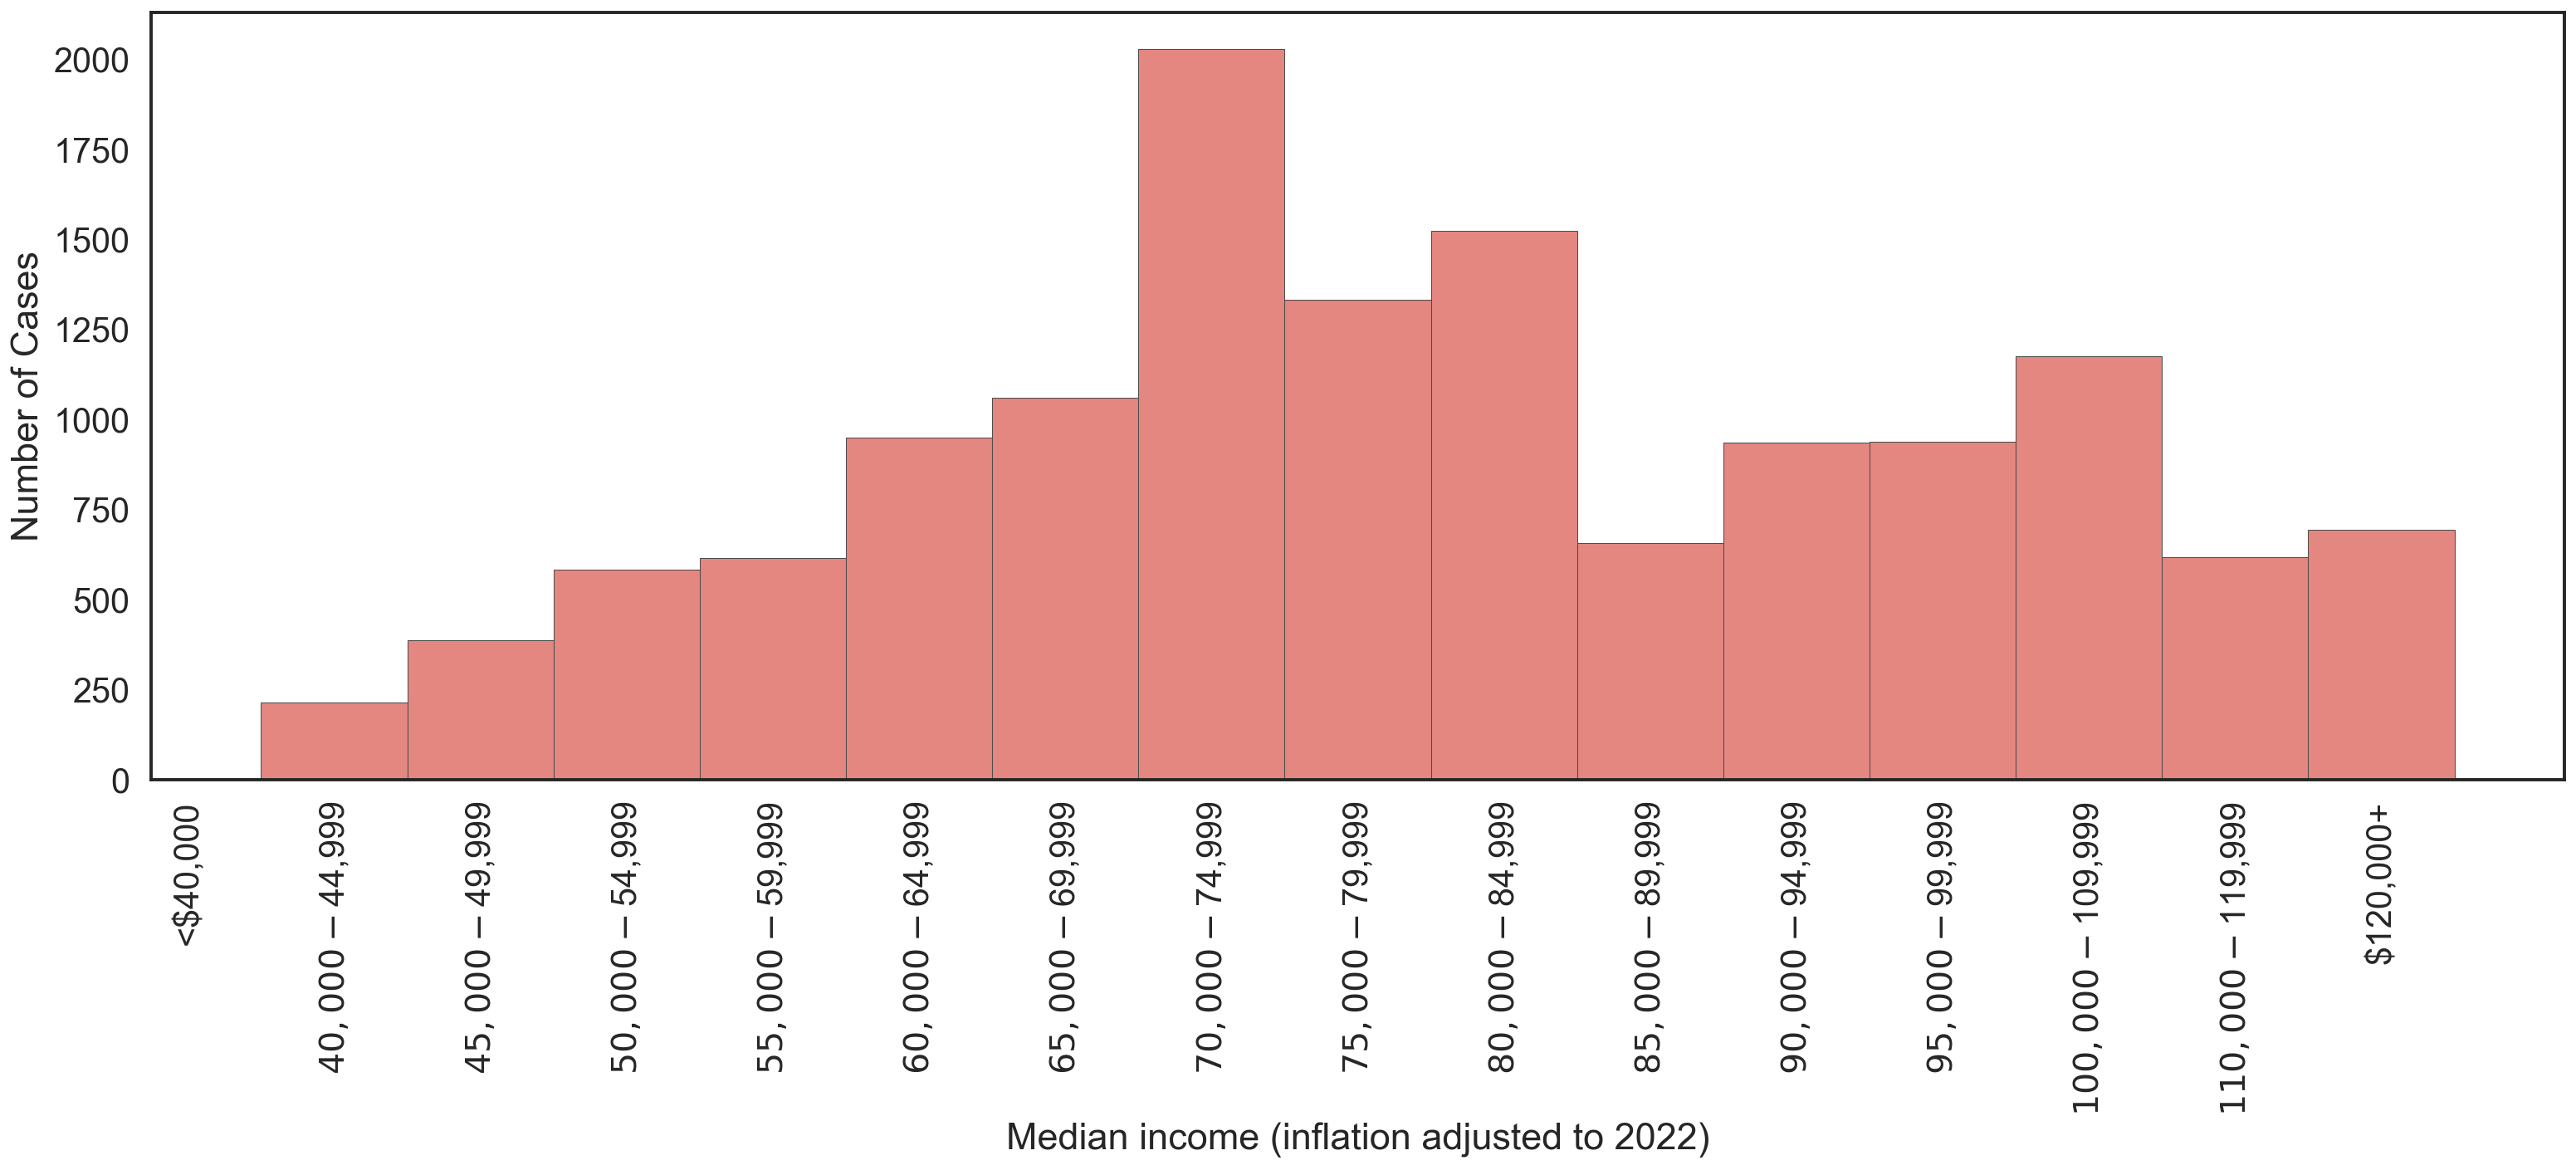

In [7]:
sns.set_style('white')
sns.set_context('talk',font_scale=1.2)
sns.set_palette('hls')


# Race vs. Age
plt.figure(figsize=(25, 8))
racevage_histplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=race_colname,
    palette=race_colorpalette,
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)
x_labels = racevage_histplot.get_xticklabels()

# Rotate x tick labels
racevage_histplot.set_xticklabels(x_labels, rotation=45)

racevage_histplot.set_xlabel('Age (Years)')
racevage_histplot.set_ylabel('Number of Cases')
racevage_histplot.legend(title='Race')
# Save the Race vs. Age plot
plt.savefig('race_vs_age_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Sex vs. Age
plt.figure(figsize=(25, 8))
sexvage_countplot = sns.countplot(
    data=filtered_df,
    x=age_bin_colname,
    hue=sex_colname,
    palette=sex_colorpalette,
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

# Rotate x tick labels
x_labels = sexvage_countplot.get_xticklabels()
sexvage_countplot.set_xticklabels(x_labels, rotation=45)
# sexvage_countplot.set_xticklabels(x_labels,rotation=90)
sexvage_countplot.set_xlabel('Age (Years)')
sexvage_countplot.set_ylabel('Number of Cases')

# Save the Sex vs. Age plot
plt.savefig('sex_vs_age_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.figure(figsize=(25, 8))
ses_countplot = sns.histplot(
    data=filtered_df,
    x=ses_colname,
    palette='hls',
    linewidth=0.5,
    edgecolor=".3",
    log_scale=False
)

ses_countplot.set_xticklabels(ses_countplot.get_xticklabels(),rotation=90)
ses_countplot.set_xlabel('Median income (inflation adjusted to 2022)')
ses_countplot.set_ylabel('Number of Cases')

# Save the SES histogram
plt.savefig('ses_countplot.pdf', format='pdf',dpi=300, bbox_inches='tight')

## Race vs Age: Violin Plot

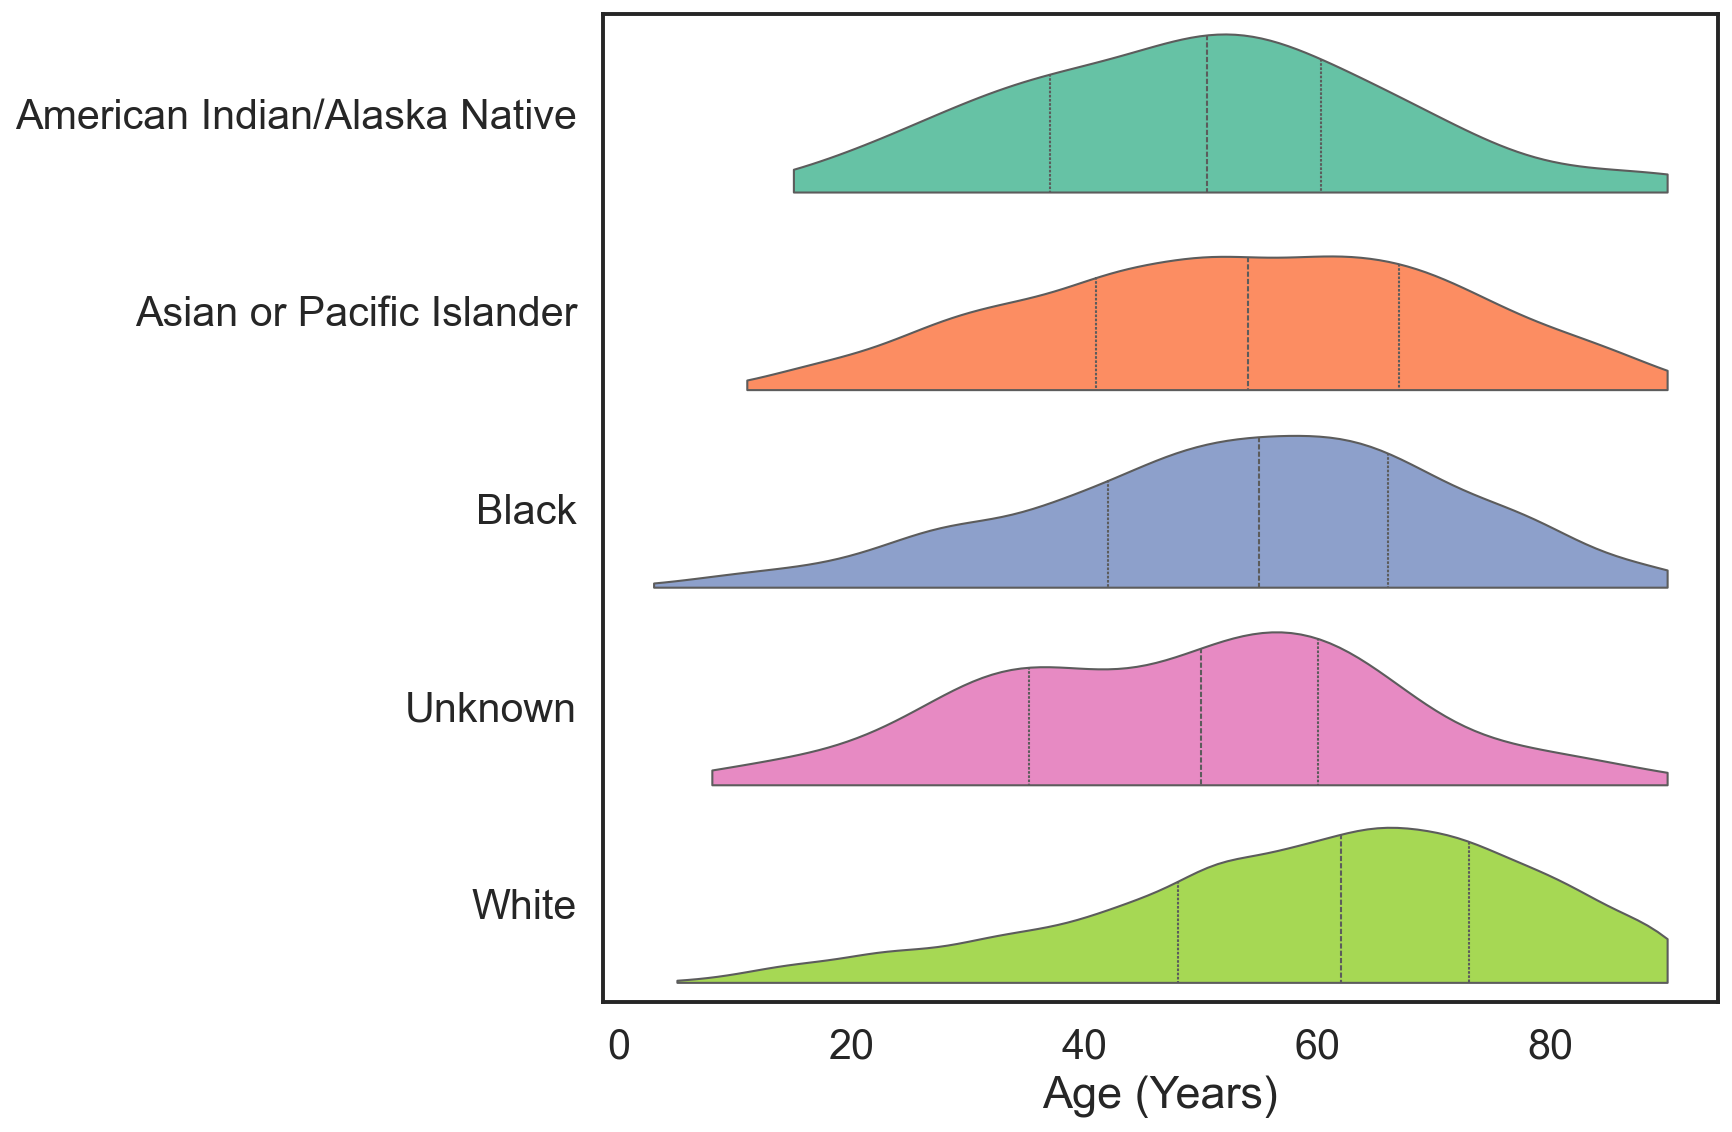

In [8]:
sns.set_style('white')
sns.set_context('talk',font_scale=1.2)


plt.figure(figsize=(12, 8))
filtered_df['dummy_hue'] = 1 # add a dummy hue for splitting the data.
all_races = filtered_df[race_colname].unique()

raceColorDict = {race: color for race, color in zip(all_races, race_colorpalette)}

# race_palette = {
#     'Race1': '#1f77b4',  # Replace with actual race names and desired colors
#     'Race2': '#ff7f0e',
#     'Race3': '#2ca02c',
#     # Add more races and colors as needed
# }


# Create a full violin plot
violin = sns.violinplot(
    data=filtered_df,
    x='Numerical_Age',
    y=race_colname,
    linewidth=1,
    inner="quartile",
    cut=0,
    split=True,
    hue='dummy_hue',
    legend=None
)

# Manually set the colors for each violin
for i, artist in enumerate(violin.findobj(mplcol.PolyCollection)):
    artist.set_facecolor(raceColorDict[filtered_df[race_colname].unique()[i]])

# Customize the plot
plt.xlabel('Age (Years)')
plt.ylabel('')
# plt.title()

plt.tight_layout()
plt.savefig('figure2_violinplot_agerace.pdf',format='pdf',dpi=300, bbox_inches='tight')
plt.show()


# Socioeconomic Status Heatmap

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/689378016.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)


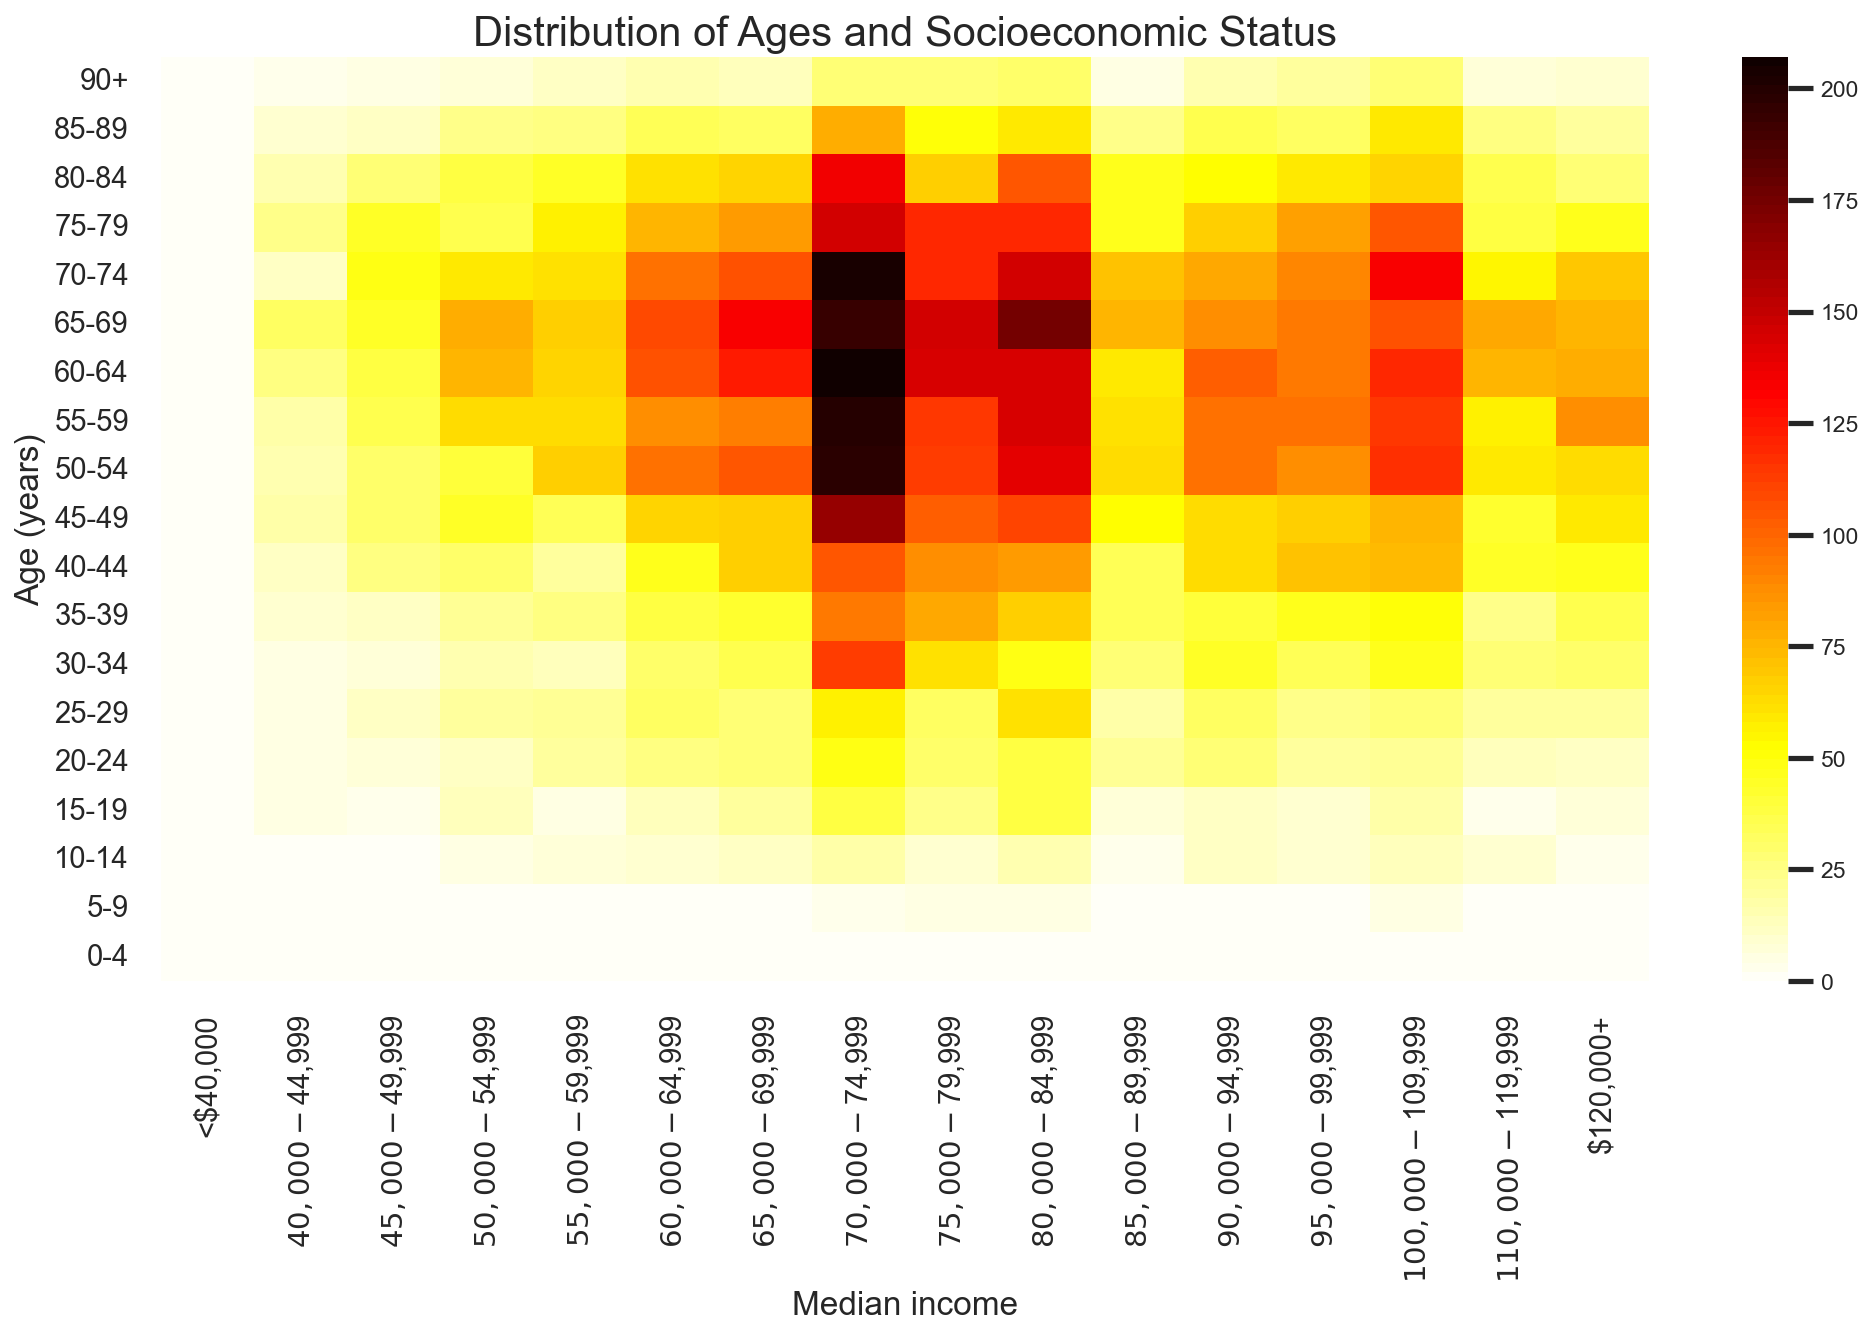

In [9]:
# Heatmap of age and socioeconomic
sns.set_context('poster',font_scale=.5)
# Create a pivot table that calculates the count of occurrences for each age and SES combination
# 
heatmap_data = filtered_df.pivot_table(index=age_bin_colname, columns=ses_colname, aggfunc='size', fill_value=0)

# Generate the RdYlGn palette with a specific number of colors
palette = sns.color_palette("hot_r",n_colors=100)
# Remove the darkest green, which is typically the last color in the RdYlGn palette
# You can adjust the indices depending on which colors you want to remove
# modified_palette = palette[:-1]  # This removes the last color

# Convert the modified list of colors to a colormap
cmap = sns.color_palette(palette, as_cmap=True)

# Set the figure size before creating the heatmap
plt.figure(figsize=(16, 8))  # Adjust width and height as needed

# Create the heatmap
ses_heat = sns.heatmap(heatmap_data, cmap=cmap, annot=False, fmt='d')
ses_heat.invert_yaxis()
title_fs = 20
plt.title('Distribution of Ages and Socioeconomic Status', fontsize=title_fs)
plt.xlabel('Median income', fontsize=title_fs*0.8)
plt.ylabel('Age (years)', fontsize=title_fs*0.8)
plt.xticks(fontsize=title_fs*0.7)
plt.yticks(fontsize=title_fs*0.7)

# Save the SES Heatmap
plt.savefig('ses_heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')


# Determine Histological Characterization + Order

In [10]:
# Histology order - Manually Defined and dependent on each dataset
histology_order = ['Adenocarcinoma','Adenoid Cystic Carcinoma','Mucoepidermoid Carcinoma','Other Rare Types','Mixed Subtypes']

# Categorize Histology column based on pre-ordained order
filtered_df['Histology'] = pd.Categorical(filtered_df['Histology'],categories=histology_order, ordered=True)

# For plotting FacetGrid determine the top N types
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order # top cancers

# Pick top N cancers for plotting
N = 3
topCancerTypes = ordered_labels[0:N]
print(topCancerTypes)
filtered_df_forFacetGrid = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]

filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()

# Color Set Up
colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors

histColorDict = dict(zip(histology_order,colors))
topNColorDict = dict(zip(topCancerTypes,colors[0:N]))


['Adenocarcinoma', 'Adenoid Cystic Carcinoma', 'Mucoepidermoid Carcinoma']


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/773462936.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forFacetGrid['Histology'] = filtered_df_forFacetGrid['Histology'].cat.remove_unused_categories()


## Distribution by Age & Pie Plot

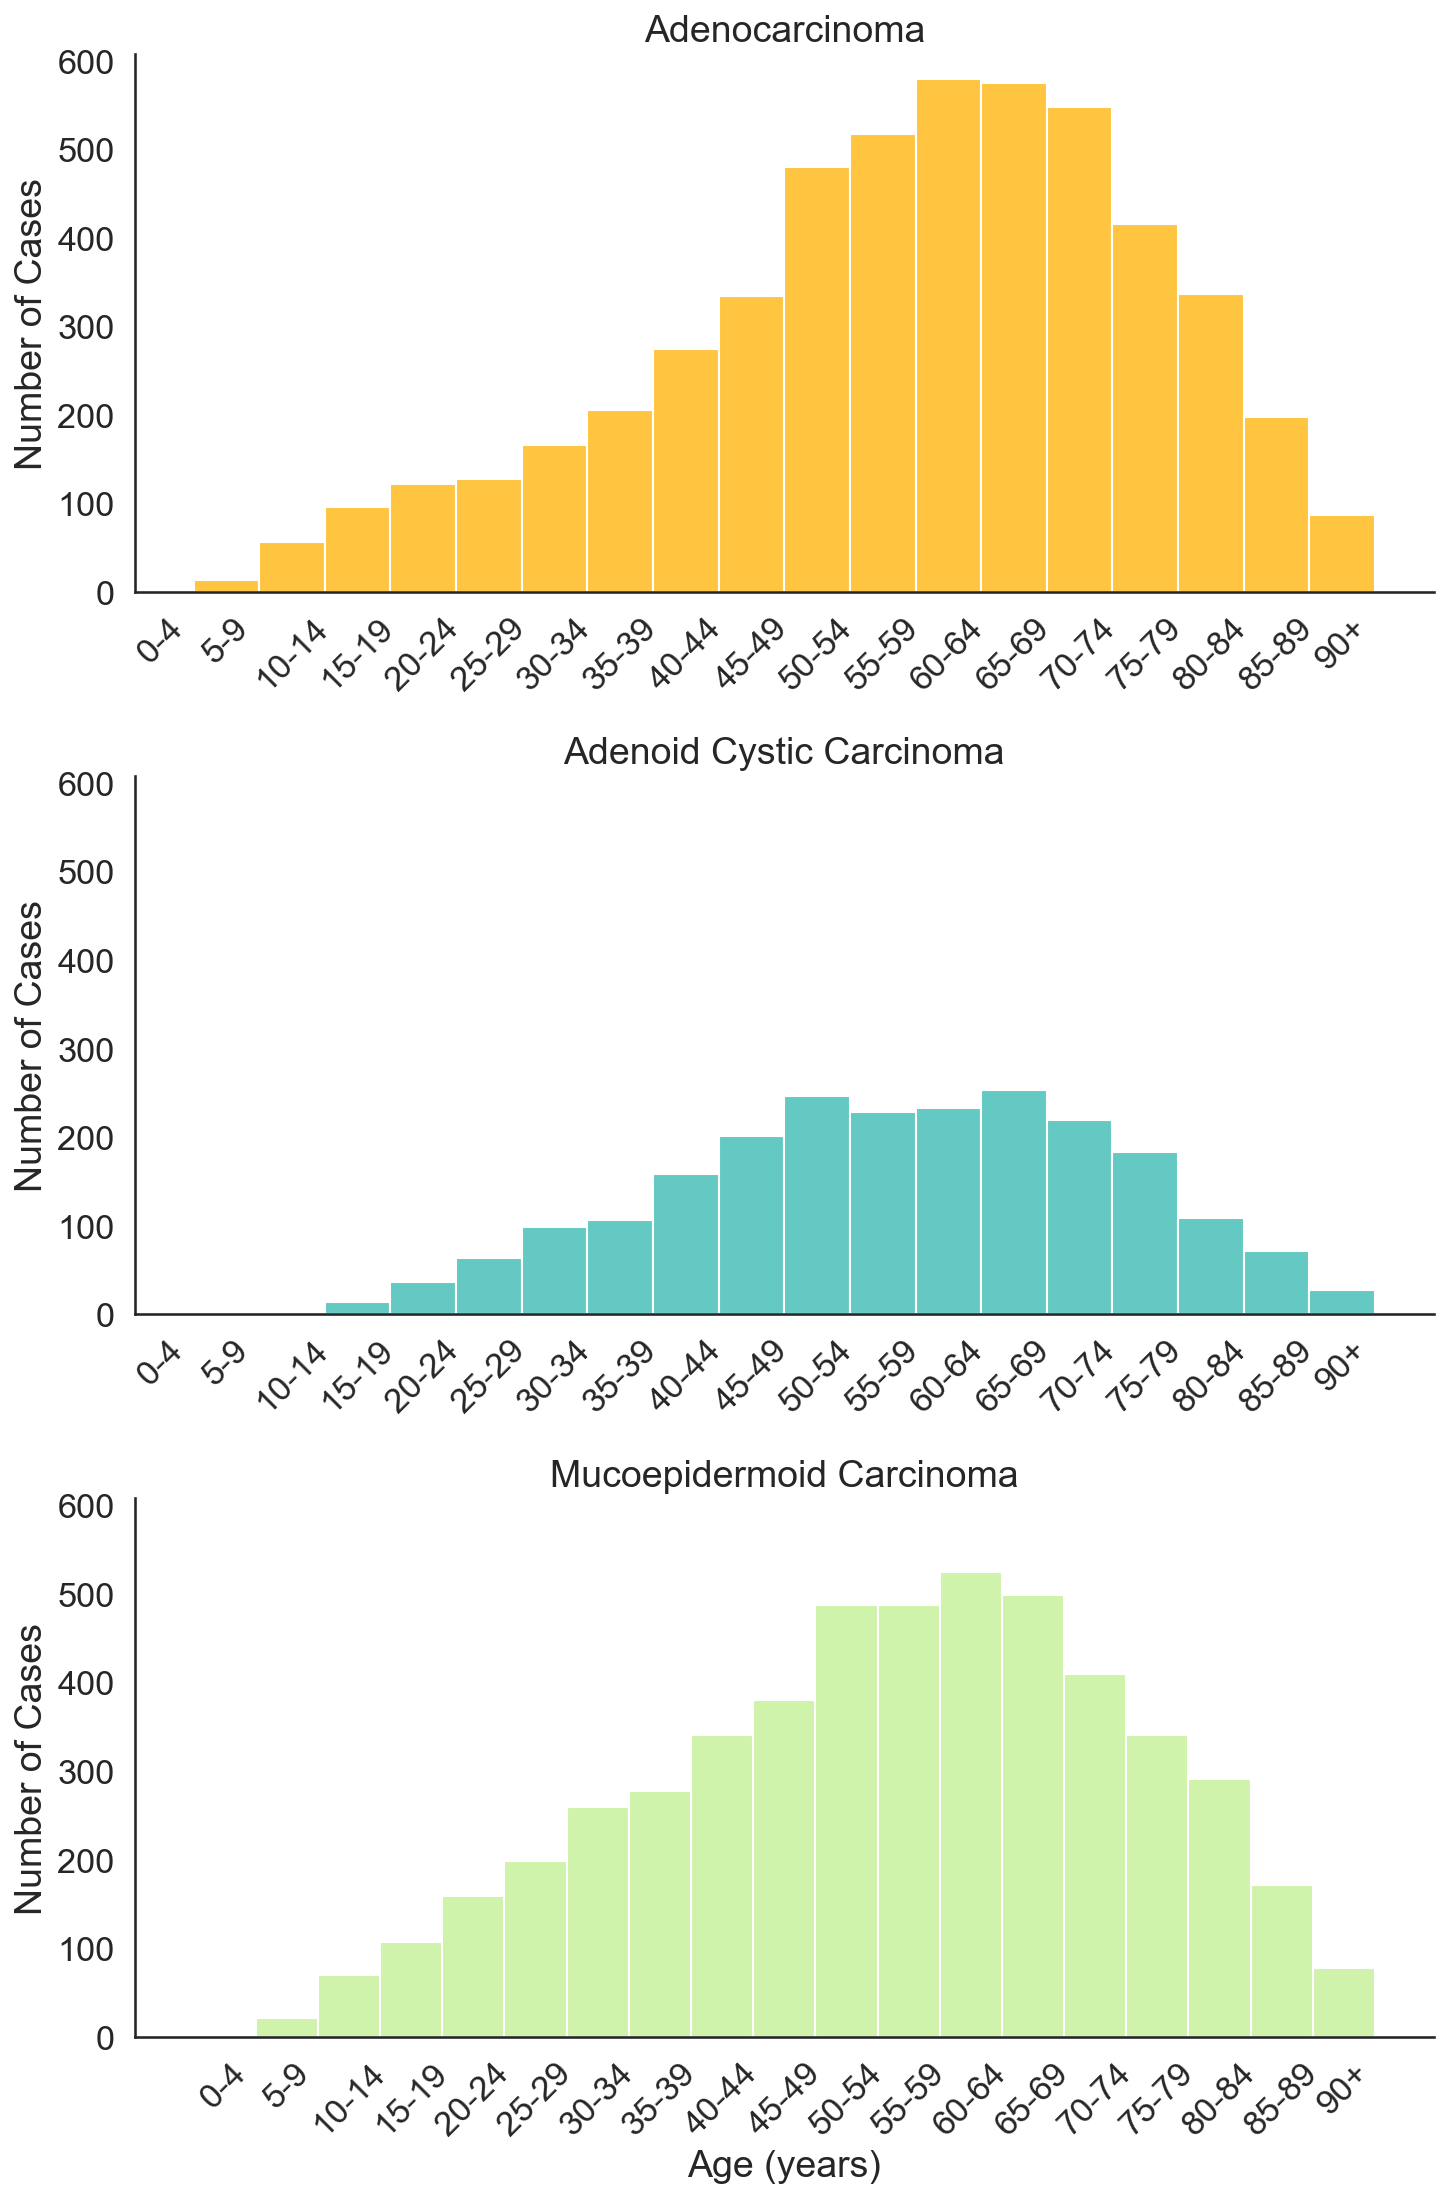

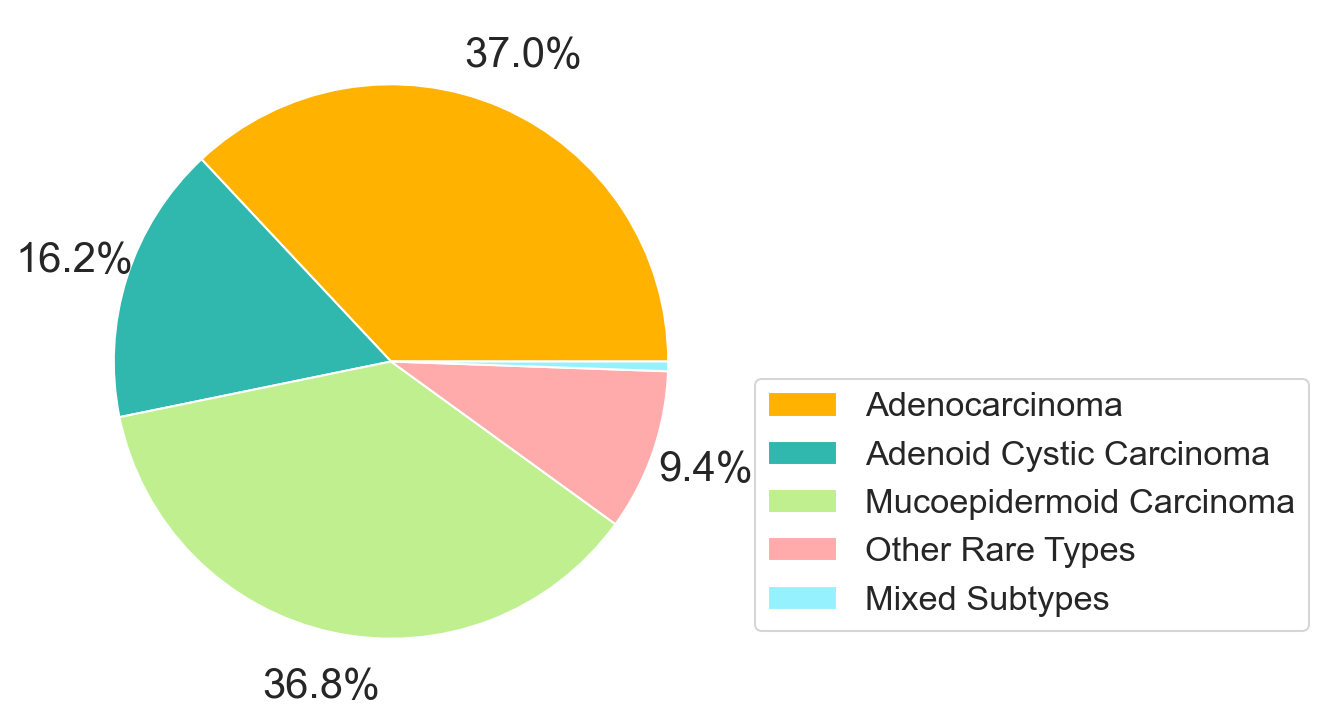

In [11]:
# Set the context for better visibility
sns.set_context("notebook", font_scale=1.5)

# Create a FacetGrid instead of using displot
g = sns.FacetGrid(filtered_df_forFacetGrid, col="Histology", col_wrap=1, height=5, aspect=2, sharex=False)
g.map_dataframe(sns.histplot, x=age_bin_colname, binwidth=1, hue='Histology', palette=topNColorDict, multiple='stack')

# Rotate the x-tick labels in each facet
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set labels and titles
g.set_xlabels('Age (years)')
g.set_ylabels('Number of Cases')
g.set_titles(col_template="{col_name}")

# Set layout
plt.tight_layout()

# Save the Histology histograms
plt.savefig('histology_histograms.pdf', format='pdf',dpi=300, bbox_inches='tight')

plt.show()



# Calculate tumor site counts
tumor_type_counts = filtered_df['Histology'].value_counts(normalize=True)
ordered_counts = tumor_type_counts[histology_order]
ordered_labels = histology_order

labels = tumor_type_counts.index

# Create pie chart
plt.figure(figsize=(8, 6))
# Explicit colors definition:
colors_for_pie = [histColorDict[label] for label in ordered_labels if label in histColorDict]
# Define a function as an input to autopct:
def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct >= 1 else ''

# Create the pie chart with specified font sizes
patches, texts, autotexts = plt.pie(
    ordered_counts, labels=None, autopct=autopct_format,
    pctdistance=1.2, colors=colors_for_pie
)

# Adjust the font size for the pie chart
for text in texts:
    text.set_fontsize(16)
for autotext in autotexts:
    autotext.set_fontsize(20)

# Add legend
plt.legend(patches, ordered_labels, loc='best', bbox_to_anchor=(1, 0.5))

# Save the histology pie plot
plt.savefig('histology_pie.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## Cancer Types and Year of Diagnosis

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/1309339049.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()


index  Year of diagnosis  Total Counts
0      16               2000           579
1      21               2001           517
2      19               2002           538
3      20               2003           518
4      14               2004           593
5      18               2005           572
6      13               2006           628
7      17               2007           573
8       7               2008           657
9      15               2009           588
10     12               2010           635
11      8               2011           655
12      6               2012           662
13      9               2013           652
14     11               2014           641
15      3               2015           695
16      5               2016           684
17      2               2017           695
18      0               2018           731
19      4               2019           690
20     10               2020           650
21      1               2021           716

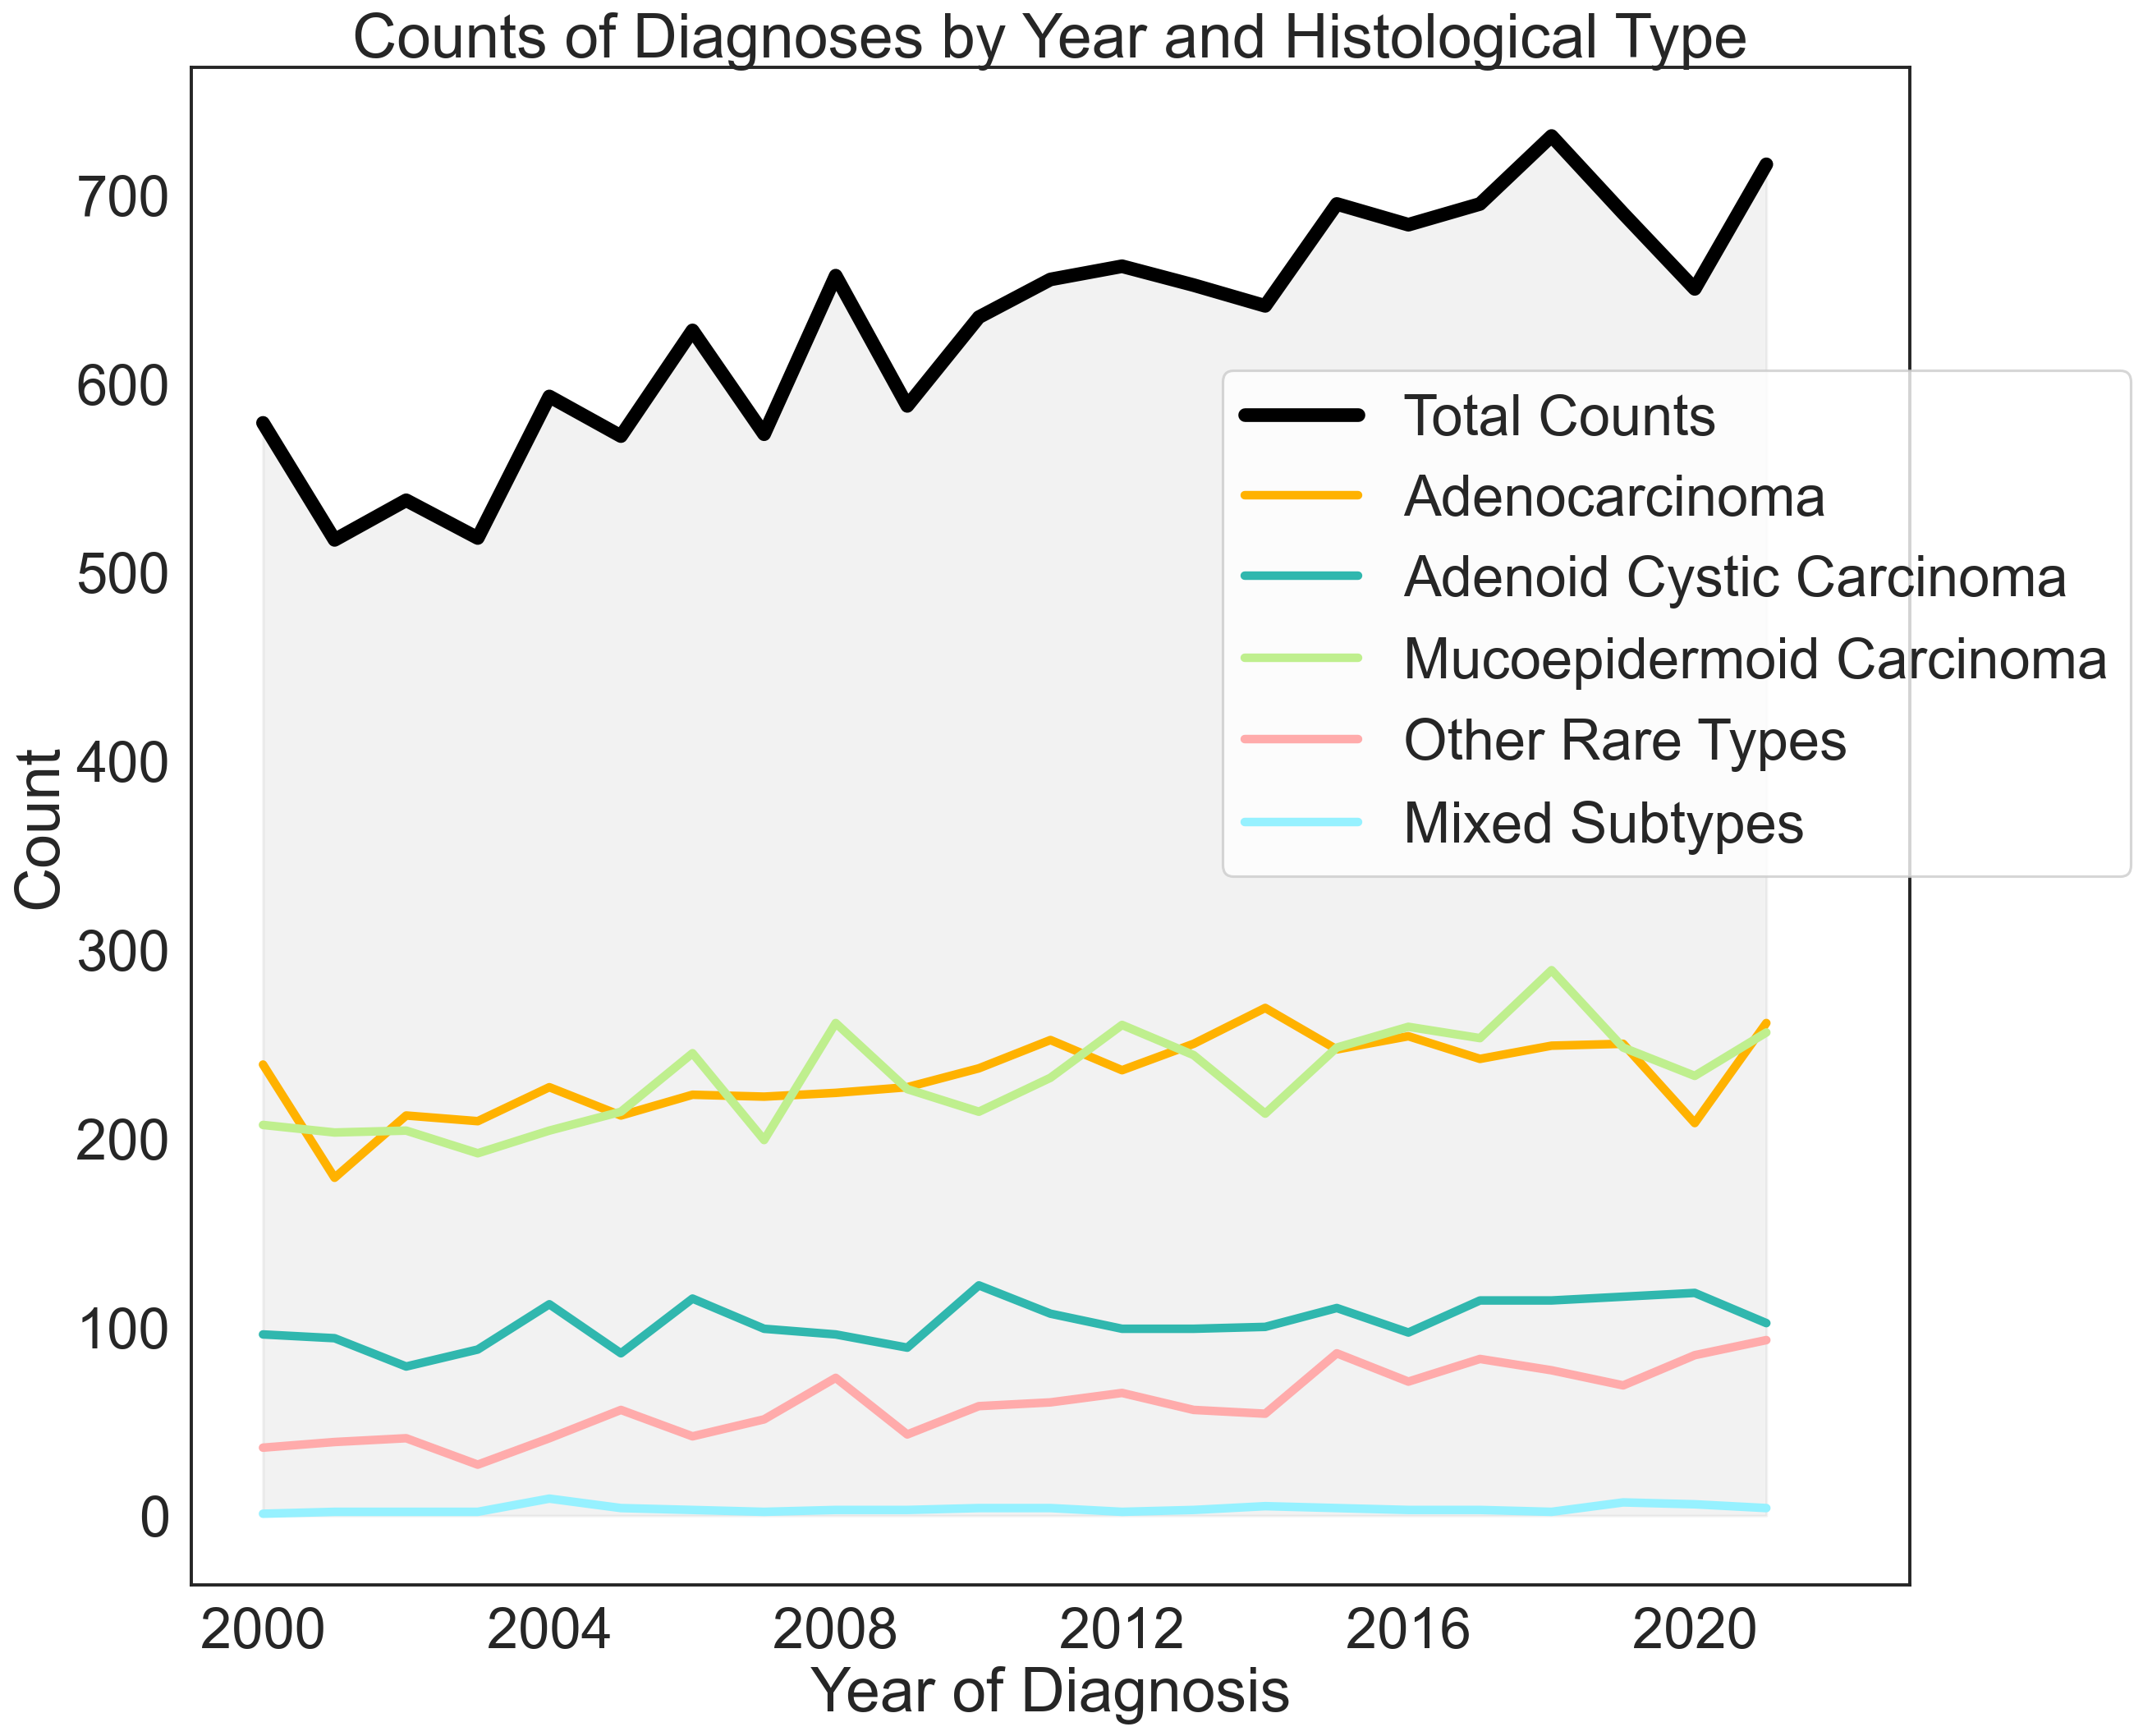

In [12]:
# Calculate counts per year per histological type.
type_year_counts = filtered_df.groupby('Histology')['Year of diagnosis'].value_counts()
type_year_counts_df = type_year_counts.reset_index(name='Counts')
# print(type_year_counts)
# Calculate the counts per year for the bar plot
year_counts = filtered_df['Year of diagnosis'].value_counts()
# Convert the Series to a DataFrame
year_counts_df = year_counts.reset_index()
year_counts_df.columns = ['Year of diagnosis', 'Total Counts']

# Ensure 'Year of diagnosis' is treated as an integer
year_counts_df['Year of diagnosis'] = year_counts_df['Year of diagnosis'].astype(int)
type_year_counts_df['Year of diagnosis'] = type_year_counts_df['Year of diagnosis'].astype(int)

# Sort both dataframes by 'Year of diagnosis' to ensure proper plotting order
year_counts_df = year_counts_df.sort_values('Year of diagnosis').reset_index()
type_year_counts_df = type_year_counts_df.sort_values('Year of diagnosis')

# Display for verification
display(year_counts_df)

# Create plot and aesthetics
plt.figure(figsize=(18,16))
sns.set_context('talk', font_scale=2)

# Create the bar plot in the background for total counts per year
# sns.lineplot(year_counts_df,x='Year of diagnosis',y='Total Counts',
#              color=(0,0,0),lw=8,zorder=1,label='Total Count')
# Create the line plot for total counts per year
# We're using plt.plot instead of sns.lineplot to have more control over shading
plt.plot(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
         color='black', label='Total Counts', lw=8)

# Fill the area under the line with a shaded color
plt.fill_between(year_counts_df['Year of diagnosis'], year_counts_df['Total Counts'],
                 color='grey', alpha=0.1)

# Create line plot for each individual histological type
sns.lineplot(type_year_counts_df,x='Year of diagnosis',y='Counts',
             palette=colors,hue='Histology',lw=5,zorder=2)

# Adjust the x value limits
plt.xlim(1999,2023)
plt.xticks(range(2000,2022,4))
plt.grid(False, axis='y')
# Adjust legend position and add 'Total Counts' to the legend
plt.legend(bbox_to_anchor=(.6, .8), loc='upper left', borderaxespad=0)

# Add labels and title
plt.xlabel('Year of Diagnosis')
plt.ylabel('Count')
plt.title('Counts of Diagnoses by Year and Histological Type')

plt.savefig('counts_vs_year.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
year_counts_df = year_counts_df.reset_index(drop=True)

# Calculate year over year increase
year_counts_df['YoY_Change'] = year_counts_df['Total Counts'].diff()  # Absolute change
year_counts_df['YoY_Percentage'] = year_counts_df['Total Counts'].pct_change() * 100  # Percentage change

display(year_counts_df)
print(year_counts_df['YoY_Percentage'].mean())
print(year_counts_df['YoY_Percentage'].std())


year_counts_df.loc[21,'Total Counts']/year_counts_df.loc[0,'Total Counts']

index  Year of diagnosis  Total Counts  YoY_Change  YoY_Percentage
0      16               2000           579         NaN             NaN
1      21               2001           517       -62.0      -10.708117
2      19               2002           538        21.0        4.061896
3      20               2003           518       -20.0       -3.717472
4      14               2004           593        75.0       14.478764
5      18               2005           572       -21.0       -3.541315
6      13               2006           628        56.0        9.790210
7      17               2007           573       -55.0       -8.757962
8       7               2008           657        84.0       14.659686
9      15               2009           588       -69.0      -10.502283
10     12               2010           635        47.0        7.993197
11      8               2011           655        20.0        3.149606
12      6               2012           662         7.0        1.068702
13      9               2013           652       -10.0       -1.510574
14     11               2014           641       -11.0       -1.687117
15      3               2015           695        54.0        8.424337
16      5               2016           684       -11.0       -1.582734
17      2               2017           695        11.0        1.608187
18      0               2018           731        36.0        5.179856
19      4               2019           690       -41.0       -5.608755
20     10               2020           650       -40.0       -5.797101
21      1               2021           716        66.0       10.153846

1.2930884360725823
7.684194976702879


1.2366148531951642

# Age, Race, and Sex Proportions & Distributions

## Useful General Calculations

In [14]:
# display(filtered_df[race_colname].value_counts())
filtered_df_over18 = filtered_df[filtered_df['Numerical_Age'] >= 18]
mean_age = filtered_df['Numerical_Age'].mean()
std_age = filtered_df['Numerical_Age'].std()
median_age = filtered_df['Numerical_Age'].median()

print(f'Mean: {mean_age: .2f} ± {std_age: .2f}\nMedian:{median_age: .0f}')


mean_age = filtered_df_over18['Numerical_Age'].mean()
std_age = filtered_df_over18['Numerical_Age'].std()
median_age = filtered_df_over18['Numerical_Age'].median()

print(f'Mean: {mean_age: .2f} ± {std_age: .2f}\nMedian:{median_age: .0f}')

# Group by Marital Status; calculate mean age

marital_status_grouping = filtered_df.groupby([marital_colname,sex_colname],observed=True)
age_by_marital = marital_status_grouping[['Numerical_Age']].agg(['mean','std','sem','median'])
age_by_marital.to_excel('age_by_marital.xlsx')
display(age_by_marital)

Mean:  58.03 ±  18.14
Median: 60
Mean:  59.03 ±  17.05
Median: 60


Numerical_Age                            
                                            mean        std       sem median
Marital status at diagnosis Sex                                             
Married                     Female     56.175547  15.203547  0.254598   57.0
                            Male       62.322495  14.847942  0.230429   64.0
Single                      Female     42.656697  20.691569  0.527613   42.0
                            Male       46.222222  19.945433  0.561899   48.0
Divorced/Separated          Female     60.559671  13.124282  0.486085   61.0
                            Male       60.624481  12.890635  0.587152   60.5
Widowed                     Female     76.399108  10.290595  0.343593   78.0
                            Male       77.603352  10.014230  0.529269   80.0
Domestic Partner            Female     47.950000  12.563418  2.809266   46.5
                            Male       51.125000  16.744651  4.186163   54.5
Unknown                     Female     58.680000  16.949547  0.799009   59.5
                            Male       59.887781  16.907539  0.844322   62.0

## Generate Excel files

In [15]:
# Everyone!
# Calculate counts (value_counts with normalized=False) and sort (sort_index())
colsForTables = [age_bin_colname,sex_colname,race_colname,ses_colname,'Income Tertile','Histology',marital_colname,site_colname,'Grade Label','Grade Level']
# Create an Excel writer object and specify the file path
output_file_path = 'merged_tables.xlsx'
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for col in colsForTables:
        counts = (filtered_df[col].
                  value_counts(normalize=False).
                  sort_index())

        # Calculate proportions (normalized=True), sort (sort_index()), convert to indices
        proportions = (filtered_df[col].
                       value_counts(normalize=True).
                       sort_index())

        # Merge the counts and proportions into one table
        merged_table = pd.DataFrame({'Counts': counts, 'Proportions': proportions})
        print(merged_table)
        # Write each DataFrame to a different sheet
        merged_table.to_excel(writer, sheet_name=col[:30])

        # Create a pivot table for counts
        counts_table = filtered_df.pivot_table(
            index=col,      # Rows (e.g., Age)
            columns='Sex',        # Columns (e.g., Histology categories)
            aggfunc='size',            # Aggregation function (count in this case)
            fill_value=0                # Fill missing values with 0
        )

        counts_table.to_excel(writer, sheet_name=col[:20]+'_wide')

print(f"Merged tables exported to {output_file_path}")

# Adults only
# Calculate counts (value_counts with normalized=False) and sort (sort_index())
colsForTables = [age_bin_colname,sex_colname,race_colname,ses_colname,'Income Tertile','Histology',marital_colname,site_colname,'Grade Label','Grade Level']
# Create an Excel writer object and specify the file path
output_file_path = 'merged_tables_adults.xlsx'
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for col in colsForTables:
        counts = (filtered_df_over18[col].
                  value_counts(normalize=False).
                  sort_index())

        # Calculate proportions (normalized=True), sort (sort_index()), convert to indices
        proportions = (filtered_df_over18[col].
                       value_counts(normalize=True).
                       sort_index())

        # Merge the counts and proportions into one table
        merged_table = pd.DataFrame({'Counts': counts, 'Proportions': proportions})
        print(merged_table)
        # Write each DataFrame to a different sheet
        merged_table.to_excel(writer, sheet_name=col[:30])

        # Create a pivot table for counts
        counts_table = filtered_df_over18.pivot_table(
            index=col,      # Rows (e.g., Age)
            columns='Sex',        # Columns (e.g., Histology categories)
            aggfunc='size',            # Aggregation function (count in this case)
            fill_value=0                # Fill missing values with 0
        )

        counts_table.to_excel(writer, sheet_name=col[:20]+'_wide')

print(f"Merged tables exported to {output_file_path}")





            Counts  Proportions
Age_Binned                     
0-4              2     0.000144
5-9             35     0.002524
10-14          129     0.009301
15-19          221     0.015935
20-24          330     0.023794
25-29          412     0.029707
30-34          547     0.039440
35-39          628     0.045281
40-44          819     0.059053
45-49         1008     0.072680
50-54         1311     0.094527
55-59         1348     0.097195
60-64         1485     0.107073
65-69         1518     0.109453
70-74         1368     0.098637
75-79         1101     0.079386
80-84          854     0.061576
85-89          524     0.037782
90+            229     0.016512
        Counts  Proportions
Sex                        
Female    7200     0.519143
Male      6669     0.480857
                               Counts  Proportions
Race recode (W, B, AI, API)                       
American Indian/Alaska Native     100     0.007210
Asian or Pacific Islander        1401     0.101017
Black       

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/1068904738.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/1068904738.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/1068904738.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df.pivot_table(
/

Merged tables exported to merged_tables.xlsx
            Counts  Proportions
Age_Binned                     
0-4              0     0.000000
5-9              0     0.000000
10-14            0     0.000000
15-19           85     0.006265
20-24          330     0.024324
25-29          412     0.030368
30-34          547     0.040318
35-39          628     0.046289
40-44          819     0.060367
45-49         1008     0.074298
50-54         1311     0.096632
55-59         1348     0.099359
60-64         1485     0.109457
65-69         1518     0.111889
70-74         1368     0.100833
75-79         1101     0.081153
80-84          854     0.062947
85-89          524     0.038623
90+            229     0.016879
        Counts  Proportions
Sex                        
Female    7016     0.517137
Male      6551     0.482863
                               Counts  Proportions
Race recode (W, B, AI, API)                       
American Indian/Alaska Native      99     0.007297
Asian or Pacific I

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/1068904738.py:58: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df_over18.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/1068904738.py:58: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df_over18.pivot_table(
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/1068904738.py:58: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  counts_table = filtered_df_

Merged tables exported to merged_tables_adults.xlsx


In [16]:
# Initialize a list to store categories with proportions < 0.05
low_proportion_categories = {}

# Iterate over the columns and compute proportions
for col in colsForTables:
    # Calculate proportions
    proportions = (
        filtered_df[col]
        .value_counts(normalize=True)
        .sort_index()
    )

    # Find categories with proportions < 0.05
    low_proportion_categories[col] = proportions[proportions < 0.05].index.tolist()

# Output the low proportion categories
print(low_proportion_categories)

{'Age_Binned': ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '85-89', '90+'], 'Sex': [], 'Race recode (W, B, AI, API)': ['American Indian/Alaska Native', 'Unknown'], 'Median household income inflation adj to 2022': ['<$40,000', '$40,000 - $44,999', '$45,000 - $49,999', '$50,000 - $54,999', '$55,000 - $59,999', '$85,000 - $89,999', '$110,000 - $119,999'], 'Income Tertile': [], 'Histology': ['Mixed Subtypes'], 'Marital status at diagnosis': ['Domestic Partner'], 'Primary Site - labeled': ['Overlapping lesion of major salivary glands', 'Sublingual gland'], 'Grade Label': [], 'Grade Level': []}


# Survival Analysis

In [17]:
# Replace "Unknown" with nan's 
filtered_df['Survival months'] = filtered_df['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df['Survival months'] = pd.to_numeric(filtered_df['Survival months'])

filtered_df['event_occurred'] = filtered_df['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
    # else 2 if x == 'Dead (missing/unknown COD)'
    else 0)

filtered_df_over18['Survival months'] = filtered_df_over18['Survival months'].replace("Unknown", np.nan)
# Change to numeric
filtered_df_over18['Survival months'] = pd.to_numeric(filtered_df_over18['Survival months'])

filtered_df_over18['event_occurred'] = filtered_df_over18['Vital status recode (study cutoff used)'].apply(
    lambda x: 1 if x == 'Dead'
    # else 2 if x == 'Dead (missing/unknown COD)'
    else 0)

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3121096952.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_over18['Survival months'] = filtered_df_over18['Survival months'].replace("Unknown", np.nan)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3121096952.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_over18['Survival months'] = pd.to_numeric(filtered_df_over18['Survival months'])
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykern

## Overall Survival

Median Survival Time: 198.0 months
Survival Probability at 12 Months: 0.62
KM_estimate    0.624594
Name: 120.0, dtype: float64
KM_estimate_lower_0.95    0.612922
KM_estimate_upper_0.95    0.636025
Name: 120.0, dtype: float64


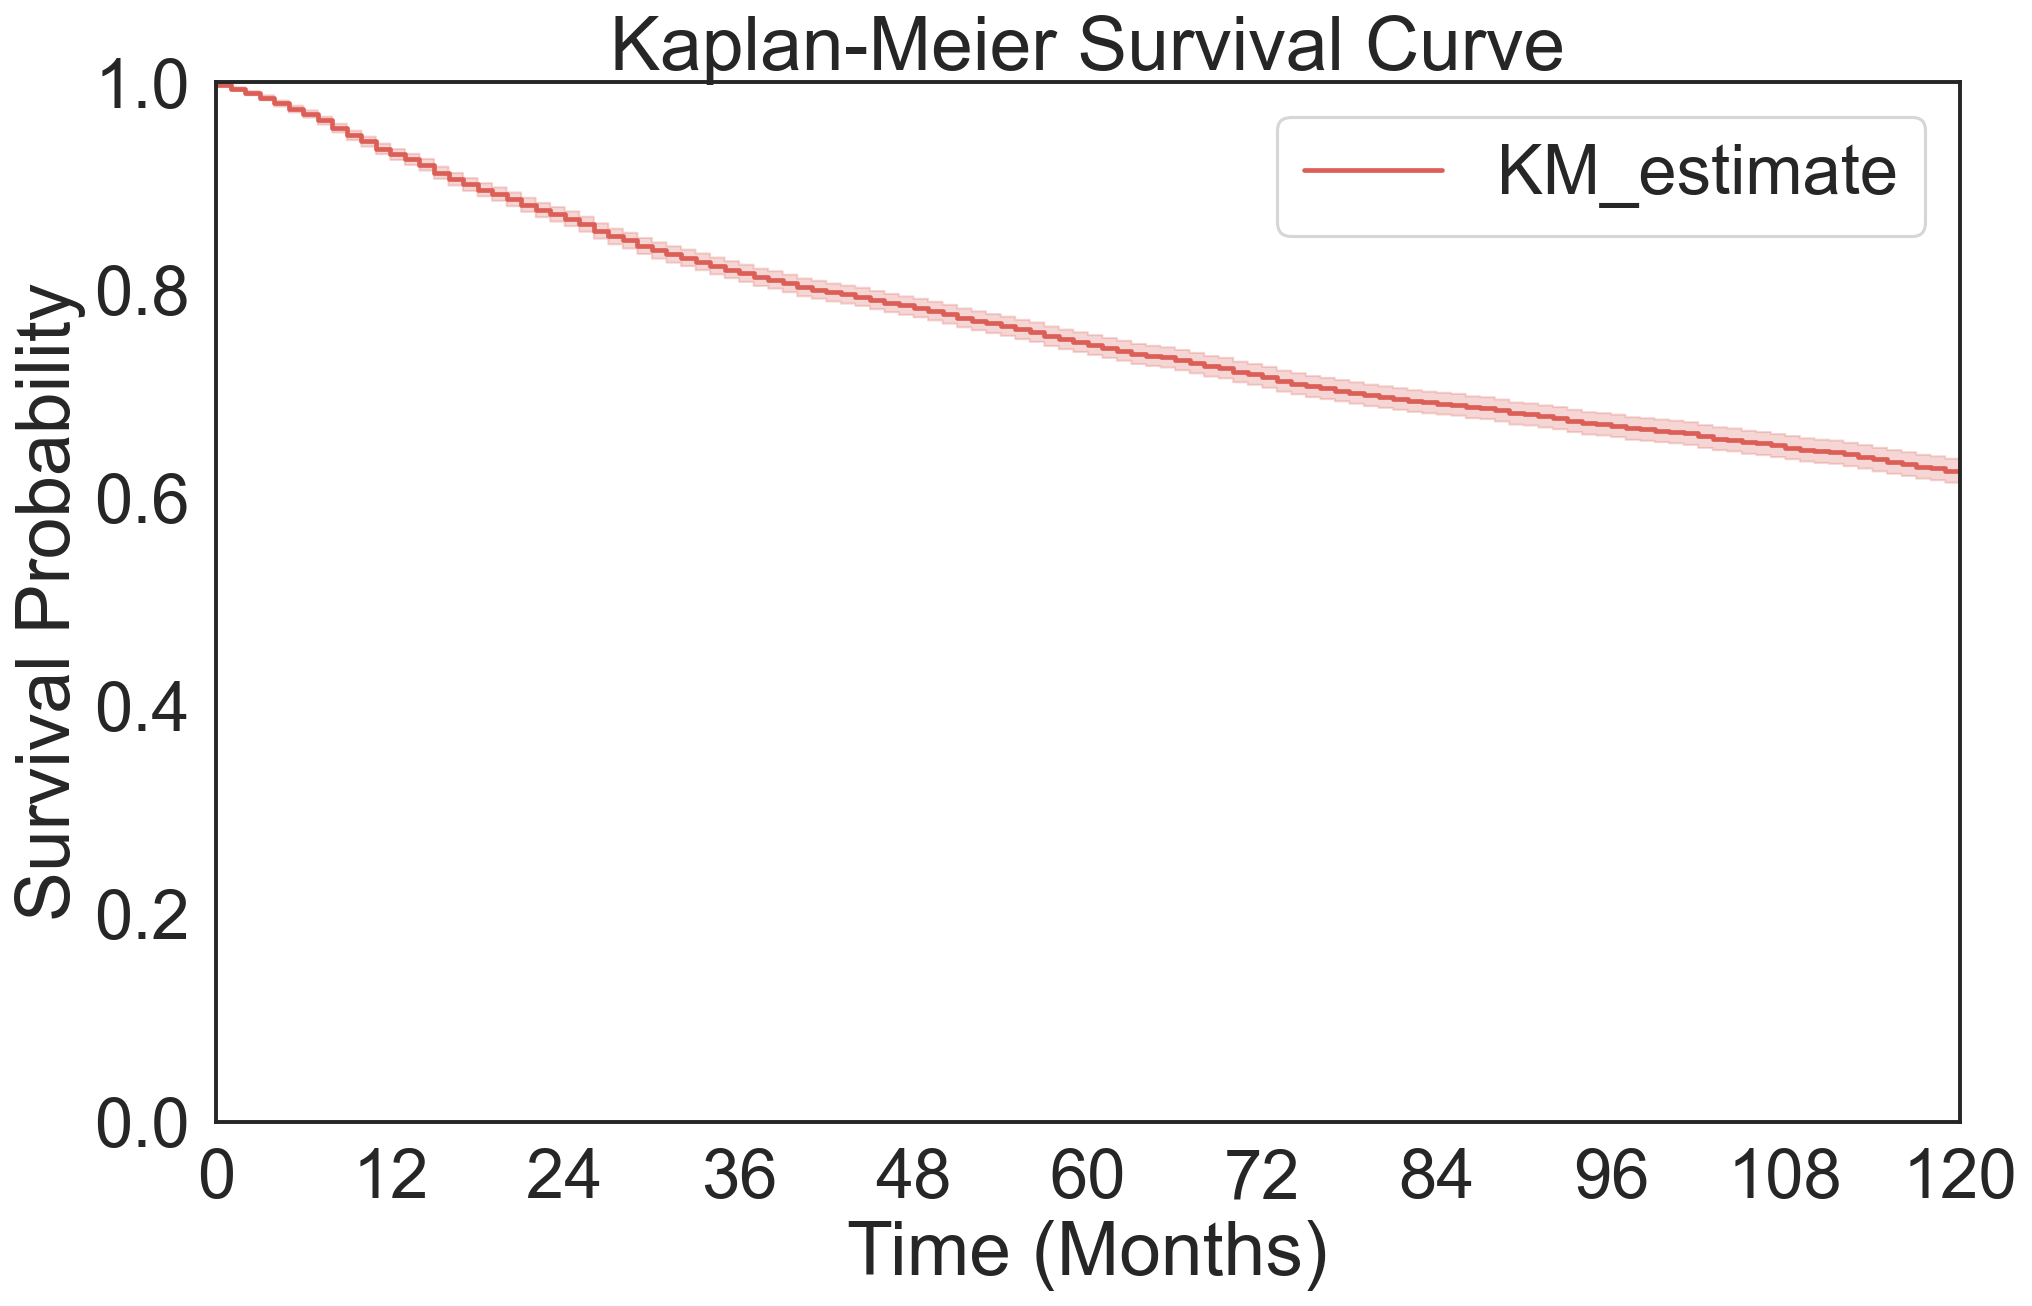

In [18]:
df = filtered_df.dropna()
# Instantiate model
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=df['Survival months'], event_observed=df['event_occurred'])

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Plot the survival curve
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(False)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))


median_survival = kmf.median_survival_time_
print(f"Median Survival Time: {median_survival} months")

survival_probability_atmonth = kmf.predict(120)
print(f"Survival Probability at 12 Months: {survival_probability_atmonth:.2f}")
surv_func = kmf.survival_function_
surv_ci = kmf.confidence_interval_

print(surv_func.loc[120])
print(surv_ci.loc[120])

plt.savefig('km_survival10year_overall.pdf', format='pdf', dpi=300, bbox_inches='tight')


## Histology Based KMs

/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/401822765.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()


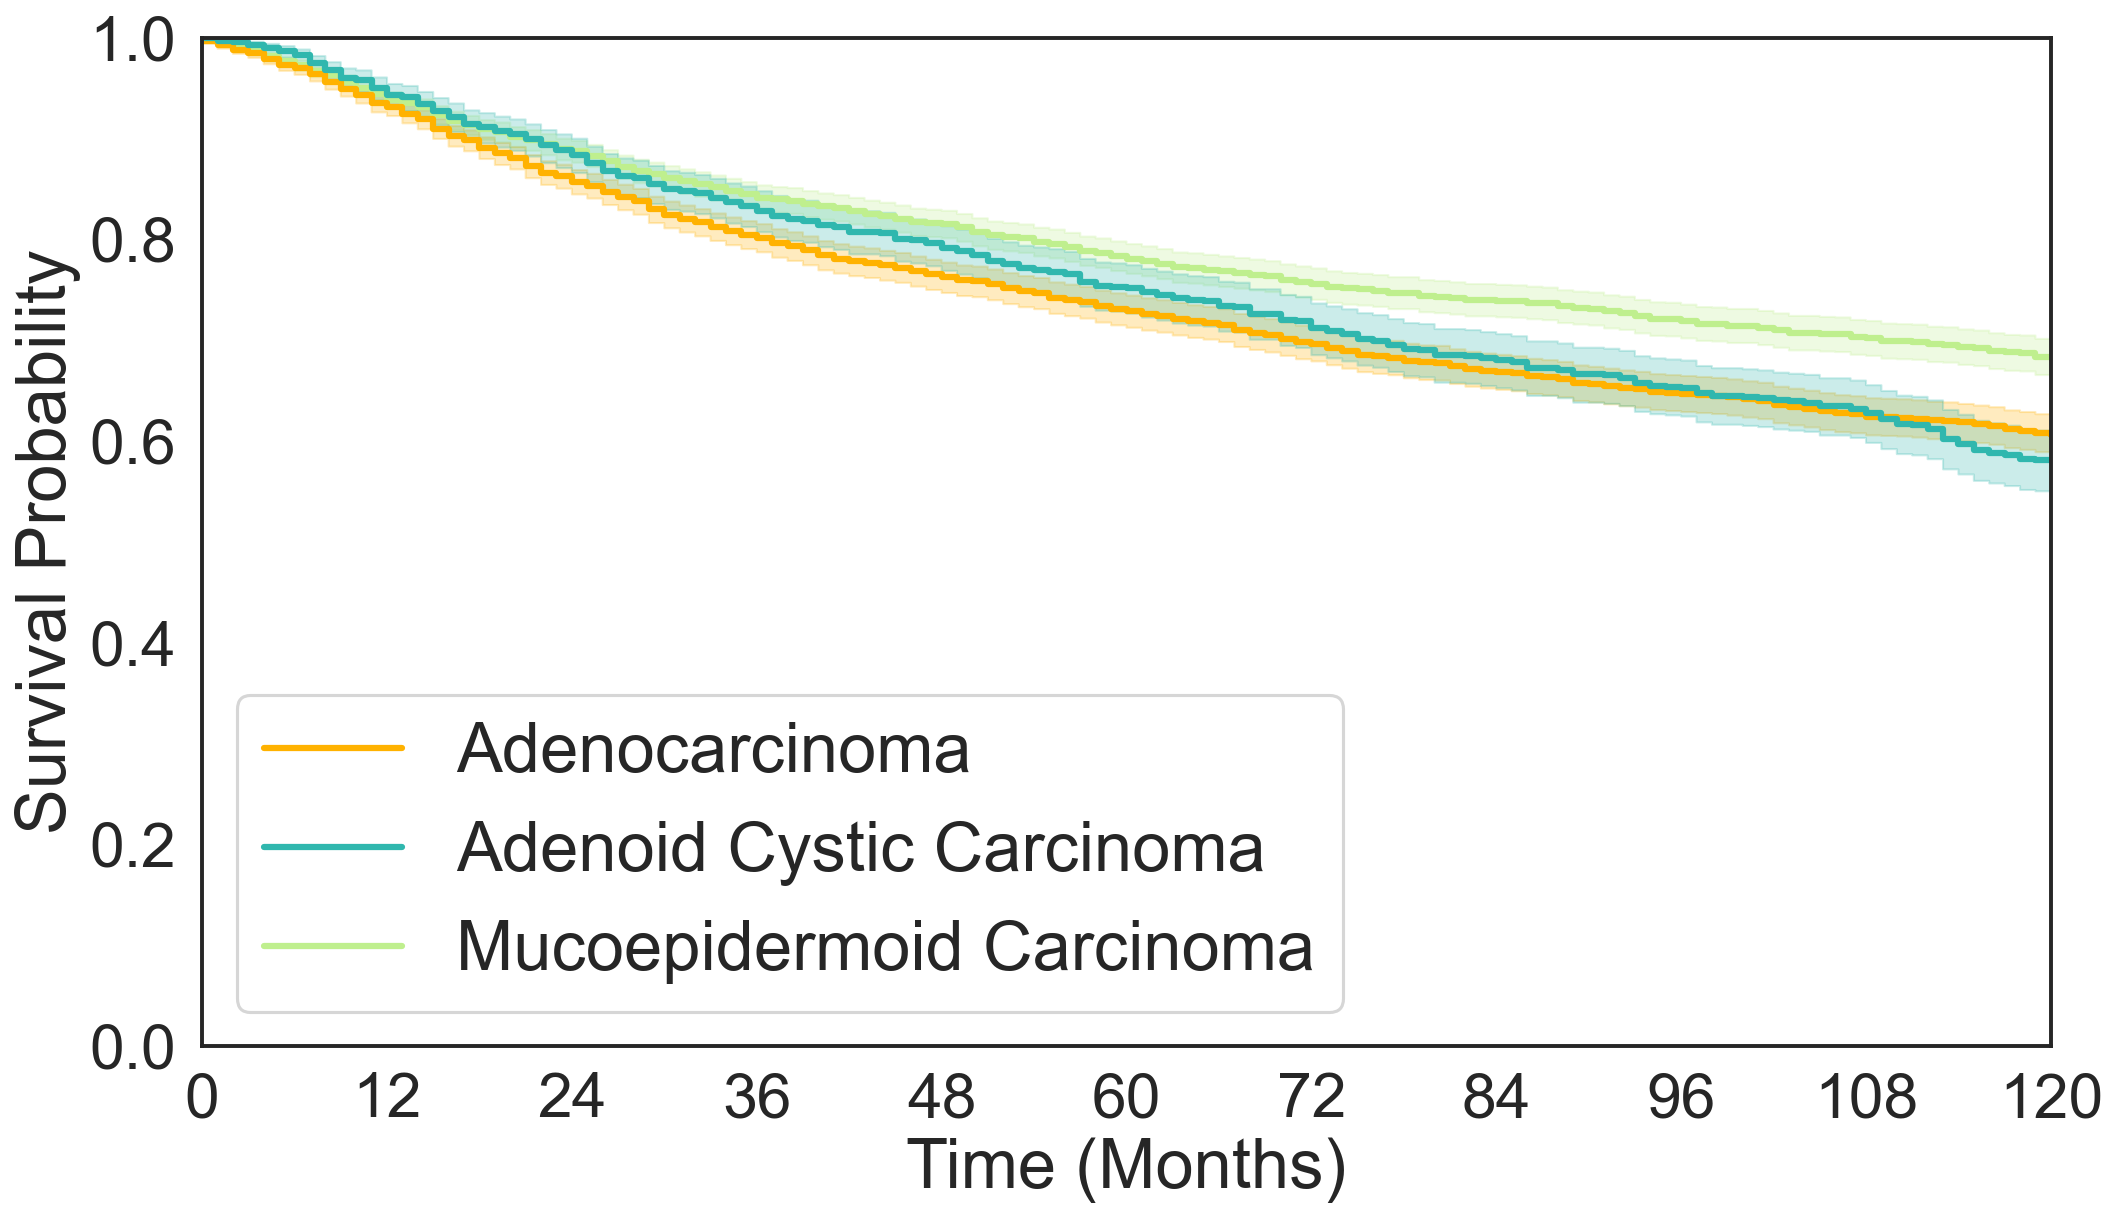

In [19]:
# Focus analysis on top cancers
filtered_df_forKM = filtered_df[filtered_df["Histology"].isin(topCancerTypes)]
filtered_df_forKM['Histology'] = filtered_df_forKM['Histology'].cat.remove_unused_categories()

df = filtered_df_forKM.dropna()

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique cancer types in your dataset
cancer_types = df['Histology'].unique()

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for cancer_type in cancer_types:
    # Filter the DataFrame for each cancer type
    df_cancer = df[df['Histology'] == cancer_type]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_cancer['Survival months'], event_observed=df_cancer['event_occurred'], label=cancer_type)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=topNColorDict[cancer_type])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
# plt.title('Kaplan-Meier Survival Curves for Top 3 Cancer Types', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs, title='Histology')

# Manually define the order of the legend items
ordered_labels = topCancerTypes

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
ax.legend(ordered_handles, ordered_labels)
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year_histology.pdf', format='pdf', dpi=300)
# Show the plot
plt.show()

## Race Based KMs

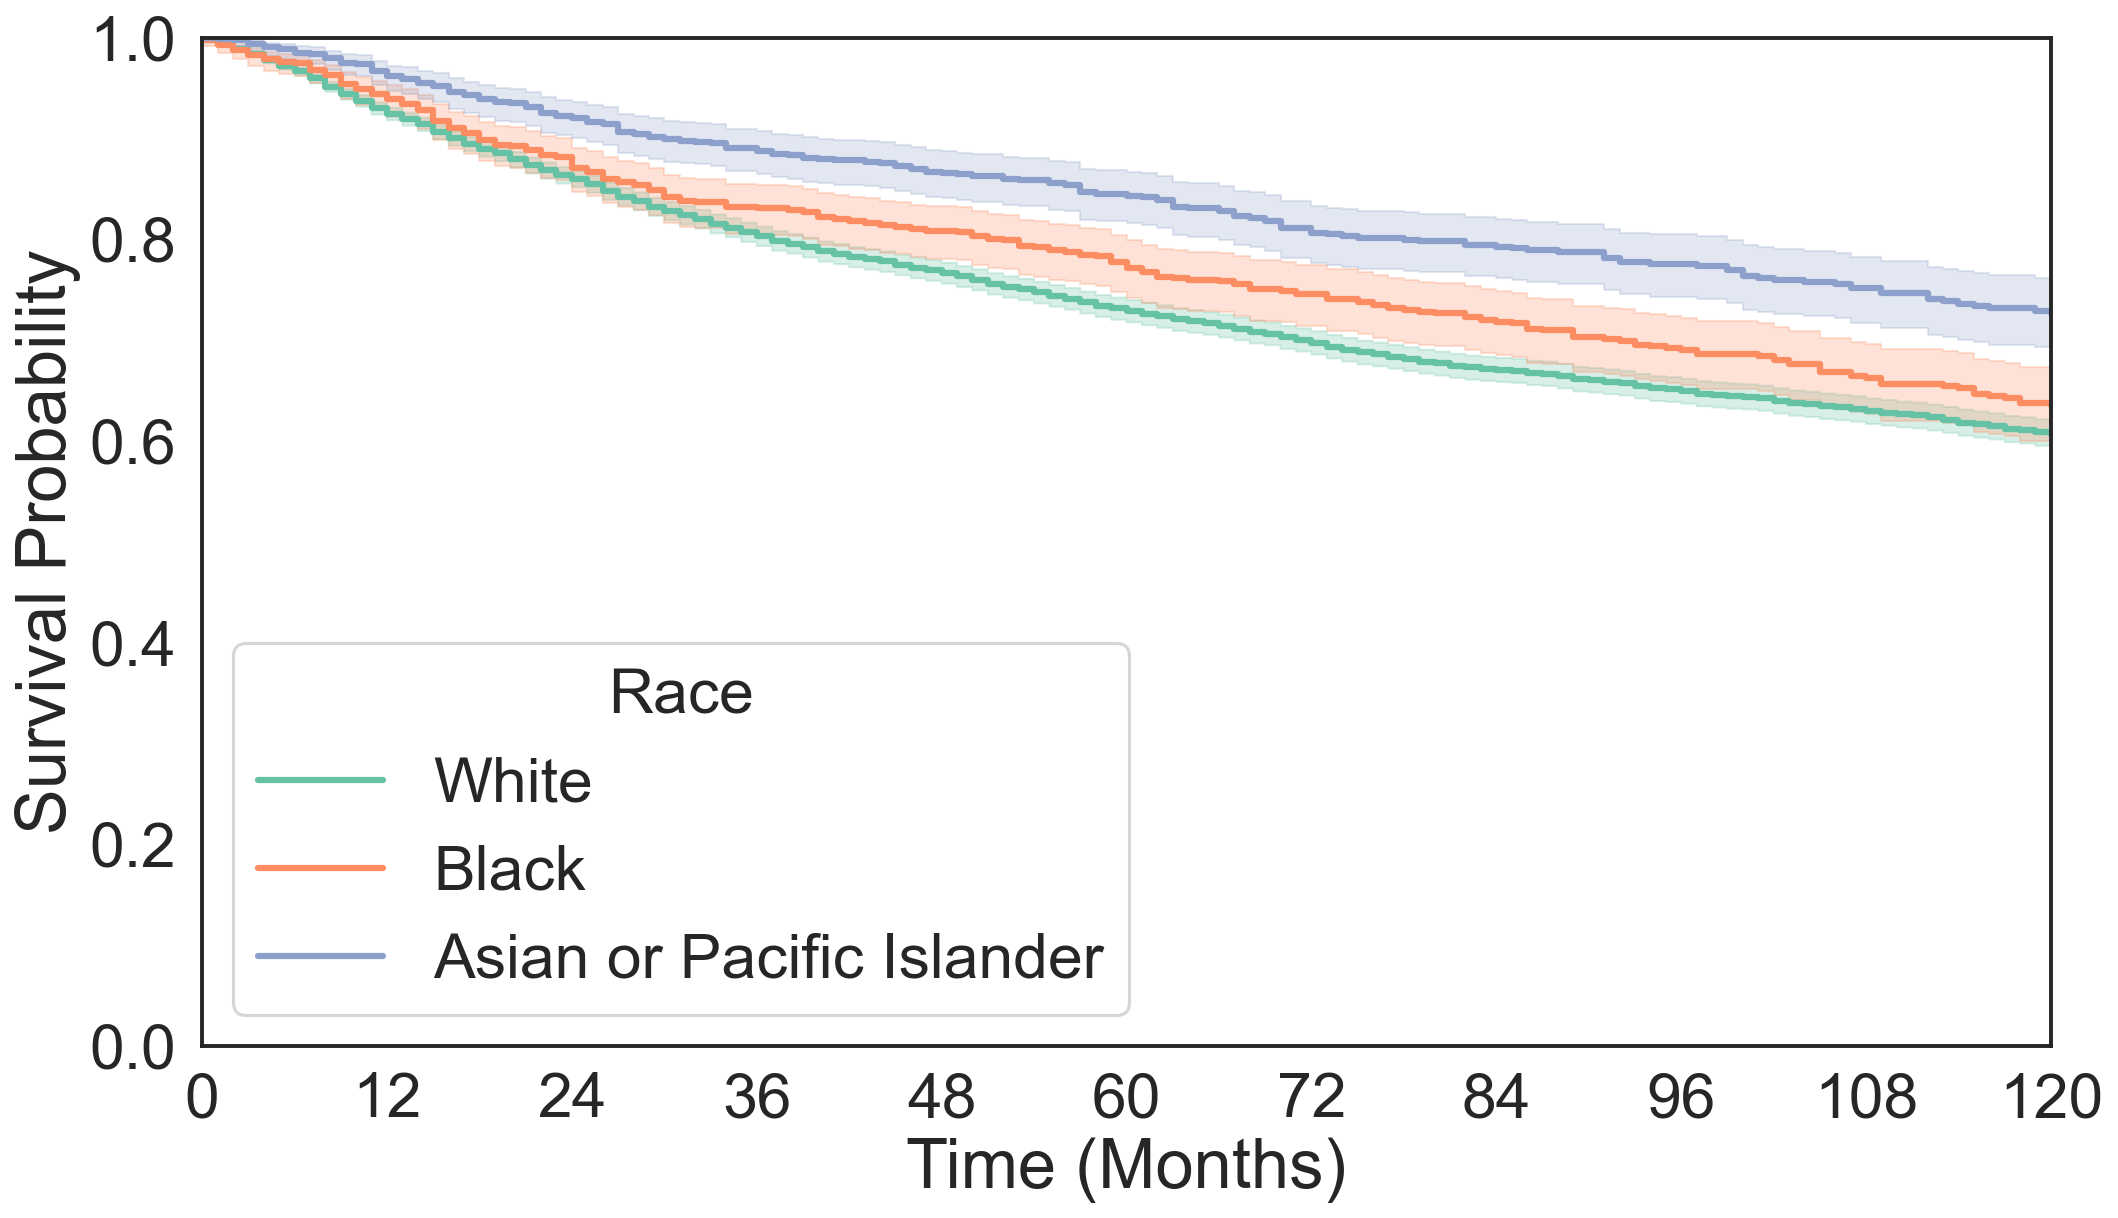

In [20]:
df = filtered_df.dropna()

all_races = df[race_colname].unique()

# Identify main races (those not in the low-proportion list)
main_races = [race for race in all_races if race not in low_proportion_categories[race_colname]]


df = df[df[race_colname].isin(main_races)]
df[race_colname] = df[race_colname].cat.remove_unused_categories()
df[race_colname] = df[race_colname].cat.reorder_categories(['Asian or Pacific Islander','Black','White'], ordered=True)

# Make new color dictionary
# colors = ['#FFB200', '#30B7AE', '#BFEF8E','#ffabab','#96f1ff'] # Basic Colors
raceColorDict = {race: color for race, color in zip(main_races, race_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for race in main_races:
    # Filter the DataFrame for each cancer type
    df_race = df[df[race_colname] == race]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_race['Survival months'], event_observed=df_race['event_occurred'], label=race)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=raceColorDict[race])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
# plt.title('Kaplan-Meier Survival Curves Across Races', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = main_races

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
legend = ax.legend(ordered_handles, ordered_labels, fontsize=base_fs, loc='best')

# Set the title for the legend
legend.set_title('Race', prop={'size': base_fs})
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year_race.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


## SES Based KMs


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3595514330.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Income Tertile Temp'] = df['Income Tertile']
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/3595514330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Income Tertile Temp'] = df['Income Tertile Temp'].cat.reorder_categories(['Upper','Middle','Lower'],ordered=True)


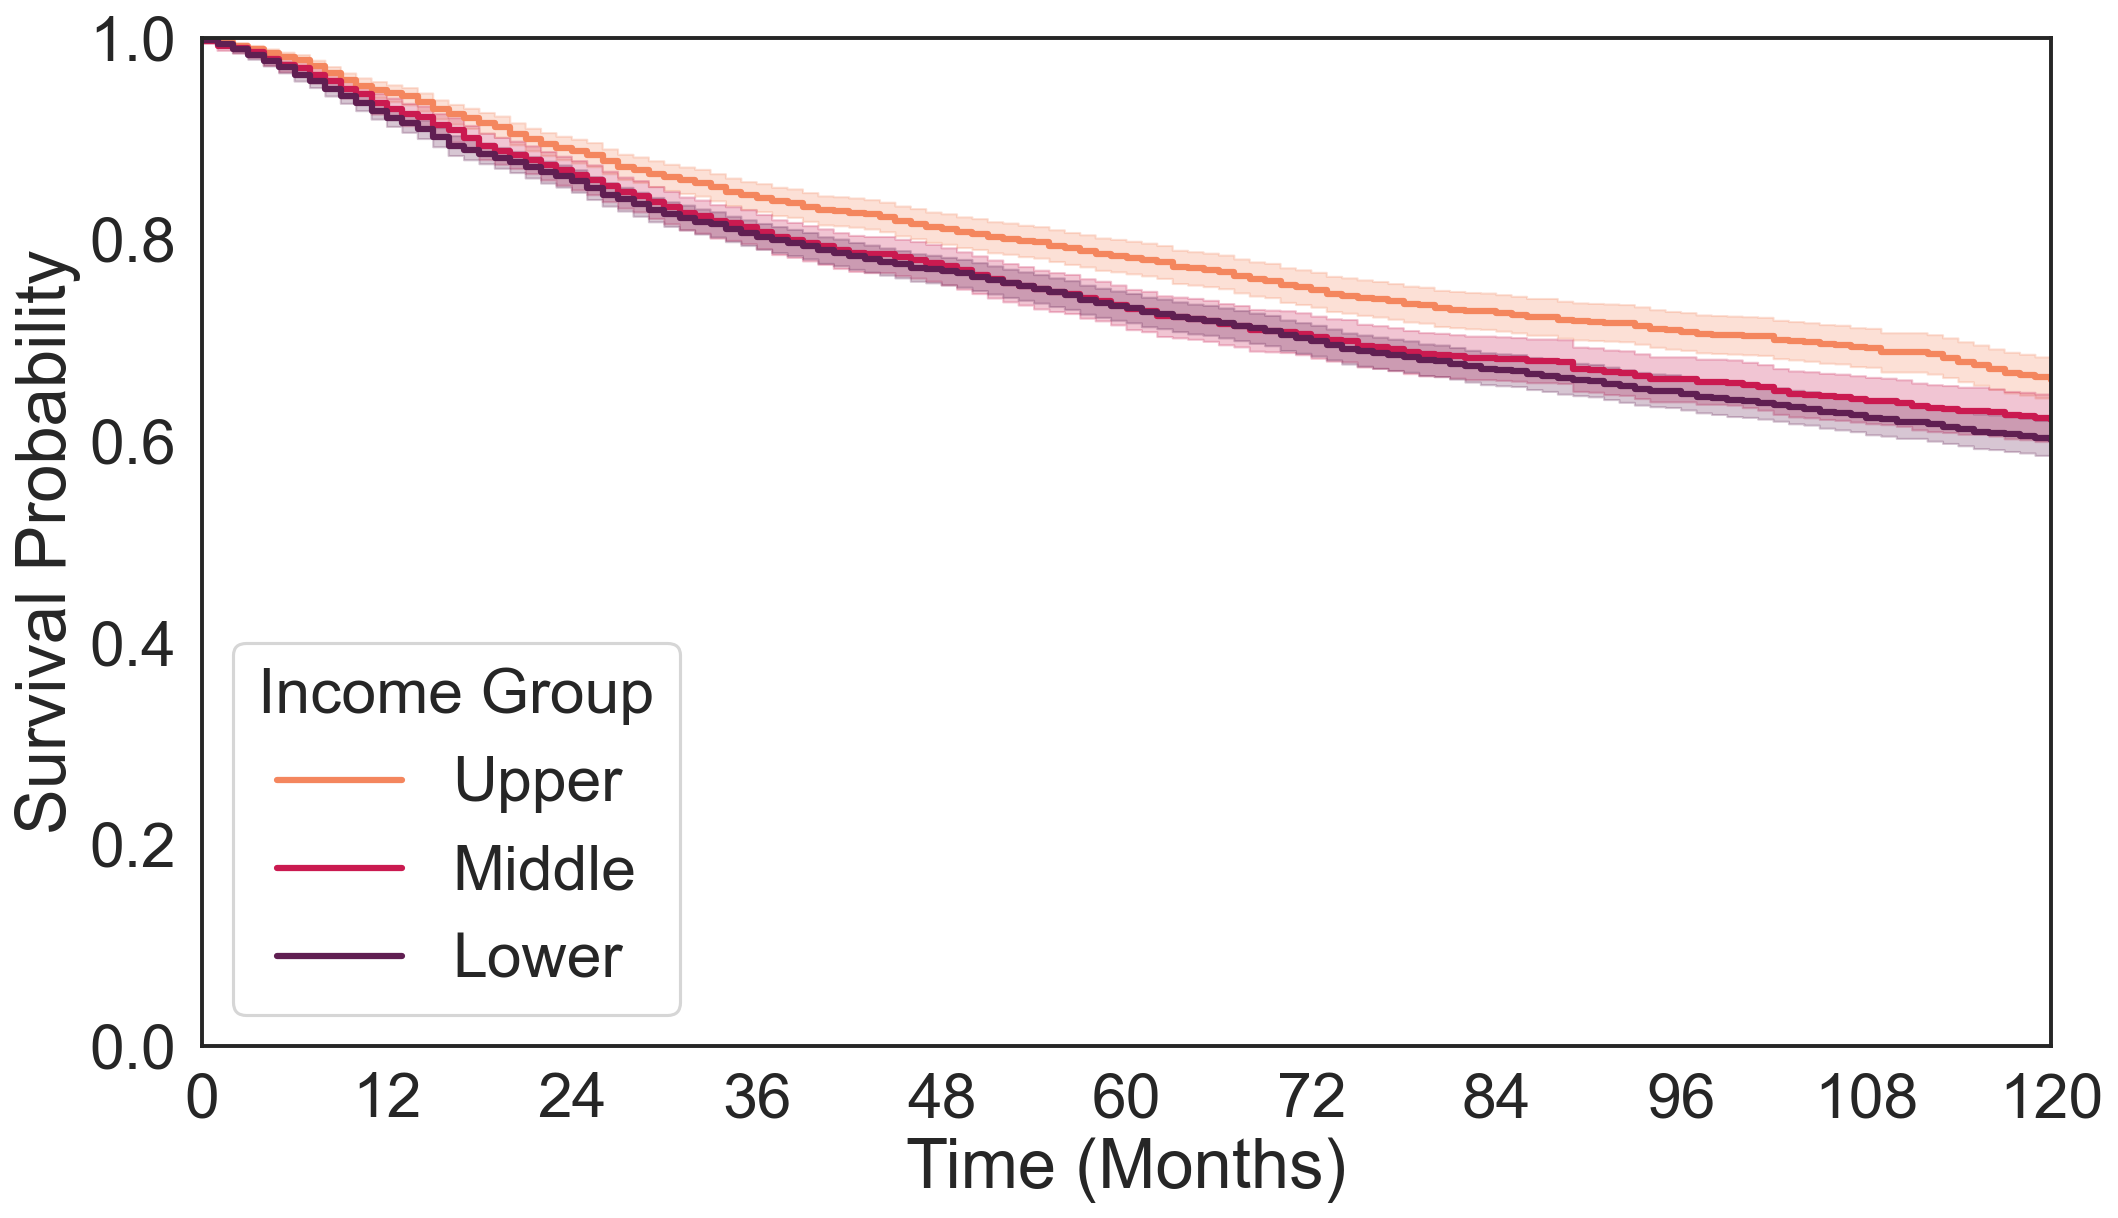

Income Tertile Temp
Lower     3930
Upper     3040
Middle    2335
Name: count, dtype: int64


In [21]:
df = filtered_df.dropna()
# df.info()
# First let's reorder tertiles for aesthetics
df['Income Tertile Temp'] = df['Income Tertile']

df['Income Tertile Temp'] = df['Income Tertile Temp'].cat.reorder_categories(['Upper','Middle','Lower'],ordered=True)
# display(df)

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique income quartile labels types in dataset
income_types = df['Income Tertile Temp'].cat.categories


# Make new color dictionary
incomeColorDict = {income_status: color for income_status, color in zip(income_types, ses_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for income_status in income_types:
    # Filter the DataFrame for each cancer type
    df_income = df[df['Income Tertile Temp'] == income_status]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_income['Survival months'], event_observed=df_income['event_occurred'], label=income_status)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=incomeColorDict[income_status])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
# plt.title('Kaplan-Meier Survival Curves for Income Tertiles', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs)

# Manually define the order of the legend items
ordered_labels = income_types

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
legend = ax.legend(ordered_handles, ordered_labels, fontsize=base_fs, loc='best')

# Set the title for the legend
legend.set_title('Income Group', prop={'size': base_fs})
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year_income.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

print(df['Income Tertile Temp'].value_counts())

## Sex Based KMs

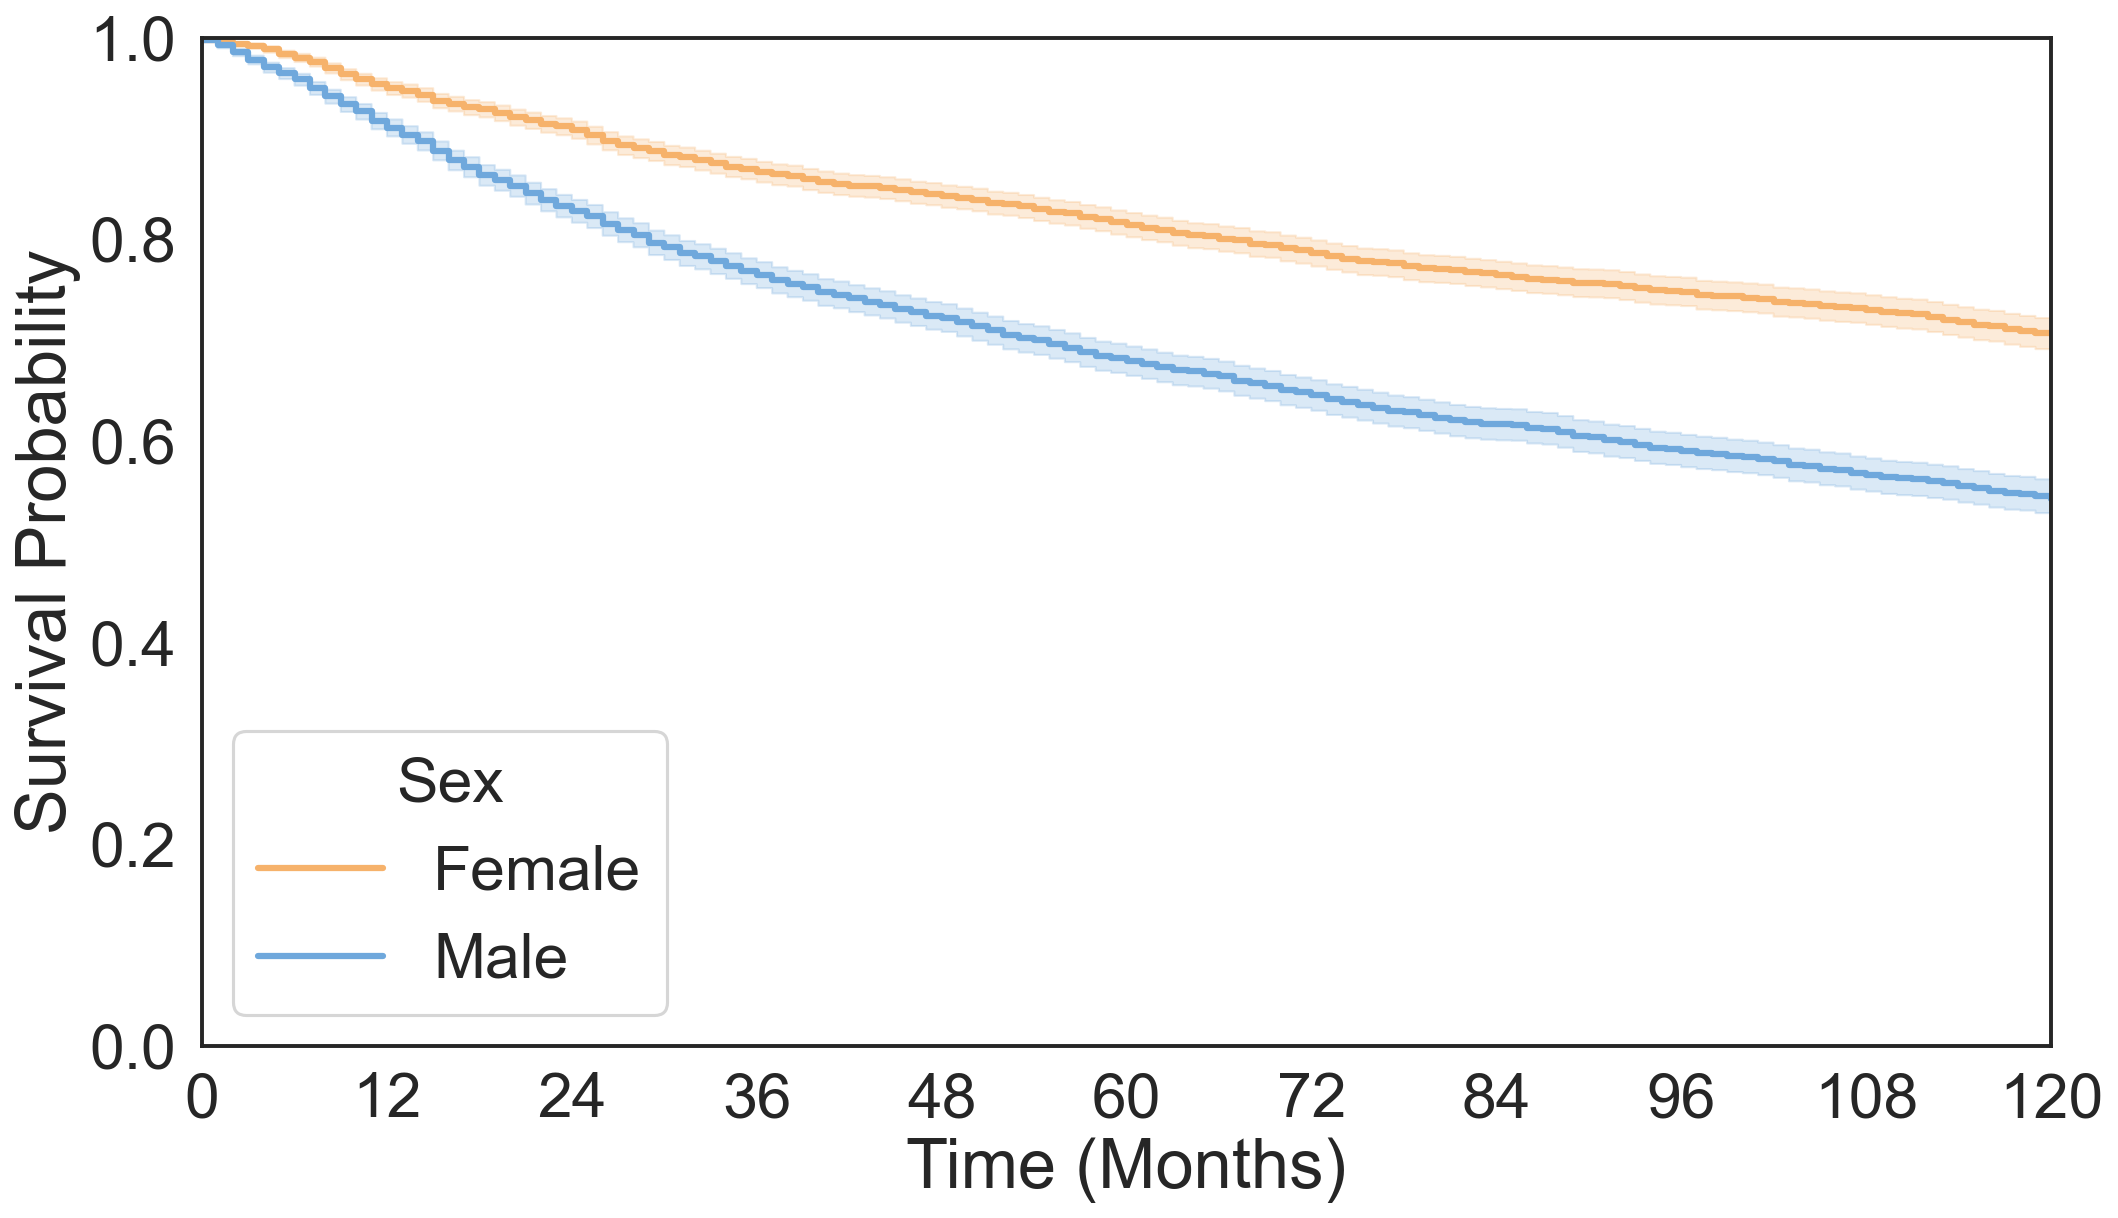

In [22]:
df = filtered_df.dropna()

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()
# Define the unique income quartile labels types in dataset
sex_values = df['Sex'].cat.categories

# Make new color dictionary
sexColorDict = {sex: color for sex, color in zip(sex_values, sex_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for sex in sex_values:
    # Filter the DataFrame for each cancer type
    df_sex = df[df['Sex'] == sex]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_sex['Survival months'], event_observed=df_sex['event_occurred'], label=sex)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=sexColorDict[sex])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
# plt.title('Kaplan-Meier Survival Curves for Sexes', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs, title='Sex')

# Manually define the order of the legend items
ordered_labels = sex_values

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
legend = ax.legend(ordered_handles, ordered_labels, fontsize=base_fs, loc='best')

# Set the title for the legend
legend.set_title('Sex', prop={'size': base_fs})
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year_sex.pdf',  format='pdf', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Marital Status KMs

['Married', 'Widowed', 'Single', 'Divorced/Separated']
Index(['Single', 'Married', 'Divorced/Separated', 'Widowed'], dtype='object')
Index(['Single', 'Married', 'Divorced/Separated', 'Widowed'], dtype='object')
Single
Married
Divorced/Separated
Widowed
Index(['Single', 'Married', 'Divorced/Separated', 'Widowed'], dtype='object')


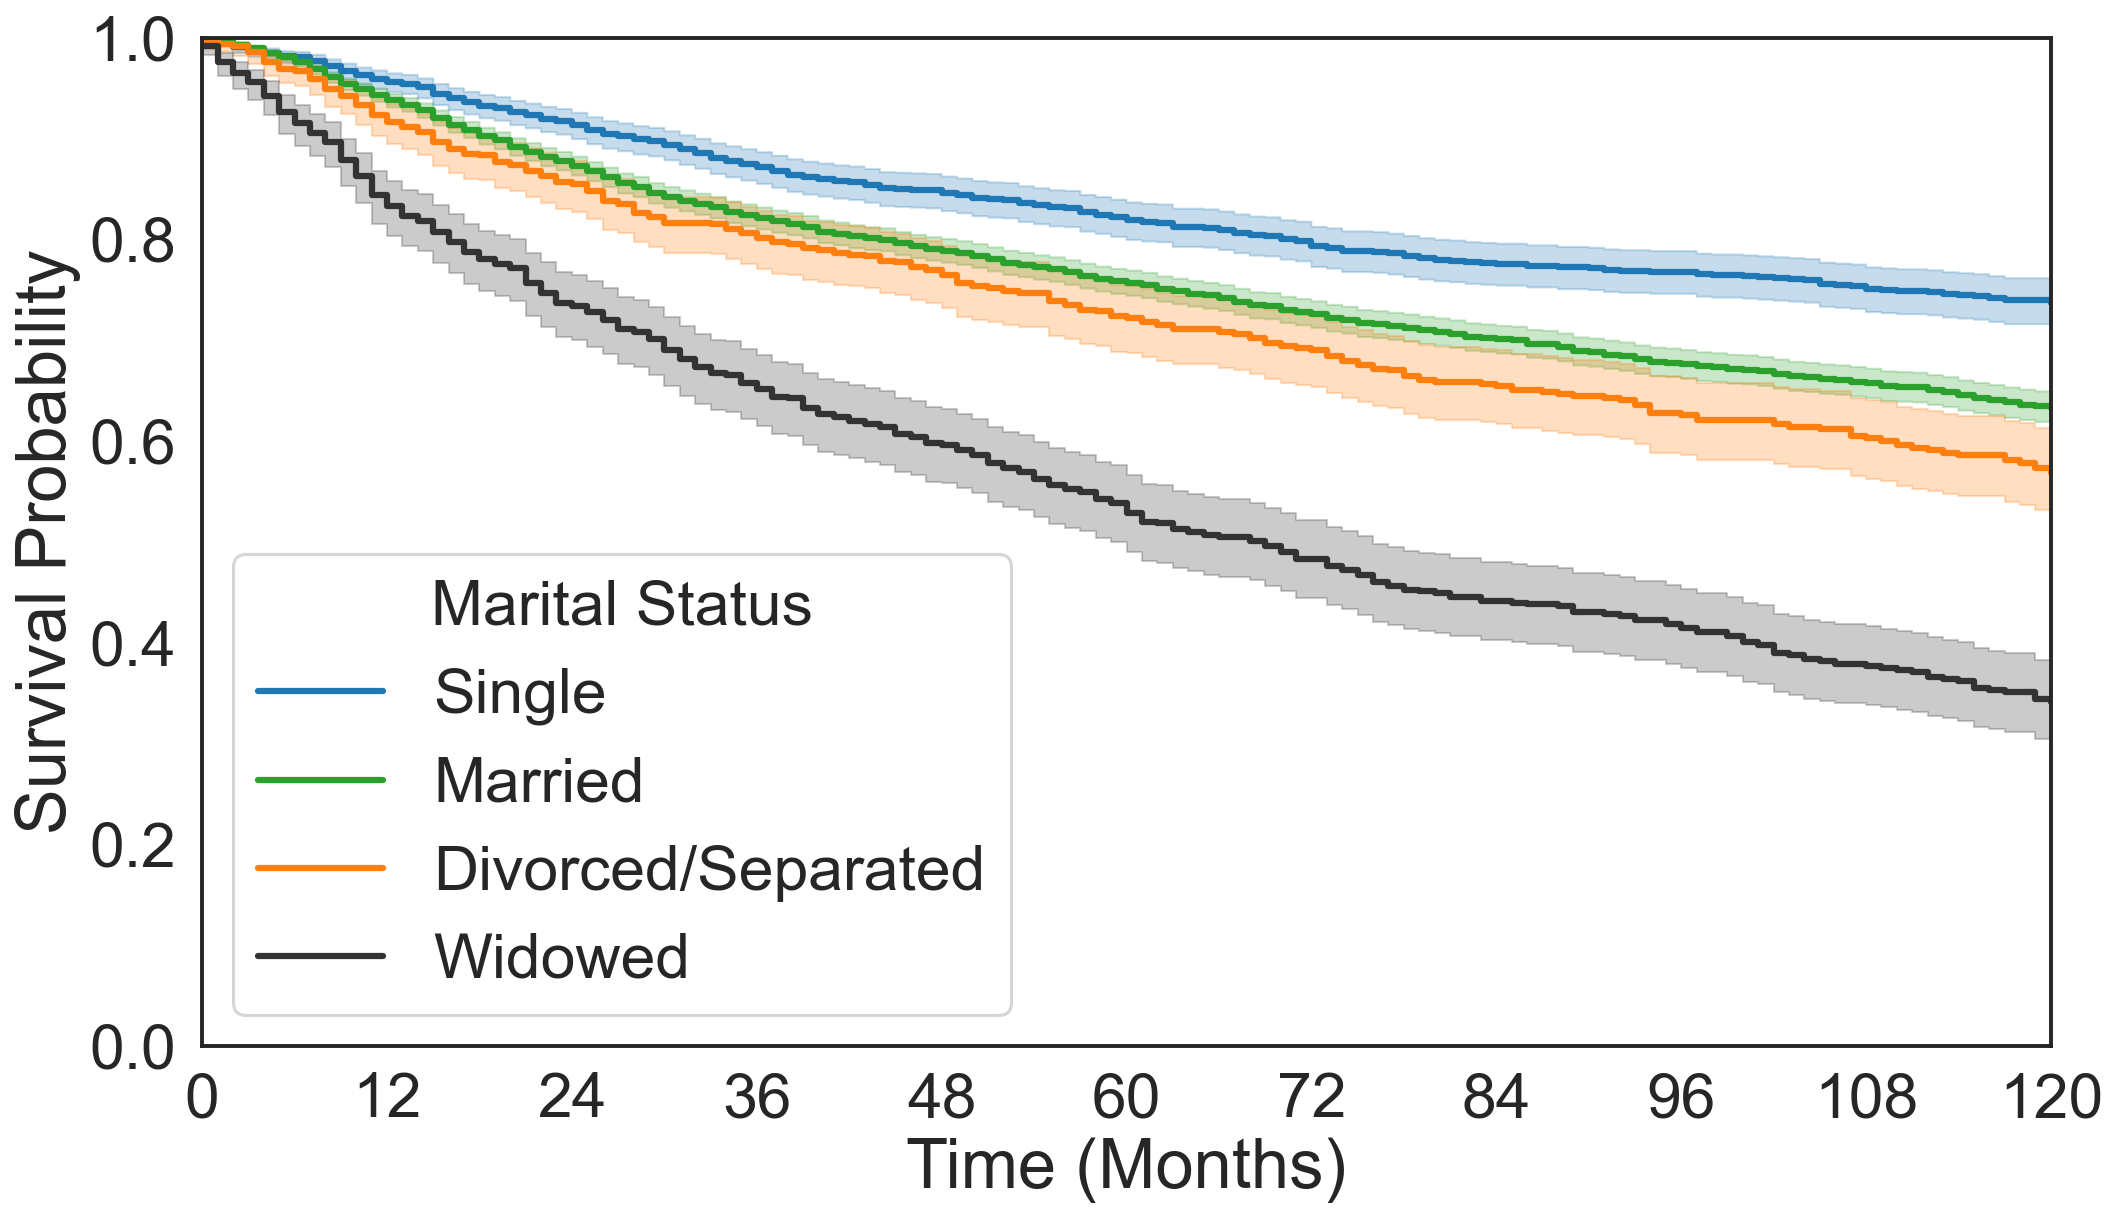

In [23]:
df = filtered_df.dropna()

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Define unique marital statuses
# Check if 'Unknown' and 'Domestic Partner' exist in the categories
# if {'Unknown', 'Domestic Partner'}.intersection(df[marital_colname].cat.categories):
#     df[marital_colname] = df[marital_colname].cat.remove_categories(['Unknown', 'Domestic Partner'])
all_statuses = df[marital_colname].unique()

# Identify main statuses (those not in the low-proportion list)
main_statuses = [status for status in all_statuses if status not in low_proportion_categories[marital_colname] and status != 'Unknown']
print(main_statuses)
df = df[df[marital_colname].isin(main_statuses)]
df[marital_colname] = df[marital_colname].cat.remove_unused_categories()
df[marital_colname] = df[marital_colname].cat.reorder_categories(['Single','Married','Divorced/Separated','Widowed'])
# df[marital_colname] = df[marital_colname].map({'Divorced/Separated':'Single',
#                                                'Widowed':'Single',
#                                                'Married':'Married'}).astype('category')
df = df[df[marital_colname] != 'Unknown']
df[marital_colname] = df[marital_colname].cat.remove_unused_categories()
print(df[marital_colname].cat.categories)
marital_values = df[marital_colname].cat.categories
print(marital_values)
# marital_values = marital_values[~marital_values.isin(['Unknown','Domestic Partner'])]
# Make new color dictionary
mSColorDict = {maritalStatus: color for maritalStatus, color in zip(marital_values, marital_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for ms in marital_values:
    print(ms)
    # Filter the DataFrame for each cancer type
    df_ms = df[df[marital_colname] == ms]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_ms['Survival months'], event_observed=df_ms['event_occurred'], label=ms)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=mSColorDict[ms])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
# plt.title('Kaplan-Meier Survival Curves for Marital Status', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs, title='Marital Status')

# Manually define the order of the legend items
ordered_labels = marital_values
print(marital_values)
# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
legend = ax.legend(ordered_handles, ordered_labels, fontsize=base_fs, loc='best')

# Set the title for the legend
legend.set_title('Marital Status', prop={'size': base_fs})
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year_marital.pdf', format='pdf', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()



## Primary Site KMs

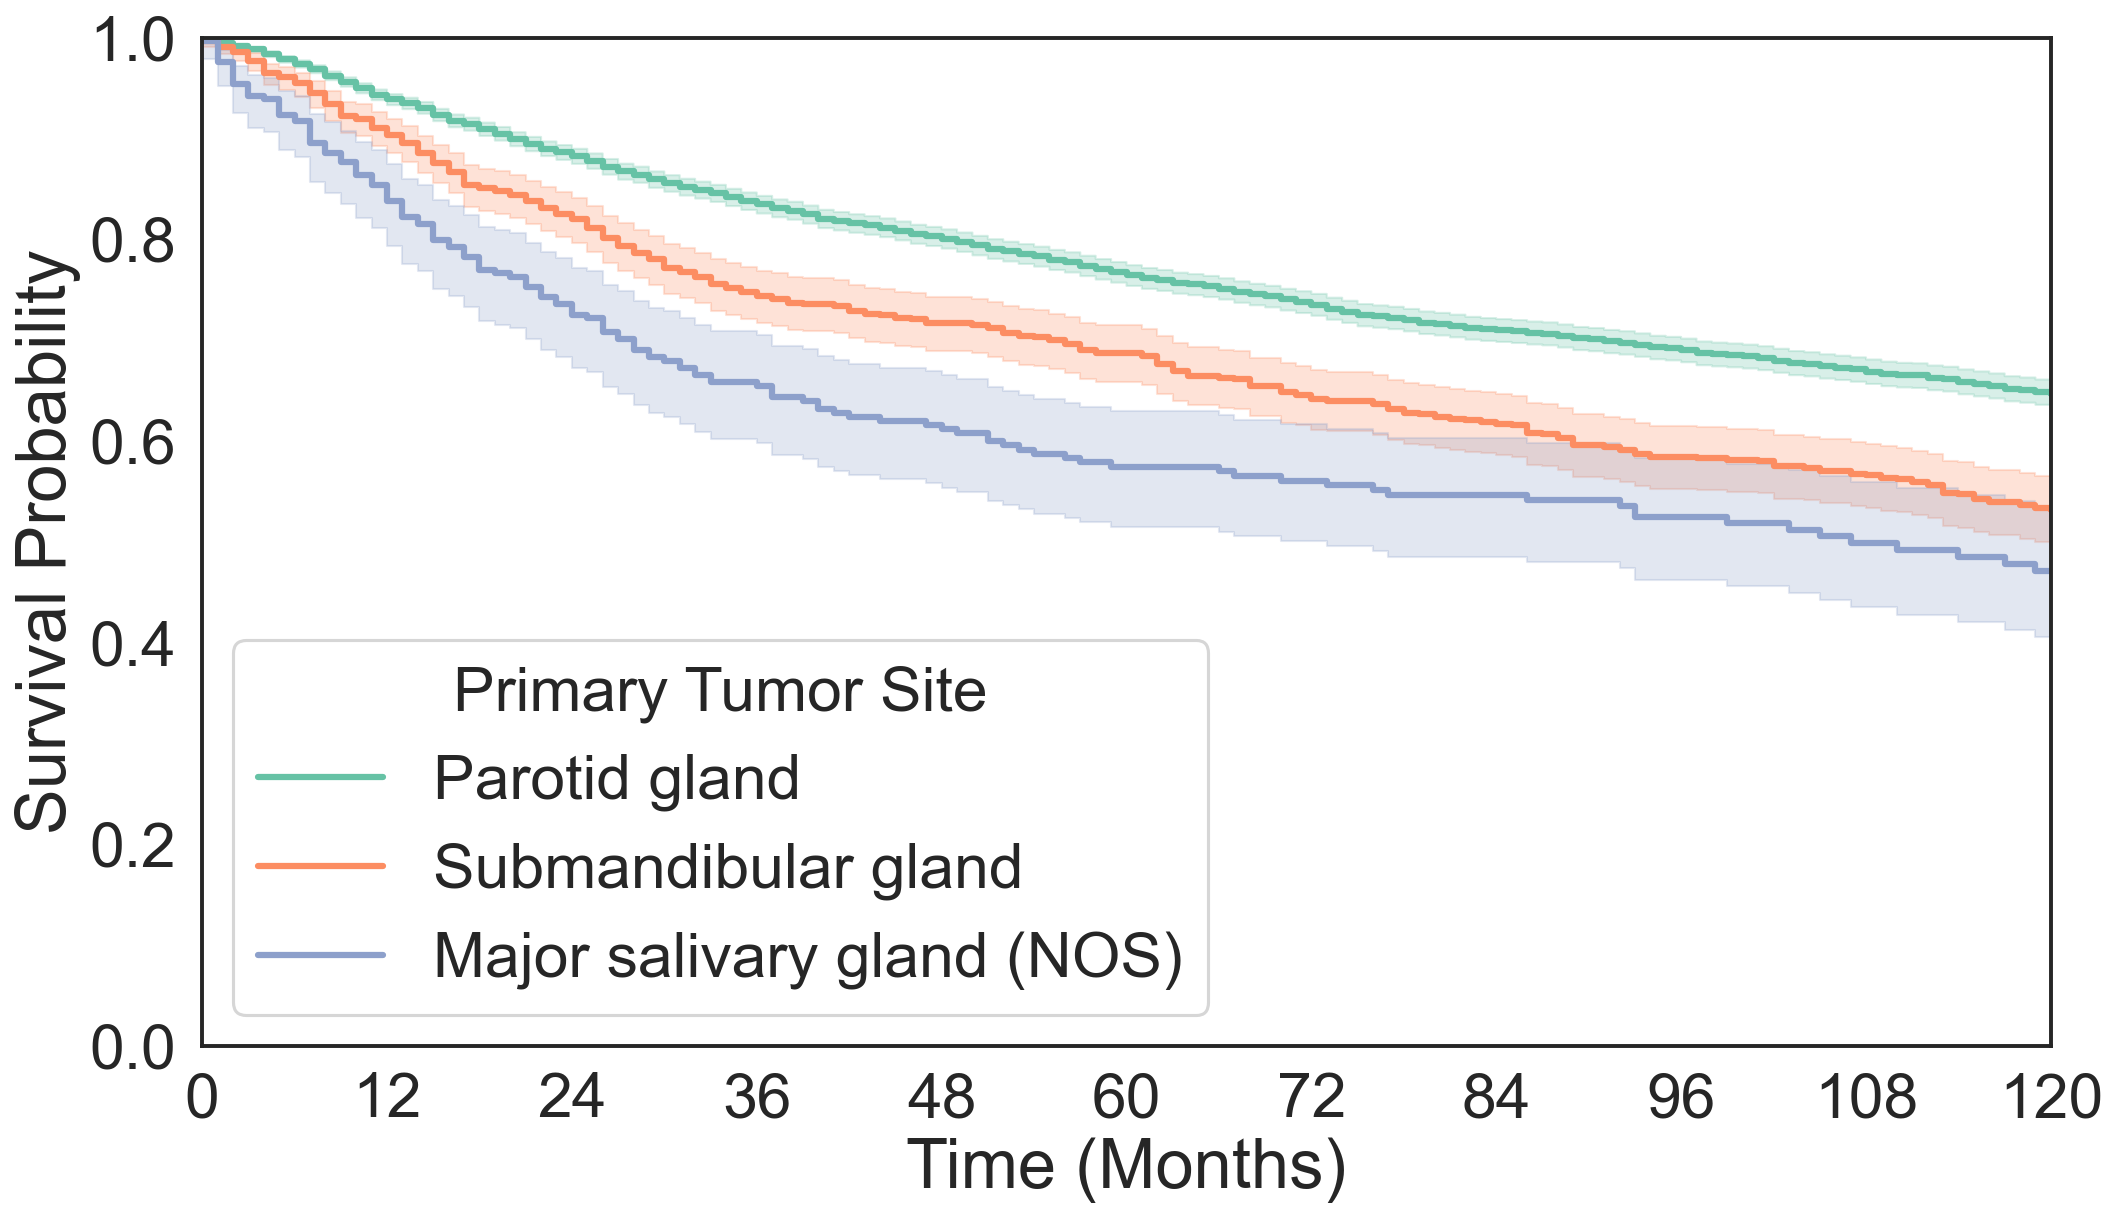

In [24]:
df = filtered_df.dropna()

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

all_sites = df[site_colname].unique()

# Identify main statuses (those not in the low-proportion list)
main_sites = [sites for sites in all_sites if sites not in low_proportion_categories[site_colname]]

df = df[df[site_colname].isin(main_sites)]
df[site_colname] = df[site_colname].cat.remove_unused_categories()
df[site_colname] = df[site_colname].cat.reorder_categories(['Parotid gland','Submandibular gland','Major salivary gland, NOS'])
df[site_colname] = df[site_colname].cat.rename_categories({'Major salivary gland, NOS':'Major salivary gland (NOS)'})

site_values = df[site_colname].cat.categories
# marital_values = marital_values[~marital_values.isin(['Unknown','Domestic Partner'])]
# Make new color dictionary
siteColorDict = {maritalStatus: color for maritalStatus, color in zip(site_values, site_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each cancer type to plot Kaplan-Meier curves
for site in site_values:
    # Filter the DataFrame for each cancer type
    df_site = df[df[site_colname] == site]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_site['Survival months'], event_observed=df_site['event_occurred'], label=site)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=siteColorDict[site])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
# plt.title('Kaplan-Meier Survival Curves for Primary Tumor Site', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs, title='Primary Site')

# Manually define the order of the legend items
ordered_labels = site_values

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
legend = ax.legend(ordered_handles, ordered_labels, fontsize=base_fs, loc='best')

# Set the title for the legend
legend.set_title('Primary Tumor Site', prop={'size': base_fs})
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year_tumor_site.pdf', format='pdf',dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Tumor Grade

['High', 'Low', 'Unknown', 'Intermediate']


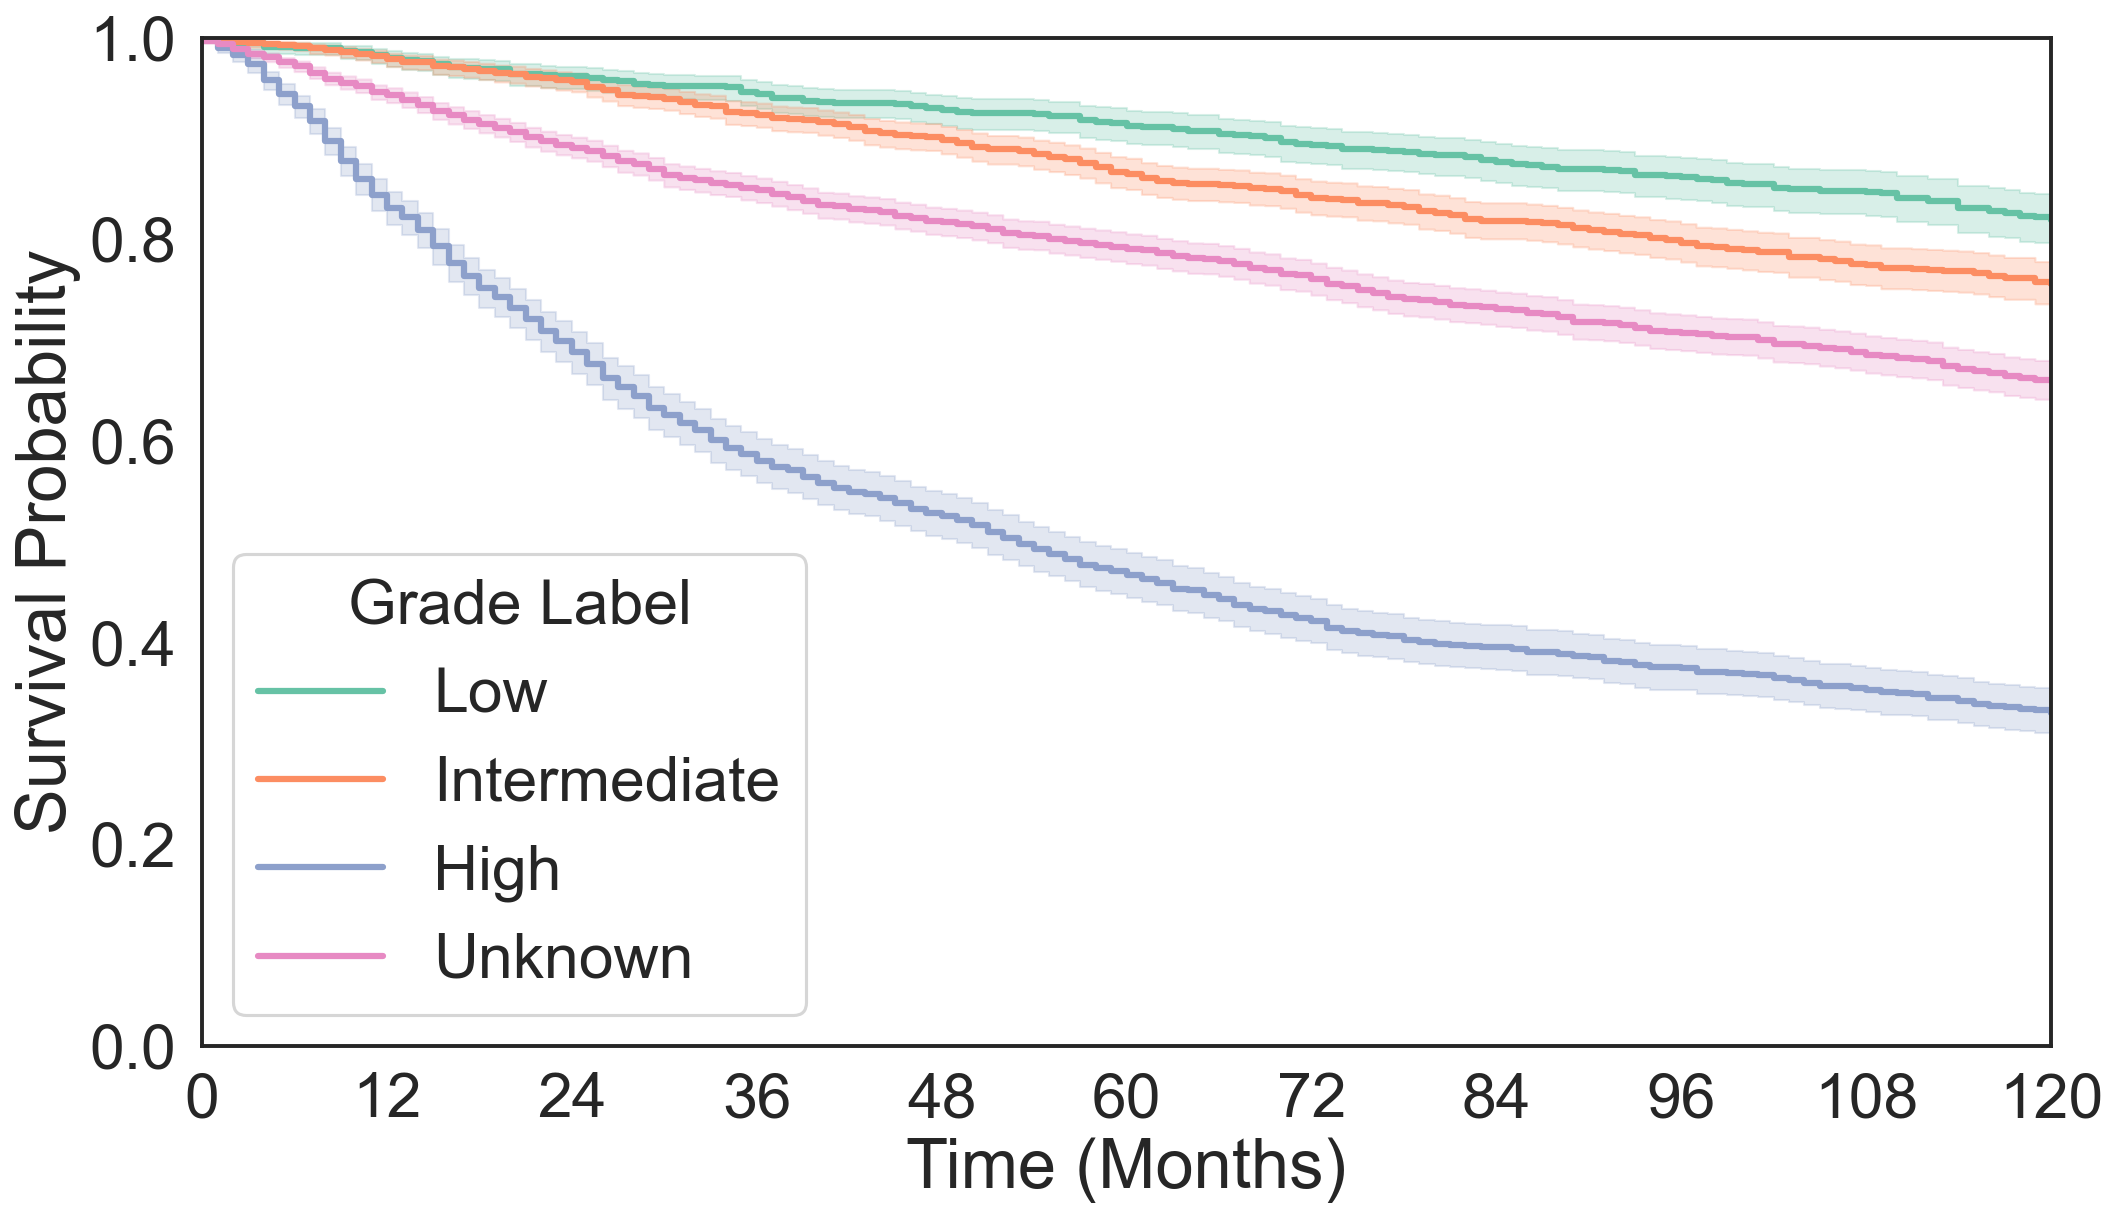

In [25]:
df = filtered_df.dropna()
grade_colname = 'Grade Level'

# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

all_grades = df[grade_colname].unique()

# Identify main grades (those not in the low-proportion list)
main_grades = [grades for grades in all_grades if grades not in low_proportion_categories[site_colname]]
print(main_grades)

df = df[df[grade_colname].isin(main_grades)]
df[grade_colname] = df[grade_colname].cat.remove_unused_categories()
df[grade_colname] = df[grade_colname].cat.reorder_categories(['Low','Intermediate','High','Unknown'])

grade_values = df[grade_colname].cat.categories
# marital_values = marital_values[~marital_values.isin(['Unknown','Domestic Partner'])]
# Make new color dictionary
gradeColorDict = {grade: color for grade, color in zip(grade_values, site_colorpalette)}

# Create the plot
fig, ax = plt.subplots(figsize=(15,9))

# Loop over each grade label to plot Kaplan-Meier curves
for grade in grade_values:
    # Filter the DataFrame for each cancer type
    df_site = df[df[grade_colname] == grade]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=df_site['Survival months'], event_observed=df_site['event_occurred'], label=grade)

    # Plot the survival function for this cancer type
    kmf.plot_survival_function(ci_show=True,lw=3,
                               color=gradeColorDict[grade])

# Customize title, labels, and ticks with specific font sizes
base_fs = 30
# plt.title('Kaplan-Meier Survival Curves for Primary Tumor Site', fontsize=base_fs*1.2)
plt.xlabel('Time (Months)', fontsize=base_fs*1.1)
plt.ylabel('Survival Probability', fontsize=base_fs*1.1)

# Adjust the tick label font size
plt.xticks(fontsize=base_fs)
plt.yticks(fontsize=base_fs)

# Set axis limits and ticks
plt.ylim(0, 1)
plt.xlim(0, 120)
plt.xticks(range(0, 121, 12))

# Remove y-axis grid lines
plt.grid(False, axis='y')

# Customize the legend font size
plt.legend(loc='best', fontsize=base_fs, title='Grade Label')

# Manually define the order of the legend items
ordered_labels = grade_values

# Get the current handles and labels from the plot
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels to match the desired order
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]

# Now, set the legend with the desired order
legend = ax.legend(ordered_handles, ordered_labels, fontsize=base_fs, loc='best')

# Set the title for the legend
legend.set_title('Grade Label', prop={'size': base_fs})
# set layout
plt.tight_layout()
# save the plot
plt.savefig('km_survival10year_Grade.pdf', format='pdf',dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [26]:
print(filtered_df_over18.columns)

Index(['Patient ID', 'Age recode with <1 year olds', 'Sex',
       'Year of diagnosis', 'PRCDA 2020', 'Race recode (W, B, AI, API)',
       'Origin recode NHIA (Hispanic, Non-Hisp)',
       'Site recode ICD-O-3/WHO 2008', 'Behavior code ICD-O-3',
       'Primary Site - labeled', 'Primary Site', 'Histologic Type ICD-O-3',
       'Grade Recode (thru 2017)', 'Derived Summary Grade 2018 (2018+)',
       'Grade Clinical (2018+)', 'Grade Pathological (2018+)', 'Laterality',
       'Diagnostic Confirmation', 'ICD-O-3 Hist/behav',
       'ICD-O-3 Hist/behav, malignant', 'Histology recode - broad groupings',
       'Site recode ICD-O-3/WHO 2008 (for SIRs)',
       'Combined Summary Stage (2004+)', 'Summary stage 2000 (1998-2017)',
       'SEER Combined Summary Stage 2000 (2004-2017)',
       'SEER historic stage A (1973-2015)', 'RX Summ--Surg Prim Site (1998+)',
       'RX Summ--Scope Reg LN Sur (2003+)',
       'RX Summ--Surg Oth Reg/Dis (2003+)', 'RX Summ--Surg/Rad Seq',
       'Reason no can

# Cox Proportional Hazard Ratio

## Model 1: One-Hot Encoding

### Data Preparation including one-hot encoding and addressing collinearities

In [27]:
# Filter the dataset to include only relevant columns for the Cox model
df = filtered_df.dropna()
# Sort Sex col
df[sex_colname] = df[sex_colname].cat.reorder_categories([
    'Male',
    'Female'],
    ordered=True)

# Filter & Sort race col
df = df[df[race_colname].isin(main_races)]
df[race_colname] = df[race_colname].cat.remove_unused_categories()
df[race_colname] = df[race_colname].cat.reorder_categories([
    'White',
    'Black',
    'Asian or Pacific Islander'],
    ordered=True
)

# Sort grade
df['Grade Level'] = df['Grade Level'].cat.reorder_categories([
    'Low',
    'Intermediate',
    'High',
    'Unknown'],
    ordered=True
)

# Filter and sort histology
df = df[df['Histology'].isin(topCancerTypes)]
df['Histology'] = df['Histology'].cat.remove_unused_categories()
df['Histology'] = df['Histology'].cat.reorder_categories([
    'Adenocarcinoma',
    'Adenoid Cystic Carcinoma',
    'Mucoepidermoid Carcinoma'],
    ordered=True
)

# Filter and sort Marital status
df = df[df[marital_colname].isin(main_statuses)]
df[marital_colname] = df[marital_colname].cat.remove_unused_categories()
df[marital_colname] = df[marital_colname].cat.reorder_categories([
    'Single',
    'Married',
    'Divorced/Separated',
    'Widowed'],
    ordered=True
)

# Filter Primary Site
df = df[df[site_colname].isin(main_sites)]
df[site_colname] = df[site_colname].cat.remove_unused_categories()
df[site_colname] = df[site_colname].cat.reorder_categories([
    'Parotid gland',
    'Submandibular gland',
    'Major salivary gland, NOS'])
df[site_colname] = df[site_colname].cat.rename_categories({'Major salivary gland, NOS':'Major salivary gland (NOS)'})

# Identify the demographic determinants of interest
df['Income Tertile'] = pd.qcut(df['Income_numeric'], q=3, labels=["Lower", "Middle", "Upper"])
df['Income Tertile'] = df['Income Tertile'].cat.reorder_categories(["Middle","Lower", "Upper"], ordered=True)
demographic_determinants = [
    
    # 'Age recode with single ages and 90+', 
    'Sex',
    # 'Histology',
    'Marital status at diagnosis',
    'Race recode (W, B, AI, API)',
    # 'Grade Level',
    'Income Tertile',
    # 'Primary Site - labeled'
    ]

df_cox_dem = df[demographic_determinants + ['Survival months','event_occurred']] # df is used 

# Defined age bins (Children and then by decade)
age_bins = [0, 17, 29, 39, 49, 59, 69, 79, 100]
age_labels = ['0-17', '18-29', '30-39', '40-49', '50-59','60-69','70-79', '80+']

df_cox_dem['Age'] = pd.cut(df['Numerical_Age'], bins=age_bins, labels=age_labels, right=False)
# Ensure 'Age' is a categorical column
df_cox_dem['Age'] = df_cox_dem['Age'].astype('category')
df_cox_dem['Age'] = df_cox_dem['Age'].cat.reorder_categories(age_labels, ordered=True)
print(df_cox_dem['Age'].cat.categories)
# Print result
display(df_cox_dem['Age'].value_counts().sort_index())


# Handle special cases in age column then rename for ease.
# age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
# df_cox_dem['Age recode with single ages and 90+'] = df_cox_dem['Age recode with single ages and 90+'].cat.rename_categories(age_replacement).astype(float)

df_cox_dem = df_cox_dem.rename(columns={'Primary Site - labeled':'Primary Tumor Site',
                                        'Race recode (W, B, AI, API)':'Race',
                                        # 'Age recode with single ages and 90+':'Age',
                                        'Marital status at diagnosis':'Marital Status',
                                        })

# Identify categorical columns
categorical_columns = df_cox_dem.select_dtypes(include='category').columns.tolist()

# One Hot Encoding to compare against a reference category
cox_df_onehot_coded = df_cox_dem.copy() # Copy data so as not to overwrite original table

# Perform one-hot encoding while dropping the reference category
for col in categorical_columns:
    # Create one-hot encoded variables and drop the reference category (first in order)
    dummies = pd.get_dummies(df_cox_dem[col], drop_first=True, prefix=col)

    # Add the dummy variables to the one-hot encoded dataframe
    cox_df_onehot_coded = pd.concat([cox_df_onehot_coded, dummies], axis=1)

# Drop the original categorical columns since they're now one-hot encoded
cox_df_onehot_coded = cox_df_onehot_coded.drop(columns=categorical_columns)
print(cox_df_onehot_coded.columns)
cox_df_onehot_coded_male = cox_df_onehot_coded[cox_df_onehot_coded['Sex_Female']==0]
cox_df_onehot_coded_female = cox_df_onehot_coded[cox_df_onehot_coded['Sex_Female']==1]
cox_df_onehot_coded_male.drop(columns=['Sex_Female'], axis=1, inplace=True)
cox_df_onehot_coded_female.drop(columns=['Sex_Female'], axis=1, inplace=True)
# Standardize Age column
# scaler = StandardScaler()
# cox_df_onehot_coded['Age'] = scaler.fit_transform(cox_df_onehot_coded[['Age']])

# print(cox_df_onehot_coded['Age'].mean())
# print(cox_df_onehot_coded['Age'].std())

# Scale the 'age' variable to reflect 10-year increments
# cox_df_onehot_coded['Age'] = cox_df_onehot_coded['Age'] / 10
# Check the resulting dataframe
display(cox_df_onehot_coded_male)


Index(['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'], dtype='object')


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/2935328414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[sex_colname] = df[sex_colname].cat.reorder_categories([
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/2935328414.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cox_dem['Age'] = pd.cut(df['Numerical_Age'], bins=age_bins, labels=age_labels, right=False)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/2935328414.py:81: SettingWithCopyWar

Age
0-17      194
18-29     508
30-39     689
40-49    1044
50-59    1511
60-69    1623
70-79    1405
80+       811
Name: count, dtype: int64

Index(['Survival months', 'event_occurred', 'Sex_Female',
       'Marital Status_Married', 'Marital Status_Divorced/Separated',
       'Marital Status_Widowed', 'Race_Black',
       'Race_Asian or Pacific Islander', 'Income Tertile_Lower',
       'Income Tertile_Upper', 'Age_18-29', 'Age_30-39', 'Age_40-49',
       'Age_50-59', 'Age_60-69', 'Age_70-79', 'Age_80+'],
      dtype='object')


/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/2935328414.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_df_onehot_coded_male.drop(columns=['Sex_Female'], axis=1, inplace=True)
/var/folders/1_/yqg6m31x7f7_1pk13q9vxwtc0000gs/T/ipykernel_17695/2935328414.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_df_onehot_coded_female.drop(columns=['Sex_Female'], axis=1, inplace=True)


Survival months  event_occurred  Marital Status_Married  \
10               232.0               0                    True   
16                97.0               0                    True   
37                47.0               0                    True   
39                 4.0               1                    True   
41                 7.0               1                    True   
...                ...             ...                     ...   
27951              2.0               0                   False   
27967              1.0               0                   False   
28000             10.0               0                   False   
28009              8.0               0                    True   
28015             11.0               0                   False   

       Marital Status_Divorced/Separated  Marital Status_Widowed  Race_Black  \
10                                 False                   False       False   
16                                 False                   False       False   
37                                 False                   False       False   
39                                 False                   False       False   
41                                 False                   False       False   
...                                  ...                     ...         ...   
27951                               True                   False       False   
27967                              False                   False       False   
28000                              False                   False        True   
28009                              False                   False       False   
28015                              False                   False        True   

       Race_Asian or Pacific Islander  Income Tertile_Lower  \
10                              False                 False   
16                              False                 False   
37                              False                 False   
39                              False                 False   
41                              False                 False   
...                               ...                   ...   
27951                           False                 False   
27967                           False                  True   
28000                           False                  True   
28009                           False                 False   
28015                           False                 False   

       Income Tertile_Upper  Age_18-29  Age_30-39  Age_40-49  Age_50-59  \
10                     True      False      False      False       True   
16                     True      False      False      False      False   
37                     True      False      False      False      False   
39                     True      False      False      False      False   
41                     True      False      False      False      False   
...                     ...        ...        ...        ...        ...   
27951                  True      False      False       True      False   
27967                 False      False      False      False      False   
28000                 False      False      False       True      False   
28009                 False      False      False      False      False   
28015                 False      False      False      False      False   

       Age_60-69  Age_70-79  Age_80+  
10         False      False    False  
16          True      False    False  
37          True      False    False  
39         False      False     True  
41         False      False     True  
...          ...        ...      ...  
27951      False      False    False  
27967      False      False    False  
28000      False      False    False  
28009       True      False    False  
28015       True      False    False  

[3768 rows x 16 columns]

###  Model Fitting: One Hot Encoded

In [28]:
sns.set_context('talk',font_scale=1)

cox_input_df = cox_df_onehot_coded
# Fit the Cox model
cox_model = CoxPHFitter(penalizer=0.01)
cox_model.fit(cox_input_df, duration_col='Survival months', event_col='event_occurred')

cox_summary = cox_model.summary

# Test proportional hazards
ph_test_results = proportional_hazard_test(cox_model, cox_input_df, time_transform='rank')
summary_ph_test_results = ph_test_results.summary
global_p_value = ph_test_results.summary['p'].iloc[-1]
# print(f'Global p-value: {global_p_value}')

# cox_model.check_assumptions(cox_input_df, show_plots=True)

# Display proportional hazard violations
display(summary_ph_test_results[summary_ph_test_results['p'] < 0.05])

summary_ph_test_results.to_excel('PHTest_Results.xlsx')

display(cox_summary)
output_file_path = 'onehot_cox_summary.xlsx'
cox_summary.to_excel(output_file_path)
# 

# Extract coefficients, confidence intervals, and p-values
coef = cox_model.summary['coef']
lower_ci = cox_model.summary['coef lower 95%']
upper_ci = cox_model.summary['coef upper 95%']
p_values = cox_model.summary['p']
variables = coef.index
# 
display(variables)
# cox_summary

test_statistic         p  -log2(p)
Age_70-79         6.579140  0.010318  6.598682
Age_80+           7.705241  0.005506  7.504761
Sex_Female        8.026420  0.004610  7.761022

coef  exp(coef)  se(coef)  \
covariate                                                          
Sex_Female                        -0.500451   0.606257  0.039568   
Marital Status_Married            -0.181710   0.833843  0.055655   
Marital Status_Divorced/Separated -0.043928   0.957023  0.077762   
Marital Status_Widowed             0.112525   1.119101  0.074038   
Race_Black                         0.121848   1.129582  0.064455   
Race_Asian or Pacific Islander    -0.173729   0.840524  0.075013   
Income Tertile_Lower               0.024587   1.024892  0.046167   
Income Tertile_Upper              -0.164962   0.847926  0.051321   
Age_18-29                         -1.460797   0.232051  0.195807   
Age_30-39                         -0.613705   0.541342  0.141115   
Age_40-49                         -0.120636   0.886357  0.117409   
Age_50-59                          0.468796   1.598068  0.106562   
Age_60-69                          0.901460   2.463197  0.104556   
Age_70-79                          1.418743   4.131924  0.104542   
Age_80+                            2.089514   8.080986  0.108313   

                                   coef lower 95%  coef upper 95%  \
covariate                                                           
Sex_Female                              -0.578003       -0.422900   
Marital Status_Married                  -0.290792       -0.072628   
Marital Status_Divorced/Separated       -0.196339        0.108483   
Marital Status_Widowed                  -0.032587        0.257638   
Race_Black                              -0.004481        0.248177   
Race_Asian or Pacific Islander          -0.320752       -0.026706   
Income Tertile_Lower                    -0.065899        0.115073   
Income Tertile_Upper                    -0.265550       -0.064374   
Age_18-29                               -1.844572       -1.077022   
Age_30-39                               -0.890286       -0.337124   
Age_40-49                               -0.350753        0.109482   
Age_50-59                                0.259937        0.677654   
Age_60-69                                0.696534        1.106386   
Age_70-79                                1.213844        1.623642   
Age_80+                                  1.877224        2.301804   

                                   exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                     
Sex_Female                                    0.561017             0.655144   
Marital Status_Married                        0.747671             0.929946   
Marital Status_Divorced/Separated             0.821734             1.114586   
Marital Status_Widowed                        0.967938             1.293870   
Race_Black                                    0.995529             1.281687   
Race_Asian or Pacific Islander                0.725603             0.973647   
Income Tertile_Lower                          0.936225             1.121955   
Income Tertile_Upper                          0.766784             0.937654   
Age_18-29                                     0.158093             0.340608   
Age_30-39                                     0.410538             0.713820   
Age_40-49                                     0.704158             1.115700   
Age_50-59                                     1.296849             1.969252   
Age_60-69                                     2.006785             3.023412   
Age_70-79                                     3.366402             5.071526   
Age_80+                                       6.535336             9.992193   

                                   cmp to          z             p    -log2(p)  
covariate                                                                       
Sex_Female                            0.0 -12.647881  1.149326e-36  119.388624  
Marital Status_Married                0.0  -3.264934  1.094894e-03    9.834993  
Marital Status_Divorced/Separated     0.

Index(['Sex_Female', 'Marital Status_Married',
       'Marital Status_Divorced/Separated', 'Marital Status_Widowed',
       'Race_Black', 'Race_Asian or Pacific Islander', 'Income Tertile_Lower',
       'Income Tertile_Upper', 'Age_18-29', 'Age_30-39', 'Age_40-49',
       'Age_50-59', 'Age_60-69', 'Age_70-79', 'Age_80+'],
      dtype='object', name='covariate')

2.501804072577151
[ 2.30180407  1.62364167  1.10638611  0.67765383  0.10948162 -0.33712396
 -1.07702204 -0.06437375  0.1150726  -0.02670617  0.24817722  0.25763765
  0.10848294 -0.07262831 -0.42289953]
Age: 0-17
Age: 0-17
Age: 0-17
Age: 0-17
Age: 0-17
Age: 0-17
Age: 0-17
Income Group: Middle
Income Group: Middle
Race: White
Race: White
Marital Status: Single
Marital Status: Single
Marital Status: Single
Sex: Male
['Age: 80+', 'Age: 70-79', 'Age: 60-69', 'Age: 50-59', 'Age: 40-49', 'Age: 30-39', 'Age: 18-29', 'Income Tertile: Upper', 'Income Tertile: Lower', 'Race: Asian or Pacific Islander', 'Race: Black', 'Marital Status: Widowed', 'Marital Status: Divorced/Separated', 'Marital Status: Married', 'Sex: Female']


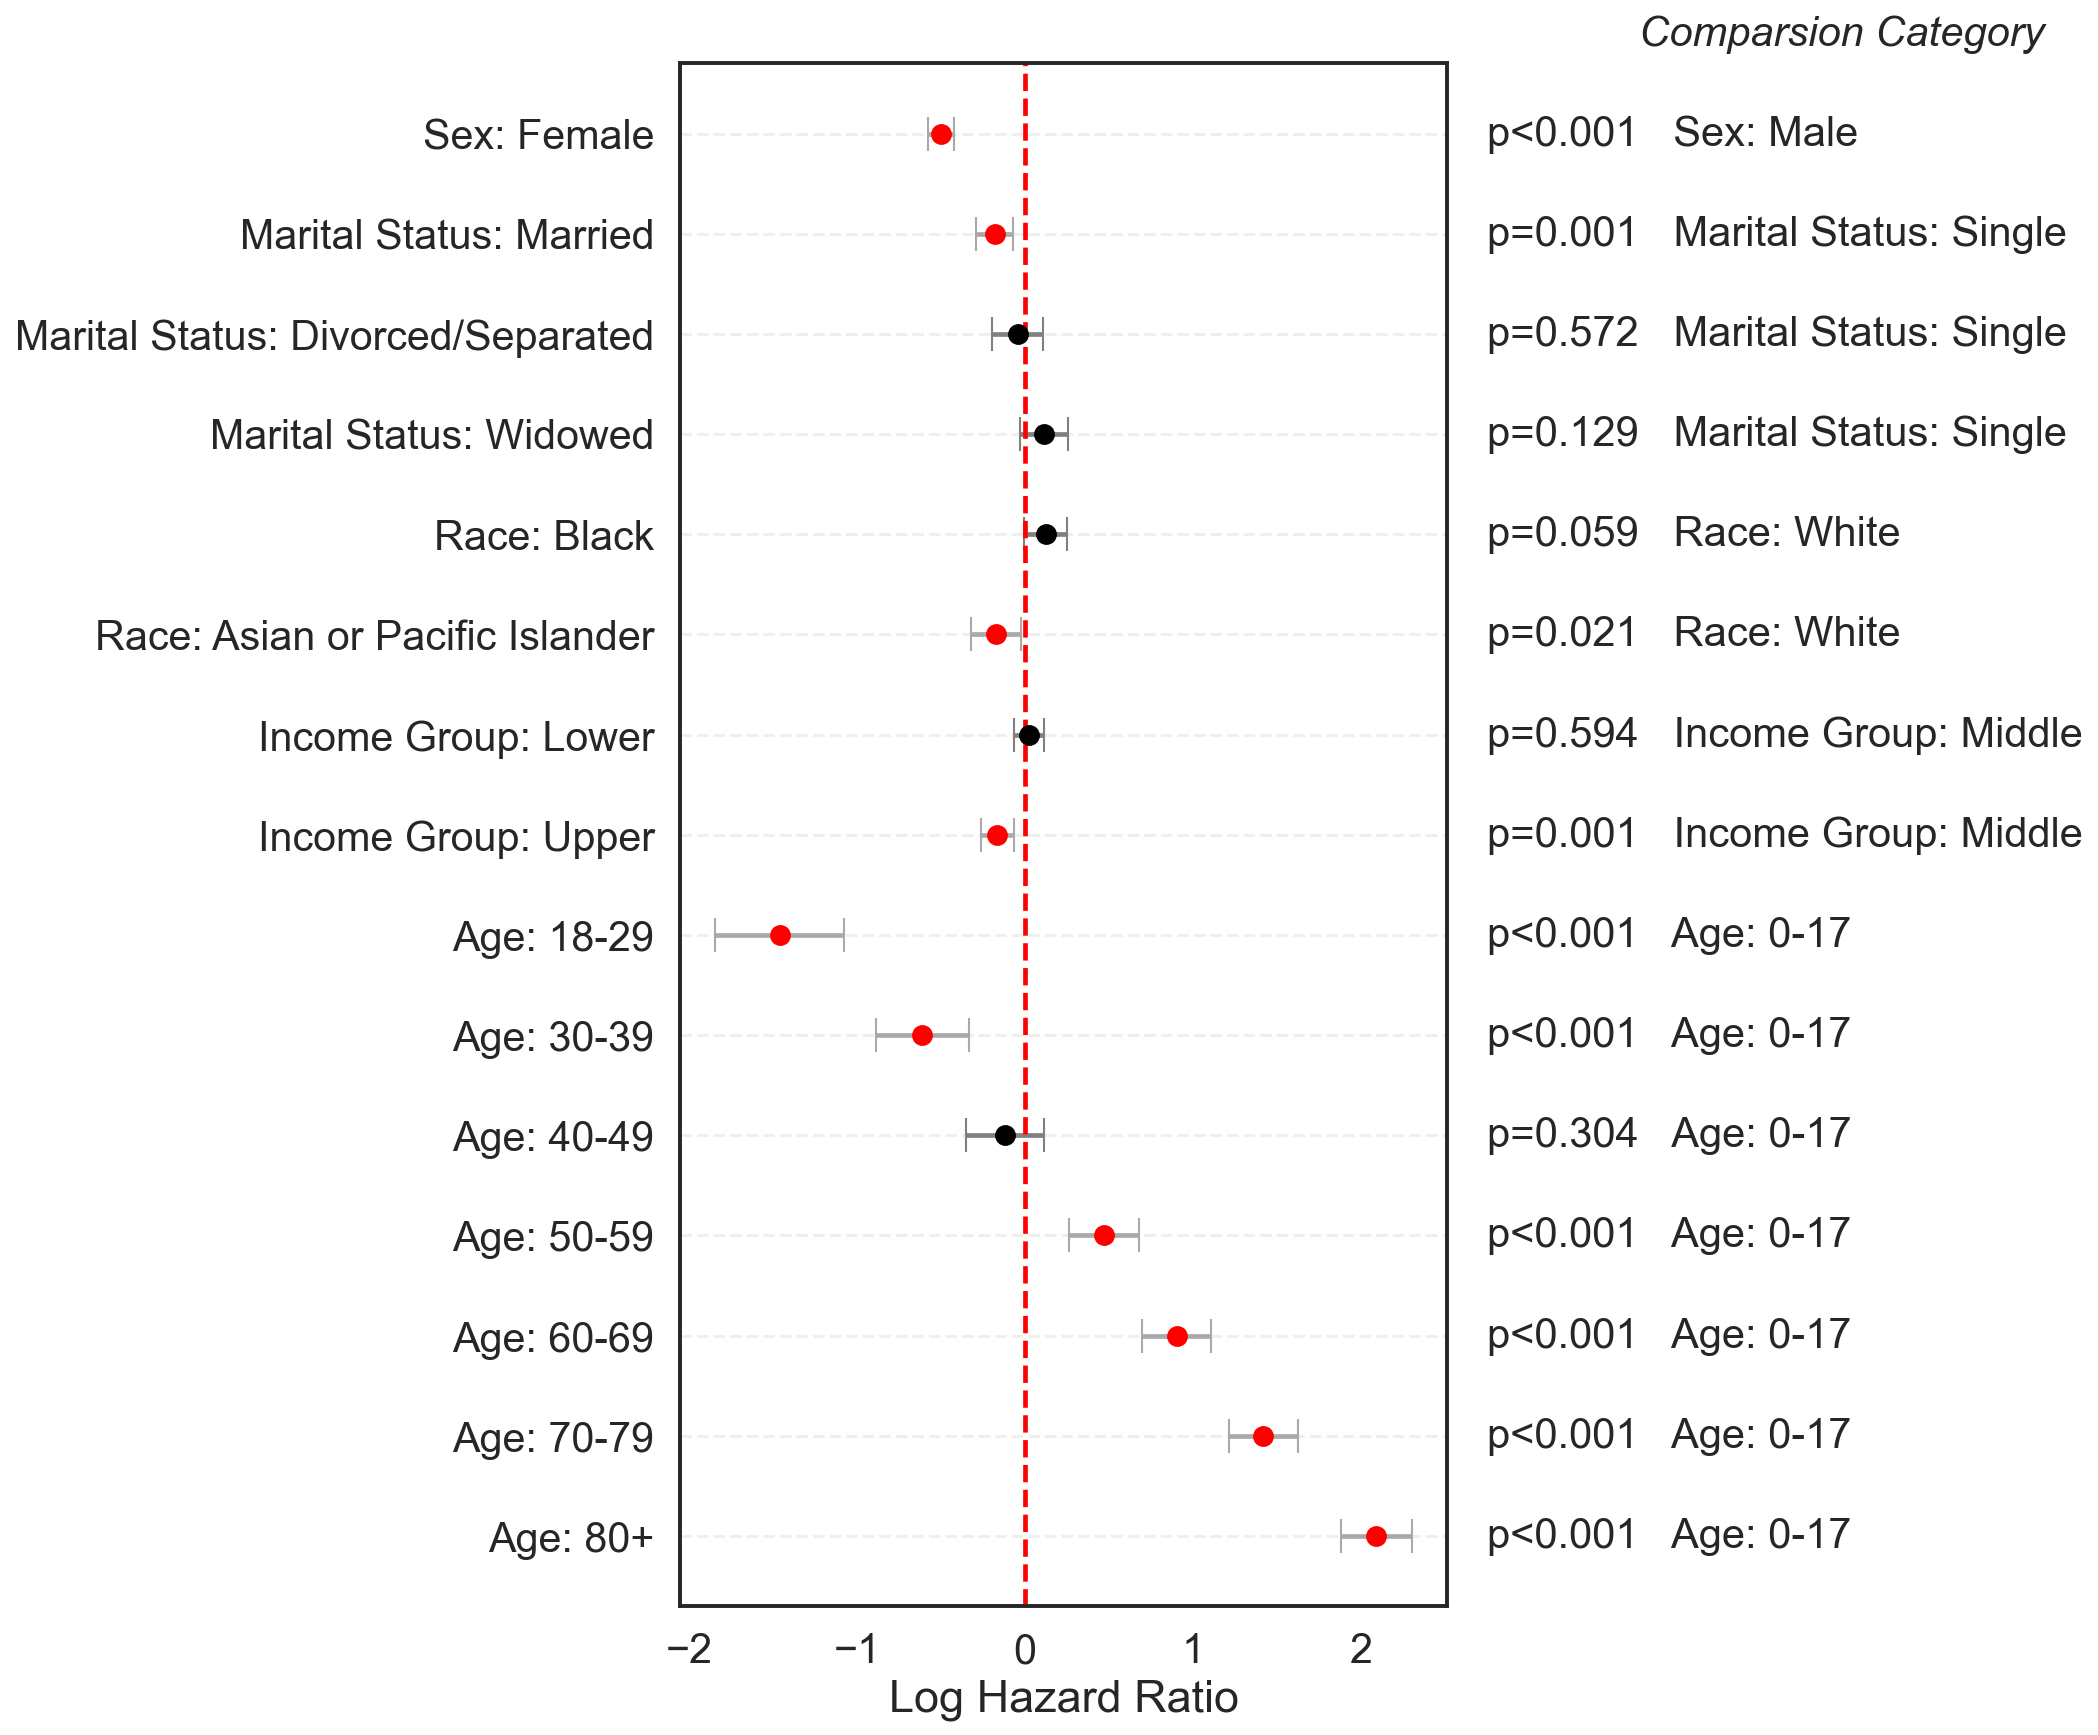

In [29]:
sns.set_context('talk',font_scale=1.2)
# Calculate dynamic x-axis limit
upper_x_limit = np.max(upper_ci) + 0.2
lower_x_limit = np.min(lower_ci) - 0.2
print(upper_x_limit)
# 
# Define the order and reverse it
# Replace underscores with ": " in all variable names
formatted_variables = [varname.replace('_', ': ') for varname in variables]
formatted_variables = formatted_variables[::-1]

order = variables
order = order[::-1]

# Basic default map
default_map = {
    "Age": "Age: 0-17",
    "Primary Tumor Site": "Primary Tumor Site: Parotid gland",
    "Income Tertile": "Income Group: Middle",
    "Grade Level": "Grade Level: Low",
    "Race": "Race: White",
    "Marital Status": "Marital Status: Single",
    "Histology": "Histology: Adenocarcinoma",
    "Sex": "Sex: Male"
}

# Create the mapping
column_mapping = {
    col: (default_map[key] if key in col else "comparison")
    for col in formatted_variables
    for key in default_map
    if key in col
}

# print(column_mapping)
# 

# Reorder coefficients and confidence intervals and convert to hazard ratios
# coefficients_ordered = np.exp(np.array([coef[label] for label in order]))
# lower_ci_ordered = np.exp(np.array([lower_ci[label] for label in order]))
# upper_ci_ordered = np.exp(np.array([upper_ci[label] for label in order]))
# xlineval = 1
# xlabelval = 'Hazard Ratio'

# Reorder coefficients and confidence intervals and don't convert to hazard ratios
coefficients_ordered = (np.array([coef[label] for label in order]))
lower_ci_ordered = (np.array([lower_ci[label] for label in order]))
upper_ci_ordered = (np.array([upper_ci[label] for label in order]))
xlineval = 0
xlabelval = 'Log Hazard Ratio'

# Highlight significant p-values
significant = p_values < 0.05

# Error bars
errors_ordered = [coefficients_ordered - lower_ci_ordered, upper_ci_ordered - coefficients_ordered]
print(upper_ci_ordered)
# Extract p-values
p_values_ordered = [p_values[label] for label in order]


# Plot setup
fig, ax = plt.subplots(1,1,figsize=(16, 12))

# Plot with significant points highlighted
x_val_text, fs_pval = upper_x_limit + 0.25, 20
# print(x_val_text)
for i, label in enumerate(order):
    for key, default in default_map.items():
        if key in label:
            default_category = default_map[key]
            print(default_category)
    if significant[label]:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='red', ecolor='darkgrey', capsize=8)
        

    else:
        plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
                     fmt='o', color='black', ecolor='grey', capsize=8)
    # Add p-value annotations next to each point
    if p_values_ordered[i] < 0.001:
        ax.text(x_val_text, i, f"p<0.001   {default_category}",
                verticalalignment='center', fontsize=fs_pval)
    else:
       ax.text(x_val_text, i, f"p={p_values_ordered[i]:.3f}   {default_category}",
                 verticalalignment='center', fontsize=fs_pval)
        
# add "comparsion category" text
ax.text(x_val_text + .9, len(order), "Comparsion Category", 
        verticalalignment='center', fontsize=fs_pval, fontstyle='italic')
# Add a vertical line for hazard ratio = 1
plt.axvline(x=xlineval, color='red', linestyle='--')

# Update the y-tick labels to the new labels, in the specified order
print(formatted_variables)
formatted_variables = [(var.replace('Tertile','Group')) for var in formatted_variables]
ax.set_yticks(range(len(order)))
ax.set_yticklabels(formatted_variables)

# Customize the plot
plt.xlabel(xlabelval)

# Add gridlines for y-axis (horizontal lines)
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)
# ax.set_xlim(-0.65,0.65)
# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('cox_forest_plot.pdf', format='pdf',dpi=300, bbox_inches='tight')  # Save the plot as a pdf file

# Show the plot
plt.show()

## Sex Stratified Cox Models

In [67]:
filtered_df[[marital_colname,'Income Tertile']].groupby(by=marital_colname, observed=False).value_counts(normalize=True).to_csv('marital_status_proportions.csv')

Empty DataFrame
Columns: [test_statistic, p, -log2(p)]
Index: []

test_statistic         p  -log2(p)
Age_80+        4.626098  0.031489  4.989004

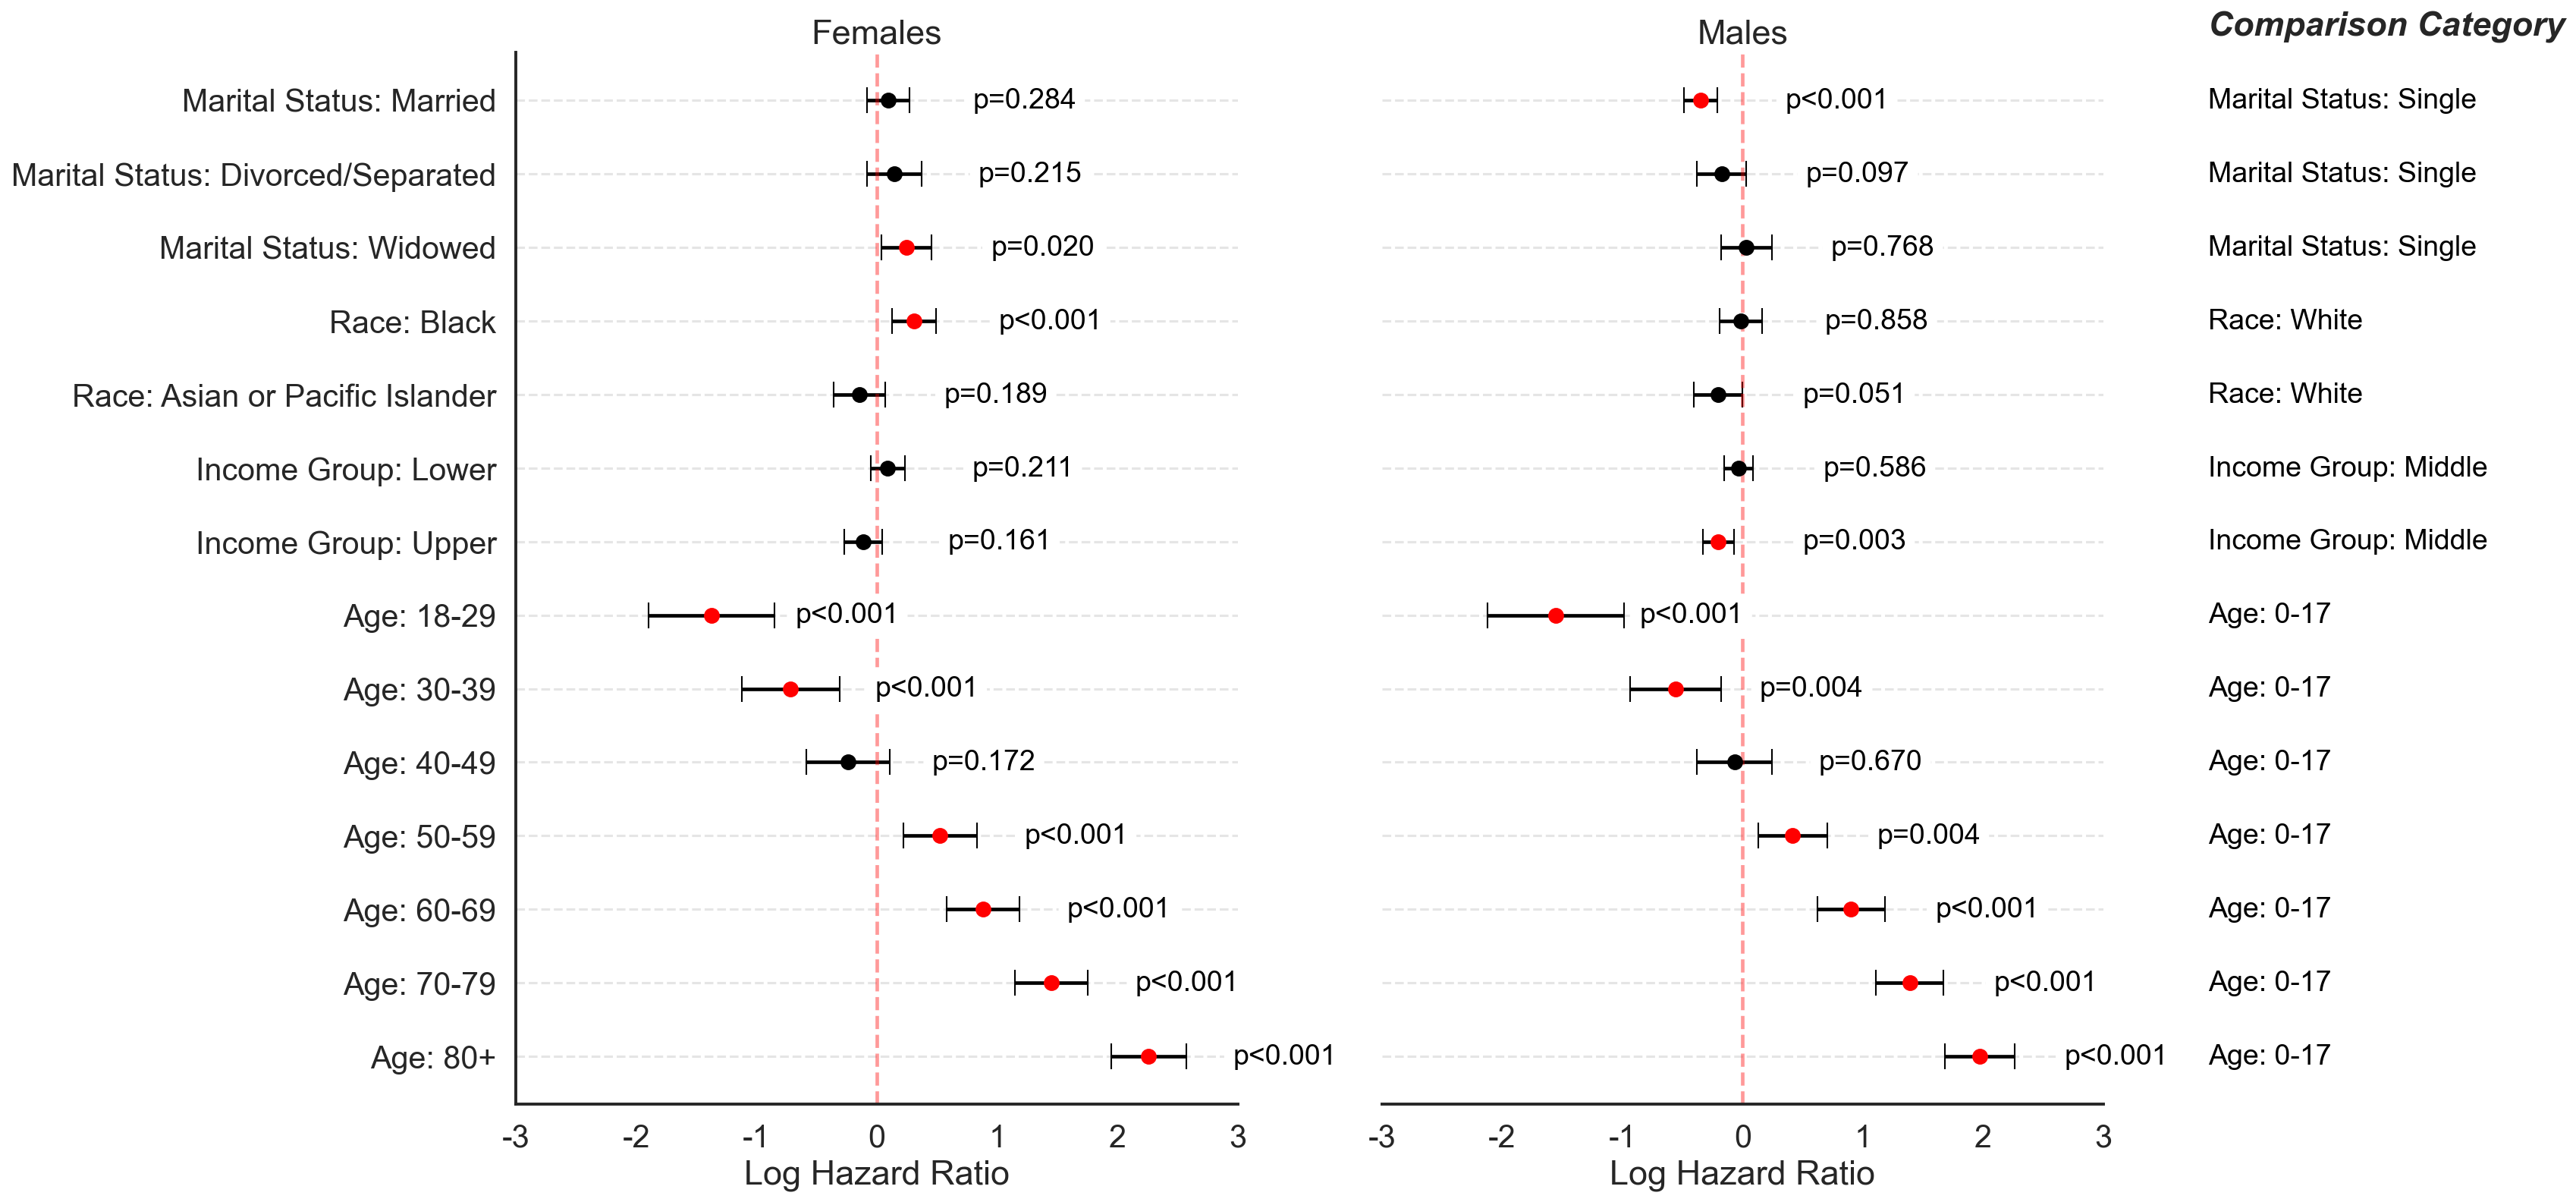

In [60]:
sns.set_context('talk',font_scale=1.2)

cox_df_onehot_coded_male.columns = cox_df_onehot_coded_male.columns.str.replace("Tertile", "Group", regex=False)
cox_df_onehot_coded_female.columns = cox_df_onehot_coded_female.columns.str.replace("Tertile", "Group", regex=False)

# cox_df_onehot_coded_male["Income_Higher_x_Married"] = (
#         cox_df_onehot_coded_male["Income Group_Upper"] * cox_df_onehot_coded_male["Marital Status_Married"]
# )

# Cox model for males
cox_model_male = CoxPHFitter(penalizer=0.01)
cox_model_male.fit(cox_df_onehot_coded_male, duration_col="Survival months", event_col="event_occurred")
cox_summary_male = cox_model_male.summary

# Cox model for females
cox_model_female = CoxPHFitter(penalizer=0.01)
cox_model_female.fit(cox_df_onehot_coded_female, duration_col="Survival months", event_col="event_occurred")
cox_summary_female = cox_model_female.summary

# Test proportional hazards
ph_test_results_male = proportional_hazard_test(cox_model_male, cox_df_onehot_coded_male, time_transform='rank')
summary_ph_test_results_male = ph_test_results_male.summary
# Display proportional hazard violations
display(summary_ph_test_results_male[summary_ph_test_results_male['p'] < 0.05])

# Test proportional hazards
ph_test_results_female = proportional_hazard_test(cox_model_female, cox_df_onehot_coded_female, time_transform='rank')
summary_ph_test_results_female = ph_test_results_female.summary
# Display proportional hazard violations
display(summary_ph_test_results_female[summary_ph_test_results_female['p'] < 0.05])

# Extract coefficients, confidence intervals, and p-values for males
coef_male = cox_model_male.summary["coef"]
lower_ci_male = cox_model_male.summary["coef lower 95%"]
upper_ci_male = cox_model_male.summary["coef upper 95%"]
p_values_male = cox_model_male.summary["p"]
variables_male = coef_male.index


# Extract coefficients, confidence intervals, and p-values for females
coef_female = cox_model_female.summary["coef"]
lower_ci_female = cox_model_female.summary["coef lower 95%"]
upper_ci_female = cox_model_female.summary["coef upper 95%"]
p_values_female = cox_model_female.summary["p"]
variables_female = coef_female.index

# Save the male Cox summary to an Excel file
cox_summary_male.to_excel("cox_summary_male.xlsx", index=True)

# Save the female Cox summary to an Excel file
cox_summary_female.to_excel("cox_summary_female.xlsx", index=True)

# Basic default map
default_map = {
    "Age": "Age: 0-17",
    "Primary Tumor Site": "Primary Tumor Site: Parotid gland",
    "Income Group": "Income Group: Middle",
    "Grade Level": "Grade Level: Low",
    "Race": "Race: White",
    "Marital Status": "Marital Status: Single",
    "Histology": "Histology: Adenocarcinoma",
    "Sex": "Sex: Male"
}

# Create the mapping
column_mapping = {
    col: (default_map[key] if key in col else "comparison")
    for col in variables_male
    for key in default_map
    if key in col
}

sns.set_context("talk", font_scale=1.2)

# Prepare figure with two subplots (Part A and Part B)
fig, axes = plt.subplots(1, 2, figsize=(18, 12), gridspec_kw={"width_ratios": [1, 1]})

# Dynamic x-axis limits
upper_x_limit = max(max(upper_ci_male), max(upper_ci_female)) + 0.2
lower_x_limit = min(min(lower_ci_male), min(lower_ci_female)) - 0.2

# Horizontal offset for p-value annotations
offset = 0.7  # Adjust this value for spacing
comparsion_offset = 1.1
fs_pval = 18
capsize = 8

# Plot for males (Part B)
for i, label in enumerate(variables_male[::-1]):
    coef = coef_male[label]
    ci_low = lower_ci_male[label]
    ci_high = upper_ci_male[label]
    p_val = p_values_male[label]

    color = "red" if p_val < 0.05 else "black"
    axes[1].errorbar(coef, i, xerr=[[coef - ci_low], [ci_high - coef]], fmt="o", color=color, ecolor="black", capsize=capsize)

    # Place p-value annotation next to the error bar
    text = f"p<0.001" if p_val < 0.001 else f"p={p_val:.3f}"
    axes[1].text(coef + offset, i, text, verticalalignment="center", fontsize=fs_pval, color='black',
                 bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))

    comparison_category = column_mapping.get(label, "comparison")
    axes[1].text(
        upper_x_limit + comparsion_offset,  # Position slightly to the right of the plot
        i,
        comparison_category,
        verticalalignment="center",
        fontsize=fs_pval,
        color="black"
    )

# Plot for females (Part A)
for i, label in enumerate(variables_female[::-1]):
    coef = coef_female[label]
    ci_low = lower_ci_female[label]
    ci_high = upper_ci_female[label]
    p_val = p_values_female[label]

    color = "red" if p_val < 0.05 else "black"
    axes[0].errorbar(coef, i, xerr=[[coef - ci_low], [ci_high - coef]], fmt="o", color=color, ecolor="black", capsize=capsize)

    # Place p-value annotation next to the error bar
    text = f"p<0.001" if p_val < 0.001 else f"p={p_val:.3f}"
    axes[0].text(coef + offset, i, text, verticalalignment="center", fontsize=fs_pval, color='black',
                 bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))

# Customize axes
# Customize axes
axes[0].axvline(0, color="red", linestyle="--", alpha=0.4)
axes[0].set_xlim(lower_x_limit, upper_x_limit)
axes[0].set_yticks(range(len(variables_female[::-1])))
axes[0].set_yticklabels([var.replace("_", ": ") for var in variables_female[::-1]])
axes[0].grid(True, which="both", axis="y", linestyle="--", alpha=0.5)
axes[0].set_xlabel("Log Hazard Ratio")
axes[0].set_title("Females")

# Customize Part B
axes[1].axvline(0, color="red", linestyle="--", alpha=0.4)
axes[1].set_xlim(lower_x_limit, upper_x_limit)
axes[1].set_yticks(range(len(variables_male[::-1])))
axes[1].set_yticklabels([])
axes[1].grid(True, which="both", axis="y", linestyle="--", alpha=0.5)
axes[1].set_xlabel("Log Hazard Ratio")
axes[1].set_title("Males")
axes[1].spines['left'].set_visible(False)

# Add a "Comparison Category" title
axes[1].text(
    upper_x_limit + comparsion_offset,
    len(variables_male[::-1]),
    "Comparison Category",
    verticalalignment="center",
    fontsize=fs_pval*1.2,
    fontweight="bold",
    fontstyle="italic"
)
# Customize the x-axis tick marks
ticks = np.linspace(-3,3,7)  # Generate 10 evenly spaced ticks
tick_labels = [f"{tick:.0f}" for tick in ticks]  # Format tick labels to 2 decimal places

# Apply the tick customization for both subplots
for ax in axes:
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    
    ax.spines["right"].set_visible(False)  # Remove the left spine
    ax.spines["top"].set_visible(False)   # Remove the top spine
    # Enable grid lines explicitly
    ax.grid(True, which="both", axis="y", linestyle="--", alpha=0.5)
# plt.tight_layout()
plt.savefig("cox_forest_plot_males_females.pdf", format="pdf", dpi=300)
plt.show()


f## Model 2: Effect (Deviation) Coding

### Data preparation and effect coding for demographic determinants

In [31]:
# # Filter the dataset to include only relevant columns for the Cox model
# demographic_determinants = ['Age recode with single ages and 90+', 'Sex','Histology','Marital status at diagnosis','Race recode (W, B, AI, API)','Grade Level','Income Quartile' ]
# 
# df_cox_dem = df[demographic_determinants + ['Survival months','event_occurred']] # df is used above during KM survival curves analysis

# 
# # Handle special cases in age column then rename for ease.
# age_replacement = {'≤1': '1', '90+': '90'}  # Replace special cases for age
# df_cox_dem['Age recode with single ages and 90+'] = df_cox_dem['Age recode with single ages and 90+'].cat.rename_categories(age_replacement).astype(float)
# 
# df_cox_dem = df_cox_dem.rename(columns={'Race recode (W, B, AI, API)':'Race', 
#                                         'Age recode with single ages and 90+':'Age',
#                                         'Marital status at diagnosis':'Marital Status',
#                                         })
# 
# # Identify categorical columns
# categorical_columns = df_cox_dem.select_dtypes(include='category').columns.tolist()
# 
# # Due to the retention of all categories within each categorical variable, we will get perfect collinearity, causing a singularity in the Proportional Hazards analysis. We want to compare against the overall mean hazard, which will resolve the collinearity issue.
# cox_df_effect_coded = df_cox_dem.copy() # Copy data so as not to overwrite original table
# 
# # Deviation coding -- generate dummy variables (retain all), then enforce sum-to-zero constraint for deviation encoding
# for col in categorical_columns:
#     # Update categories to prepend the column name
#     cox_df_effect_coded[col] = cox_df_effect_coded[col].cat.rename_categories(lambda x: f"{col}: {x}")
#     
#     # Create dummy variables for the categories
#     dummies = pd.get_dummies(cox_df_effect_coded[col], drop_first=False)
#     
#     # Subtract the row mean across the dummies to enforce sum-to-zero constraint
#     deviation_coded = dummies.sub(dummies.mean(axis=1), axis=0)
#     
#     # Add deviation-coded columns back to the DataFrame
#     cox_df_effect_coded = pd.concat([cox_df_effect_coded,deviation_coded], axis=1)
# 
# scaler = StandardScaler()
# cox_df_effect_coded['Age'] = scaler.fit_transform(cox_df_effect_coded[['Age']])
# 
# cox_df_effect_coded = cox_df_effect_coded.drop(categorical_columns, axis=1)
# display(cox_df_effect_coded)
# print(cox_df_effect_coded.columns)


### Model Fitting (Effect Coded)

In [32]:
# # Fit the Cox model
# cox_model = CoxPHFitter(penalizer=0.01)
# cox_model.fit(cox_df_effect_coded, duration_col='Survival months', event_col='event_occurred')
# 
# # Print the summary
# eff_coded_cox_summary = cox_model.summary
# output_file_path = 'eff_coded_cox_summary.xlsx'
# eff_coded_cox_summary.to_excel(output_file_path)
# 
# # Extract coefficients, confidence intervals, and p-values
# coef = eff_coded_cox_summary['coef']
# lower_ci = eff_coded_cox_summary['coef lower 95%']
# upper_ci = eff_coded_cox_summary['coef upper 95%']
# p_values = eff_coded_cox_summary['p']
# variables = coef.index
# display(eff_coded_cox_summary)
# 
# devenc_order = eff_coded_cox_summary.index.to_list()
# devenc_order = devenc_order[::-1]
# 
# 
# # Reorder coefficients and confidence intervals and don't convert to hazard ratios
# coefficients_ordered = (np.array([coef[label] for label in devenc_order]))
# lower_ci_ordered = (np.array([lower_ci[label] for label in devenc_order]))
# upper_ci_ordered = (np.array([upper_ci[label] for label in devenc_order]))
# xlineval = 0
# xlabelval = 'Log Hazard Ratio'
# 
# # Highlight significant p-values
# significant = p_values < 0.05
# 
# # Error bars
# errors_ordered = [coefficients_ordered - lower_ci_ordered, upper_ci_ordered - coefficients_ordered]
# 
# # Plot setup
# fig, ax = plt.subplots(figsize=(16, 16))
# 
# # Plot with significant points highlighted
# for i, label in enumerate(devenc_order):
#     if significant[label]:
#         plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
#                      fmt='o', color='black', ecolor='darkgrey', capsize=3)  # Significant in red
#     else:
#         plt.errorbar(coefficients_ordered[i], i, xerr=[[coefficients_ordered[i] - lower_ci_ordered[i]], [upper_ci_ordered[i] - coefficients_ordered[i]]],
#                      fmt='o', color='black', ecolor='grey', capsize=3)
# 
# # Add a vertical line for hazard ratio = 1
# plt.axvline(x=xlineval, color='red', linestyle='--')
# 
# # Update the y-tick labels to the new labels, in the specified order
# ax.set_yticks(range(len(devenc_order)))
# ax.set_yticklabels([label for label in devenc_order])
# 
# # Set X-axis
# # plt.xlim(-.25,2.25)
# 
# # Customize the plot
# plt.xlabel(xlabelval)
# plt.title('Forest Plot of Cox Proportional Hazards Model')
# 
# # Add gridlines for y-axis (horizontal lines)
# ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)
# 
# # Adjust layout and save the plot
# plt.tight_layout()
# plt.savefig('cox_effcoded_forest_plot.png', dpi=300, bbox_inches='tight')  # Save the plot as a PNG file
# 
# # Show the plot
# plt.show()


# Being Male as a Risk Factor? Sex and Grade Level

In [33]:

# # Group by 'Sex' and 'Grade Label' and sort based on the defined order
# result = (
#     cox_df_updated[['Sex', 'Histology', 'Grade Level']]
#     .groupby('Sex', observed=False)['Grade Level']
#     .value_counts()
#     .sort_index(level=['Sex', 'Grade Level'])
# )
# print(result)
# # Convert the result to a DataFrame and reset index
# result_df = result.reset_index()
# display(result_df)
# # Plot the result using seaborn
# plt.figure(figsize=(20, 15))
# sns.barplot(
#     data=result_df,
#     x='Grade Level',
#     y='count',
#     hue='Sex',
#     palette='RdBu'
# )

# # Set labels and title
# plt.xlabel('Grade')
# plt.ylabel('Number of Cases')
# plt.title('Counts of Grade Level by Sex')

# # Save & Display the plot
# plt.tight_layout()
# plt.savefig('FvM_GradeCounts.png',dpi=300,bbox_inches='tight')
# plt.show()


# Race and Grade Level

In [34]:
# # Group by 'Race' and 'Grade Label' and sort based on the defined order
# result = (
#     cox_df_updated[['Race recode (W, B, AI, API)', 'Grade Level']]
#     .groupby('Race recode (W, B, AI, API)', observed=False)['Grade Level']
#     .value_counts()
#     .sort_index(level=['Race recode (W, B, AI, API)', 'Grade Level'])
# )
# print(result)
# # Convert the result to a DataFrame and reset index
# result_df = result.reset_index()
# display(result_df)
# # Plot the result using seaborn
# plt.figure(figsize=(20, 15))
# sns.barplot(
#     data=result_df,
#     x='Grade Level',
#     y='count',
#     hue='Race recode (W, B, AI, API)',
#     palette='rocket_r'
# )
# 
# # Set labels and title
# plt.xlabel('Grade')
# plt.ylabel('Number of Cases')
# # plt.title('Counts of Grade Level by Sex')
# 
# # Save & Display the plot
# plt.tight_layout()
# plt.savefig('Race_GradeCounts.png',dpi=300,bbox_inches='tight')
# plt.show()


# Race and Income

In [35]:
# result_total = (
#     cox_df_updated[['Race recode (W, B, AI, API)', 'Income_above_below_median', 'event_occurred']]
#     .groupby('Race recode (W, B, AI, API)', observed=False)[['Income_above_below_median']]
#     .value_counts()
#     .sort_index(level=['Race recode (W, B, AI, API)', 'Income_above_below_median'])
# )
# 
# result_survival = (
#     cox_df_updated[['Race recode (W, B, AI, API)', 'Income_above_below_median', 'event_occurred']]
#     .groupby('Race recode (W, B, AI, API)', observed=False)[['Income_above_below_median','event_occurred']]
#     .value_counts()
#     .sort_index(level=['Race recode (W, B, AI, API)', 'Income_above_below_median'])
# )
# # Convert the result to a DataFrame and reset index
# result_df_total = result_total.reset_index()
# # display(result_df_total)
# 
# result_df_survival = result_survival.reset_index()
# # display(result_df_survival)
# 
# # Plot the result using seaborn
# plt.figure(figsize=(20, 15))
# 
# # Generate the 'rocket_r' palette
# rocket_palette = sns.color_palette("rocket_r", n_colors=10)
# # Generate alternative slate of palettes
# darkened_palette = sns.color_palette(rocket_palette[0:10:2], desat=.2)  # desat < 1 brightens the colors
# 
# # Create a count plot to visualize the counts with stacking by event_occurred and race differentiation
# bp_total = sns.barplot(
#     data=result_df_total,
#     x='Income_above_below_median',  # X-axis is income above/below median
#     y='count',  # Y-axis is the count of individuals
#     hue='Race recode (W, B, AI, API)',  # Use race as the hue to differentiate the bars
#     palette=rocket_palette[0:10:2],
#     edgecolor='black',
#     linewidth=2,
# )
# 
# # Overlay a second bar plot for event_occurred (alive vs not alive) for stacked effect
# bp_dead = sns.barplot(
#     data=result_df_survival[result_df_survival['event_occurred']==1],
#     x='Income_above_below_median',
#     y='count',
#     hue='Race recode (W, B, AI, API)',  # Use event_occurred to fill the bars for alive vs not alive
#     palette=darkened_palette,
#     edgecolor='black',
#     linewidth=2,
#     legend=False
# )
# 
# plt.xlabel('Income')
# plt.ylabel('Number of Cases')
# 
# # Adjust the legend fontsize
# xlabel_fontsize = bp_total.xaxis.label.get_size()
# plt.legend(fontsize=xlabel_fontsize * .7)  # Change legend fontsize and title fontsize
# 
# # Save & Display the plot
# plt.tight_layout()
# plt.savefig('Race_IncomeAboveBelowMedian.png',dpi=300,bbox_inches='tight')
# plt.show()


# Logistic Regression
### Can we predict which patients are likely to die?

In [36]:
# # target variable
# y = cox_df_updated_encoded['event_occurred']  # Use 'event_occurred' as the binary outcome variable
# 
# # Drop the target column from the feature set
# X = cox_df_updated_encoded.drop(['event_occurred'], axis=1)
# 
# # Split the data into training and test sets (70% training, 30% testing)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
# 
# # Initialize the Logistic Regression classifier
# log_reg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=69)
# 
# # Fit the model on the training data
# log_reg.fit(X_train, y_train)
# 
# # Predict on the test data
# y_pred_log = log_reg.predict(X_test)
# 
# # Evaluate the Logistic Regression model
# print("Logistic Regression Classifier Evaluation:")
# print(classification_report(y_test, y_pred_log))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_log))
# 
# # ROC-AUC Score
# log_reg_roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
# print(f"ROC-AUC Score for Logistic Regression: {log_reg_roc_auc}")
# 
# # Plot ROC curve
# fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {log_reg_roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Logistic Regression')
# plt.legend(loc='lower right')
# plt.show()

# Random Forest Classifier

In [37]:
# rf_clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)

# 
# # Fit the model on the training data
# rf_clf.fit(X_train, y_train)
# 
# # Predict on the test data
# y_pred_rf = rf_clf.predict(X_test)
# 
# # Evaluate the Random Forest Classifier
# print("Random Forest Classifier Evaluation:")
# print(classification_report(y_test, y_pred_rf))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))

# # ROC-AUC Score for Random Forest
# rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
# print(f"ROC-AUC Score for Random Forest: {rf_roc_auc}")
# 
# # Plot ROC curve for Random Forest
# fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
# plt.figure(figsize=(10, 6))
# plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Random Forest')
# plt.legend(loc='lower right')
# plt.show()

In [38]:
# # Initialize the Random Forest Classifier
# rf = RandomForestClassifier()
# 
# # Define the parameter grid for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 300],  # Number of trees
#     'max_depth': [None, 5,6,7,8,9,10],  # Max depth of the tree
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples at a leaf node
#     'bootstrap': [True, False]  # Whether bootstrap samples are used
# }
# 
# # Set up Randomized Search (search over 20 different combinations)
# random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, n_iter=20, cv=5, scoring='roc_auc', verbose=2, random_state=69)
# 
# # Fit the Randomized Search model
# random_search_rf.fit(X_train, y_train)
# 
# # Best parameters found by Randomized Search
# print("Best parameters for Random Forest:", random_search_rf.best_params_)
# 
# # Make predictions using the best model
# best_rf_model = random_search_rf.best_estimator_
# y_pred_rf = best_rf_model.predict(X_test)
# 
# # Evaluate performance
# print("Random Forest Evaluation after Hyperparameter Tuning:")
# print(classification_report(y_test, y_pred_rf))
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_rf))
# 
# 
# 
# # Calculate the ROC-AUC score using the best_rf_model (the fitted model from RandomizedSearchCV)
# rf_roc_auc = roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])
# print(f"ROC-AUC Score for Random Forest: {rf_roc_auc}")
# 
# # Plot the ROC curve for Random Forest
# fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
# plt.figure(figsize=(10, 6))
# plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc_auc:.2f})")
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Random Forest')
# plt.legend(loc='lower right')
# plt.show()